<a href="https://colab.research.google.com/github/rafavidal1709/projeto_aplicado_iv/blob/main/Testes_com_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

In [2]:
import os
import re
import numpy as np
from datetime import datetime, timedelta
import rasterio
import matplotlib.pyplot as plt
import json
import tqdm
import random
import math
from IPython.display import display, clear_output

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_path = "/content/drive/MyDrive/copernicus_s2_sr_harmonized/"

all_files = os.listdir(base_path)

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})\_clean.tif$', re.IGNORECASE)
dates = sorted(set(match.group(1) for nome in all_files if (match := padrao.match(nome))))

print(f"clean subset length: {len(dates)}")

padrao = re.compile(r'(\d{4}_\d{2}_\d{2})\_note.npy$', re.IGNORECASE)
notes = sorted(set(match.group(1) for nome in all_files if (match := padrao.match(nome))))

print(f"{len(notes)}")

clean subset length: 455
41


# Pré-processamento da sequência temporal da imagem

In [ ]:
def gerar_pontos_dispersos(H, W, amount, size, força=1000, ciclos=50, mostrar=True):
    H_reduzido = H - size
    W_reduzido = W - size

    pontos = [[random.uniform(0, W_reduzido), random.uniform(0, H_reduzido)] for _ in range(amount)]

    for ciclo in range(ciclos):
        for i in range(amount):
            fx, fy = 0, 0
            xi, yi = pontos[i]

            for j in range(amount):
                if i == j:
                    continue
                xj, yj = pontos[j]

                # Calcula distâncias mínimas cíclicas
                dx = xi - xj
                if abs(dx) > W_reduzido / 2:
                    dx -= math.copysign(W_reduzido, dx)

                dy = yi - yj
                if abs(dy) > H_reduzido / 2:
                    dy -= math.copysign(H_reduzido, dy)

                dist_sq = dx * dx + dy * dy + 1e-6
                dist = math.sqrt(dist_sq)
                repulsão = força / dist_sq
                fx += (dx / dist) * repulsão
                fy += (dy / dist) * repulsão

            # Aplica movimento com wraparound (ciclo)
            pontos[i][0] = (pontos[i][0] + fx) % W_reduzido
            pontos[i][1] = (pontos[i][1] + fy) % H_reduzido

        if mostrar:
            clear_output(wait=True)
            plt.figure(figsize=(10, 10))
            xs, ys = zip(*[(x, y) for x, y in pontos])
            plt.scatter(xs, ys, s=5)
            plt.xlim(0, W)
            plt.ylim(0, H)
            plt.gca().invert_yaxis()
            plt.grid(True)
            plt.title(f"Ciclo {ciclo+1}/{ciclos}")
            display(plt.gcf())
            plt.close()

    return [(int(x), int(y)) for x, y in pontos]

origin_list = gerar_pontos_dispersos(3137, 2983, 6000, 100)

In [ ]:
#with open(base_path + "origin_list.json", "w") as f:
#    json.dump(origin_list, f, indent=2)

In [11]:
origin_list = json.load(open(base_path + "origin_list.json", "r"))

In [ ]:
for i, coluna in enumerate(list(zip(*origin_list))):
    print(f"Coluna {i}: min = {min(coluna)}, max = {max(coluna)}")

Coluna 0: min = 0, max = 2882
Coluna 1: min = 1, max = 3036


In [5]:
def mult_estatisticas_canais(path_tif, size, origin_list):
    with rasterio.open(path_tif) as src:
        img = src.read()  # Shape: (C, H, W)
        num_canais = img.shape[0]

    #print(f"image shape: {img.shape}")
    res = []
    for origin in origin_list:
        estatisticas = []
        for i in range(num_canais):
            dados = img[i, origin[1]:origin[1]+size, origin[0]:origin[0]+size].flatten()
            if dados.shape[0]!=size**2:
                print(f"Shape não condiz na {origin}: {dados.shape[0]} elementos")
            canal_stats = {
                'banda': f'Band {i+1}',
                'media': float(np.mean(dados)),
                'mediana': float(np.median(dados)),
                'q1': float(np.percentile(dados, 25)),
                'q3': float(np.percentile(dados, 75)),
                'min': float(np.min(dados)),
                'max': float(np.max(dados)),
                'desvio_padrao': float(np.std(dados))
            }

            estatisticas.append(canal_stats)
        res.append(estatisticas)
    return res

#mult_estatisticas_canais(base_path+dates[-1]+"_clean.tif", 100, origin_list)[:5]

In [ ]:
import os
import json
import tqdm

def salvar_log(log_dir, date, resultado):
    os.makedirs(log_dir, exist_ok=True)
    with open(os.path.join(log_dir, f"{date}.json"), "w") as f:
        json.dump(resultado, f)

def carregar_log(log_dir, date):
    try:
        with open(os.path.join(log_dir, f"{date}.json"), "r") as f:
            return json.load(f)
    except:
        return None

def encontrar_ultimo_log_valido(log_dir, dates):
    for date in reversed(dates):
        resultado = carregar_log(log_dir, date)
        if resultado is not None:
            return date
    return None

def recompilar_dados(log_dir, dates, saida_json):
    dados = []
    for date in dates:
        resultado = carregar_log(log_dir, date)
        if resultado is not None:
            dados.append(resultado)
    with open(saida_json, "w") as f:
        json.dump(dados, f, indent=2)
    return dados

def processar_em_batch(dates, origin_list, mult_estatisticas_canais, base_path="./", log_subdir="logs", nome_saida="dados_mult.json"):
    log_dir = os.path.join(base_path, log_subdir)
    saida_json = os.path.join(base_path, nome_saida)

    ultimo_date_valido = encontrar_ultimo_log_valido(log_dir, dates)
    if ultimo_date_valido:
        start_index = dates.index(ultimo_date_valido) + 1
    else:
        start_index = 0

    for date in tqdm.tqdm(dates[start_index:]):
        log_path = os.path.join(log_dir, f"{date}.json")
        if os.path.exists(log_path):
            print(f"Pulando {date}, já processado.")
            continue
        try:
            resultado = mult_estatisticas_canais(os.path.join(base_path, f"{date}_clean.tif"), 100, origin_list)
            salvar_log(log_dir, date, resultado)
        except Exception as e:
            print(f"Erro ao processar {date}: {e}")
            # Tenta duplicar o último resultado válido
            if start_index > 0 or any(os.path.exists(os.path.join(log_dir, f"{d}.json")) for d in dates[:start_index]):
                ultimo_valido = carregar_log(log_dir, dates[start_index - 1])
                if ultimo_valido:
                    print(f"Duplicando o último dado válido para {date}")
                    salvar_log(log_dir, date, ultimo_valido)
                else:
                    print("Erro: nenhum dado anterior válido encontrado para duplicar.")
            else:
                print("Erro: nenhum dado anterior disponível para duplicar.")
            continue

    dados = recompilar_dados(log_dir, dates, saida_json)
    print("Processamento finalizado.")
    print(f"Última data válida: {ultimo_date_valido}")
    print(f"Total de dados salvos: {len(dados)}")

processar_em_batch(dates, origin_list, mult_estatisticas_canais, base_path=base_path)

100%|██████████| 455/455 [6:21:40<00:00, 50.33s/it]


Processamento finalizado.
Última data válida: None
Total de dados salvos: 455


In [6]:
with open(base_path + "dados_mult.json", "r") as f:
    dados = json.load(f)

print(f"Total de imagens: {len(dados)}")
print(f"Total de origens: {len(dados[0])}")
print(f"Total de canais: {len(dados[0][0])}")

Total de imagens: 455
Total de origens: 6000
Total de canais: 12


In [7]:
def reorganizar_estatisticas(data_nested):
    D = len(data_nested)  # número de imagens
    O = len(data_nested[0])  # número de origens
    C = len(data_nested[0][0])  # número de canais

    # Extrai as métricas numéricas do primeiro dicionário
    all_keys = list(data_nested[0][0][0].keys())
    METRIC_KEYS = [k for k in all_keys if k != 'banda' and isinstance(data_nested[0][0][0][k], (int, float))]
    M = len(METRIC_KEYS)

    # Inicializa array [origem][métrica][canal][imagem]
    arr = np.zeros((O, M, C, D), dtype=np.float32)

    for d in range(D):  # imagens
        for o in range(O):  # origens
            for c in range(C):  # canais
                canal_dict = data_nested[d][o][c]
                for m_idx, key in enumerate(METRIC_KEYS):
                    arr[o, m_idx, c, d] = float(canal_dict[key])

    return arr, METRIC_KEYS

ordered_data, METRIC_KEYS = reorganizar_estatisticas(dados)

In [30]:
print(f"ordered_data shape: {ordered_data.shape}")
print(f"METRIC_KEYS: {METRIC_KEYS}")
ordered_data[0, 0, 0]

ordered_data shape: (6000, 7, 12, 455)
METRIC_KEYS: ['media', 'mediana', 'q1', 'q3', 'min', 'max', 'desvio_padrao']


array([3.1951489e+02, 4.1919070e+02, 5.7103717e+02, 6.6443109e+02,
       7.3770001e+02, 5.7184387e+02, 3.2943729e+02, 7.8184650e+02,
       3.5834460e+02, 2.9625061e+02, 2.3470700e+02, 5.2019940e+02,
       8.0623621e+02, 8.0023712e+02, 7.9450110e+02, 7.8882703e+02,
       7.6785303e+02, 7.4722180e+02, 9.5820929e+02, 7.3508008e+02,
       5.1204230e+02, 2.7677789e+02, 2.4756441e+02, 2.5023260e+02,
       2.5354440e+02, 3.0575491e+02, 1.5174719e+02, 3.0565820e+02,
       2.2405099e+02, 1.4303690e+02, 5.1214410e+02, 4.0509009e+02,
       9.2793701e+01, 6.8238098e+01, 1.2415710e+02, 2.3456520e+02,
       1.3808000e+02, 1.0413650e+02, 1.5964639e+02, 1.0901450e+02,
       2.7069089e+02, 7.4539902e+01, 1.4184120e+02, 3.4347800e+02,
       2.9750171e+02, 1.5504250e+02, 1.7331779e+02, 5.3818781e+02,
       5.7614618e+02, 1.7040939e+02, 1.7385400e+02, 1.7792979e+02,
       2.5950500e+02, 2.6785800e+02, 2.7682791e+02, 1.4267641e+02,
       3.6447910e+02, 3.3730420e+02, 8.5292712e+02, 4.5965509e

In [9]:
#np.save(base_path + "ordered_mult_data.npy", ordered_data)

In [12]:
"""
KEYS = {
    "origin" : len(origin_list),
    "metric" : METRIC_KEYS,
    "channel" : ordered_data.shape[2],
    "image" : dates
}

with open(base_path + "mult_data_keys.json", "w") as f:
    json.dump(KEYS, f, indent=2)
"""

# Carragando dados pré-processados

In [5]:
ordered_data = np.load(base_path + "ordered_mult_data.npy")
with open(base_path + "mult_data_keys.json", "r") as f:
    KEYS = json.load(f)

# Dados do tempo e ciclos

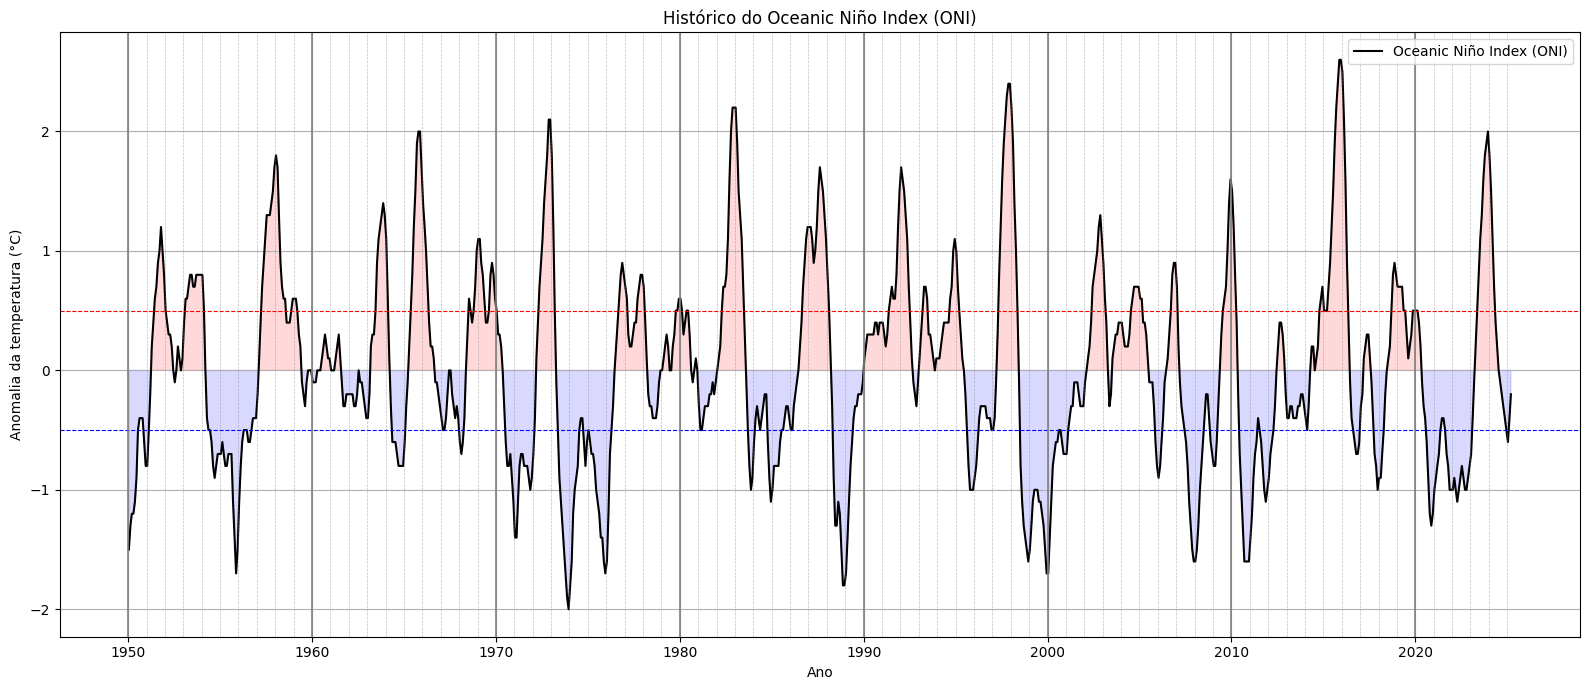

In [6]:
import datetime
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

class ONIIndex:
    def __init__(self, show_plot=True):
        # Lê e processa os dados ONI
        url = 'https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php'
        tables = pd.read_html(url, header=0)
        oni = tables[-3]
        oni = oni.rename(columns={oni.columns[0]: "Year"})
        oni = oni[oni["Year"].astype(str).str.isnumeric()]
        oni["Year"] = oni["Year"].astype(int)
        oni = oni.melt(id_vars=["Year"], var_name="Season", value_name="ONI")
        oni["ONI"] = pd.to_numeric(oni["ONI"], errors='coerce')
        oni = oni.dropna(subset=["ONI"])

        month_map = {
            "DJF": 1, "JFM": 2, "FMA": 3, "MAM": 4,
            "AMJ": 5, "MJJ": 6, "JJA": 7, "JAS": 8,
            "ASO": 9, "SON": 10, "OND": 11, "NDJ": 12
        }
        oni["Month"] = oni["Season"].map(month_map)
        oni["Date"] = pd.to_datetime(dict(year=oni["Year"], month=oni["Month"], day=15))
        oni = oni.sort_values("Date")

        self.data = oni[["Date", "ONI"]].reset_index(drop=True)

        if show_plot:
            self.plot()

    def plot(self):
        plt.figure(figsize=(16, 7))
        plt.plot(self.data["Date"], self.data["ONI"], label="Oceanic Niño Index (ONI)", color="black")
        plt.fill_between(self.data["Date"], 0, self.data["ONI"],
                         where=(self.data["ONI"] >= 0), interpolate=True, color='red', alpha=0.15)
        plt.fill_between(self.data["Date"], 0, self.data["ONI"],
                         where=(self.data["ONI"] <= 0), interpolate=True, color='blue', alpha=0.15)
        plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8)
        plt.axhline(-0.5, color='blue', linestyle='--', linewidth=0.8)

        for ano in self.data["Date"].dt.year.unique():
            linha = pd.Timestamp(f'{ano}-01-01')
            if ano % 10 == 0:
                plt.axvline(x=linha, color='gray', linestyle='-', linewidth=1.2)
            else:
                plt.axvline(x=linha, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

        plt.title("Histórico do Oceanic Niño Index (ONI)")
        plt.xlabel("Ano")
        plt.ylabel("Anomalia da temperatura (°C)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def get_nearest_value(self, date):
        if isinstance(date, datetime.datetime):
            date = date.date()
        elif not isinstance(date, datetime.date):
            raise ValueError("A entrada deve ser datetime.date ou datetime.datetime")

        # Encontra o índice da data mais próxima
        idx = (self.data["Date"] - pd.Timestamp(date)).abs().idxmin()
        return self.data.iloc[idx]["ONI"]

oni = ONIIndex()  # Instancia e plota

def encode_datetime_features(date):
    """
    Recebe uma data e retorna um tensor PyTorch com:
    - seno da época do ano (base 18 de março)
    - cosseno da época do ano (base 18 de março)
    - tempo normalizado entre 24/02/2000 e 24/02/2050
    """
    if not isinstance(date, (datetime.date, datetime.datetime)):
        raise ValueError("A entrada deve ser datetime.date ou datetime.datetime")

    # Garantir datetime.date
    if isinstance(date, datetime.datetime):
        date = date.date()

    # --- Cálculo senoidal com base no dia ideal (18 de março de 2025)
    base_sazonal = datetime.date(2025, 3, 18)
    delta_days = (date - base_sazonal).days % 365.25
    angle = (delta_days / 365.25) * 2 * np.pi
    sin_time = np.sin(angle)
    cos_time = np.cos(angle)

    # --- Cálculo da normalização entre a primeira imagem do TERRA e 2050
    start_global = datetime.date(2000, 2, 24) # Início da coleta de dados do satélie TERRA (MODIS)
    end_global = datetime.date(2050, 2, 24)
    total_seconds = (end_global - start_global).total_seconds()
    elapsed_seconds = (date - start_global).total_seconds()
    normalized_time = elapsed_seconds / total_seconds

    # --- Criar tensor PyTorch com os quatro valores
    tensor = torch.tensor([normalized_time, sin_time, cos_time, oni.get_nearest_value(date)/2], dtype=torch.float32)
    return tensor


# Data Loader

In [16]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesForecastDataset(Dataset):
    def __init__(self, data_array, date_strings, encode_datetime_features, input_len=309, forecast_len=146):
        self.data = data_array / 16384.0 # shape: (6000, 7, 12, 455)
        self.date_strings = date_strings  # lista de strings tipo "2018_12_13"
        self.encode_datetime_features = encode_datetime_features
        self.input_len = input_len
        self.forecast_len = forecast_len

        # Convertendo as strings para datetime na inicialização
        self.dates = [datetime.datetime.strptime(date_str, "%Y_%m_%d") for date_str in self.date_strings]

        # Pré-processar as datetime features uma única vez, pois são iguais para todos
        self.datetime_features = torch.stack([
            self.encode_datetime_features(date).clone().detach().float() for date in self.dates
        ])  # (455, 4)

    def __len__(self):
        return self.data.shape[0]  # 6000 séries

    def __getitem__(self, idx):
        # Pega a série específica
        series = self.data[idx, 0, :, :]  # (12, 455) — métrica 0 (média)

        # Pega só canais 3 e 8
        targets = series[[3, 8], :]  # (2, 455)

        # Cria a entrada X
        x_targets = torch.tensor(targets[:, :self.input_len].T, dtype=torch.float32)  # (309, 2)
        x_datetime = self.datetime_features[:self.input_len, :]  # (309, 4)
        X = torch.cat([x_targets, x_datetime], dim=1)  # (309, 6)

        # Cria o Y
        Y = torch.tensor(targets[:, self.input_len:self.input_len + self.forecast_len].T, dtype=torch.float32)  # (146, 2)

        return X, Y

# data_array: numpy array de shape (6000, 7, 12, 455)
# date_strings: lista de 455 strings no formato "YYYY_MM_DD"
# encode_datetime_features: função que recebe datetime e devolve tensor(4)

dataset = TimeSeriesForecastDataset(ordered_data, dates, encode_datetime_features)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

# Pegando um batch para testar
for batch_x, batch_y in dataloader:
    print("batch_x shape:", batch_x.shape)  # Esperado: (1024, 309, 6)
    print("batch_y shape:", batch_y.shape)  # Esperado: (1024, 146, 2)
    break  # Só pegar o primeiro batch


batch_x shape: torch.Size([1024, 309, 6])
batch_y shape: torch.Size([1024, 146, 2])


In [17]:
# Show first batch, first element

for batch_x, batch_y in dataloader:
  for i in range(30):
    print("X")
    print(batch_x[i, -1, :])
    print("Y")
    print(batch_y[i, -1, :])
  break

X
tensor([ 0.0311,  0.2093,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0292, 0.2101])
X
tensor([ 0.0346,  0.2223,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0246, 0.2346])
X
tensor([ 0.0396,  0.2186,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0329, 0.1942])
X
tensor([ 0.0461,  0.2126,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0258, 0.2081])
X
tensor([ 0.0332,  0.2071,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0164, 0.2227])
X
tensor([ 0.0302,  0.2071,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0289, 0.2190])
X
tensor([ 0.0389,  0.2437,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0263, 0.2187])
X
tensor([ 0.0284,  0.2239,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0212, 0.2098])
X
tensor([ 0.0382,  0.2553,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0456, 0.2359])
X
tensor([ 0.0386,  0.2357,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.0642, 0.2122])
X
tensor([ 0.0296,  0.1723,  0.4603, -0.2800,  0.9600, -0.0500])
Y
tensor([0.022

# GRU

In [18]:
import torch.nn as nn

class GRUForecastModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=2, forecast_len=146, model_path="./models"):
        super(GRUForecastModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.forecast_len = forecast_len
        self.model_path = model_path
        self.epoch = 0

        self.encoder_gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.decoder_gru_cell = nn.GRUCell(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self._initialize_weights()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        os.makedirs(self.model_path, exist_ok=True)
        self.load_last_checkpoint()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, encoder_inputs, decoder_externals, teacher_forcing_targets=None, teacher_forcing_ratio=1.0):
        """
        encoder_inputs: (batch_size, seq_len, input_dim)
        decoder_externals: (batch_size, forecast_len, 4)  # só as 4 externas para previsão
        teacher_forcing_targets: (batch_size, forecast_len, 2)  # 2 variáveis previstas
        """
        batch_size = encoder_inputs.size(0)

        # ENCODER
        _, hidden = self.encoder_gru(encoder_inputs)  # hidden: (1, batch, hidden_dim)
        hidden = hidden.squeeze(0)  # (batch, hidden_dim)

        # Primeiro input para o decoder é zero
        decoder_input = torch.zeros(batch_size, self.output_dim, device=self.device)  # Inicialmente [0, 0]

        outputs = []
        for t in range(self.forecast_len):
            decoder_input_full = torch.cat([decoder_input, decoder_externals[:, t, :]], dim=1)  # (batch, 6)

            hidden = self.decoder_gru_cell(decoder_input_full, hidden)
            output = self.output_layer(hidden)  # (batch, 2)
            outputs.append(output)

            if teacher_forcing_targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = teacher_forcing_targets[:, t, :]
            else:
                decoder_input = output

        outputs = torch.stack(outputs, dim=1)  # (batch_size, forecast_len, 2)
        return outputs

    def save_checkpoint(self):
        self.epoch += 1
        save_path = os.path.join(self.model_path, f"model_epoch_{self.epoch}.pt")
        torch.save(self.state_dict(), save_path)

    def load_last_checkpoint(self):
        checkpoints = [f for f in os.listdir(self.model_path) if f.startswith("model_epoch_") and f.endswith(".pt")]
        if checkpoints:
            checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            last_checkpoint = checkpoints[-1]
            try:
                self.load_state_dict(torch.load(os.path.join(self.model_path, last_checkpoint)))
                self.epoch = int(last_checkpoint.split('_')[-1].split('.')[0])
                print(f"✅ Loaded checkpoint: {last_checkpoint}")
            except Exception as e:
                print(f"⚠️ Failed to load checkpoint {last_checkpoint}: {e}")
                print("⚙️ Starting with random weights.")
        else:
            self.epoch = 0
            print("⚙️ No checkpoint found. Starting with random weights.")

model = GRUForecastModel(model_path = os.path.join(base_path, "models-norm"))

⚙️ No checkpoint found. Starting with random weights.


In [48]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import csv

def train_model(model, dataloader, epochs=3000, batch_size=1024, log_path="./train_log.csv", test=False, use_teacher_forcing=True):
    device = model.device
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Scheduler: reduce LR if plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Inicializa teacher forcing ratio
    teacher_forcing_start = 1.0
    teacher_forcing_end = 0.0
    teacher_forcing_decay = (teacher_forcing_start - teacher_forcing_end) / epochs

    # Cria o diretório se não existir
    os.makedirs(os.path.dirname(log_path), exist_ok=True)

    # Se o arquivo não existir, cria com cabeçalho
    if not os.path.exists(log_path):
        with open(log_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["epoch", "loss", "learning_rate", "teacher_forcing_ratio"])

    if test:
        epochs = 1  # Override para teste

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        if use_teacher_forcing:
            teacher_forcing_ratio = max(teacher_forcing_end, teacher_forcing_start - teacher_forcing_decay * (epoch - 1))
        else:
            teacher_forcing_ratio = 0.0

        loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs} TF ratio: {teacher_forcing_ratio:.3f}")

        for batch_x, batch_y in loop:
            batch_x = batch_x.to(device)  # (batch, 309, 6)
            batch_y = batch_y.to(device)  # (batch, 146, 2)

            # Só pega as 4 features exógenas dos passos de previsão
            decoder_externals = batch_x[:, -1, 2:].unsqueeze(1).expand(-1, model.forecast_len, -1)

            optimizer.zero_grad()

            outputs = model(batch_x, decoder_externals, teacher_forcing_targets=batch_y, teacher_forcing_ratio=teacher_forcing_ratio)

            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        scheduler.step(avg_loss)

        # Grava o log no final da época
        current_lr = optimizer.param_groups[0]['lr']
        with open(log_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch, avg_loss, current_lr, teacher_forcing_ratio])

        print(f"🔥 Epoch {epoch} - Loss: {avg_loss:.6f}")

        model.save_checkpoint()

        if test:
            break  # Só uma época no modo teste


train_model(model, dataloader, log_path=os.path.join(base_path, "train_norm_log.csv"), use_teacher_forcing=False)

Epoch 1/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1 - Loss: 0.064861


Epoch 2/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2 - Loss: 0.005071


Epoch 3/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


🔥 Epoch 3 - Loss: 0.002026


Epoch 4/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 4 - Loss: 0.002014


Epoch 5/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


🔥 Epoch 5 - Loss: 0.001087


Epoch 6/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]


🔥 Epoch 6 - Loss: 0.001129


Epoch 7/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


🔥 Epoch 7 - Loss: 0.000932


Epoch 8/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


🔥 Epoch 8 - Loss: 0.000899


Epoch 9/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 9 - Loss: 0.000877


Epoch 10/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


🔥 Epoch 10 - Loss: 0.000846


Epoch 11/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


🔥 Epoch 11 - Loss: 0.000851


Epoch 12/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 12 - Loss: 0.000839


Epoch 13/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 13 - Loss: 0.000840


Epoch 14/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 14 - Loss: 0.000838


Epoch 15/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 15 - Loss: 0.000836


Epoch 16/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 16 - Loss: 0.000835


Epoch 17/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 17 - Loss: 0.000835


Epoch 18/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 18 - Loss: 0.000834


Epoch 19/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


🔥 Epoch 19 - Loss: 0.000834


Epoch 20/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 20 - Loss: 0.000833


Epoch 21/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


🔥 Epoch 21 - Loss: 0.000833


Epoch 22/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 22 - Loss: 0.000832


Epoch 23/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 23 - Loss: 0.000831


Epoch 24/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 24 - Loss: 0.000830


Epoch 25/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 25 - Loss: 0.000829


Epoch 26/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 26 - Loss: 0.000827


Epoch 27/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 27 - Loss: 0.000826


Epoch 28/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 28 - Loss: 0.000824


Epoch 29/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


🔥 Epoch 29 - Loss: 0.000821


Epoch 30/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 30 - Loss: 0.000817


Epoch 31/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 31 - Loss: 0.000813


Epoch 32/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 32 - Loss: 0.000807


Epoch 33/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 33 - Loss: 0.000802


Epoch 34/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


🔥 Epoch 34 - Loss: 0.000795


Epoch 35/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 35 - Loss: 0.000789


Epoch 36/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 36 - Loss: 0.000782


Epoch 37/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 37 - Loss: 0.000775


Epoch 38/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 38 - Loss: 0.000768


Epoch 39/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 39 - Loss: 0.000761


Epoch 40/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 40 - Loss: 0.000756


Epoch 41/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 41 - Loss: 0.000751


Epoch 42/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


🔥 Epoch 42 - Loss: 0.000748


Epoch 43/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 43 - Loss: 0.000744


Epoch 44/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 44 - Loss: 0.000743


Epoch 45/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 45 - Loss: 0.000741


Epoch 46/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 46 - Loss: 0.000741


Epoch 47/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 47 - Loss: 0.000740


Epoch 48/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


🔥 Epoch 48 - Loss: 0.000740


Epoch 49/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 49 - Loss: 0.000740


Epoch 50/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 50 - Loss: 0.000739


Epoch 51/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 51 - Loss: 0.000740


Epoch 52/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 52 - Loss: 0.000739


Epoch 53/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 53 - Loss: 0.000738


Epoch 54/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 54 - Loss: 0.000739


Epoch 55/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 55 - Loss: 0.000738


Epoch 56/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 56 - Loss: 0.000738


Epoch 57/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 57 - Loss: 0.000738


Epoch 58/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 58 - Loss: 0.000738


Epoch 59/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 59 - Loss: 0.000739


Epoch 60/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 60 - Loss: 0.000739


Epoch 61/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 61 - Loss: 0.000740


Epoch 62/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 62 - Loss: 0.000737


Epoch 63/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 63 - Loss: 0.000737


Epoch 64/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 64 - Loss: 0.000737


Epoch 65/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 65 - Loss: 0.000735


Epoch 66/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 66 - Loss: 0.000735


Epoch 67/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 67 - Loss: 0.000735


Epoch 68/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


🔥 Epoch 68 - Loss: 0.000735


Epoch 69/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 69 - Loss: 0.000735


Epoch 70/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 70 - Loss: 0.000735


Epoch 71/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 71 - Loss: 0.000735


Epoch 72/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 72 - Loss: 0.000735


Epoch 73/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 73 - Loss: 0.000734


Epoch 74/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 74 - Loss: 0.000734


Epoch 75/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 75 - Loss: 0.000734


Epoch 76/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 76 - Loss: 0.000735


Epoch 77/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 77 - Loss: 0.000734


Epoch 78/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 78 - Loss: 0.000734


Epoch 79/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 79 - Loss: 0.000734


Epoch 80/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 80 - Loss: 0.000734


Epoch 81/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 81 - Loss: 0.000734


Epoch 82/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 82 - Loss: 0.000734


Epoch 83/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 83 - Loss: 0.000733


Epoch 84/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 84 - Loss: 0.000734


Epoch 85/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 85 - Loss: 0.000733


Epoch 86/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 86 - Loss: 0.000734


Epoch 87/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 87 - Loss: 0.000733


Epoch 88/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


🔥 Epoch 88 - Loss: 0.000733


Epoch 89/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 89 - Loss: 0.000733


Epoch 90/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 90 - Loss: 0.000733


Epoch 91/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 91 - Loss: 0.000733


Epoch 92/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 92 - Loss: 0.000732


Epoch 93/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 93 - Loss: 0.000733


Epoch 94/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 94 - Loss: 0.000733


Epoch 95/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 95 - Loss: 0.000732


Epoch 96/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 96 - Loss: 0.000732


Epoch 97/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 97 - Loss: 0.000733


Epoch 98/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 98 - Loss: 0.000732


Epoch 99/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 99 - Loss: 0.000732


Epoch 100/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 100 - Loss: 0.000732


Epoch 101/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 101 - Loss: 0.000732


Epoch 102/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 102 - Loss: 0.000732


Epoch 103/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 103 - Loss: 0.000732


Epoch 104/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 104 - Loss: 0.000732


Epoch 105/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 105 - Loss: 0.000732


Epoch 106/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 106 - Loss: 0.000731


Epoch 107/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 107 - Loss: 0.000731


Epoch 108/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


🔥 Epoch 108 - Loss: 0.000732


Epoch 109/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 109 - Loss: 0.000731


Epoch 110/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 110 - Loss: 0.000732


Epoch 111/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 111 - Loss: 0.000732


Epoch 112/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 112 - Loss: 0.000732


Epoch 113/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 113 - Loss: 0.000731


Epoch 114/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 114 - Loss: 0.000731


Epoch 115/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 115 - Loss: 0.000732


Epoch 116/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 116 - Loss: 0.000731


Epoch 117/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 117 - Loss: 0.000732


Epoch 118/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 118 - Loss: 0.000732


Epoch 119/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 119 - Loss: 0.000731


Epoch 120/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 120 - Loss: 0.000731


Epoch 121/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 121 - Loss: 0.000731


Epoch 122/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 122 - Loss: 0.000732


Epoch 123/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 123 - Loss: 0.000731


Epoch 124/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 124 - Loss: 0.000732


Epoch 125/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 125 - Loss: 0.000732


Epoch 126/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 126 - Loss: 0.000731


Epoch 127/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 127 - Loss: 0.000731


Epoch 128/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


🔥 Epoch 128 - Loss: 0.000731


Epoch 129/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 129 - Loss: 0.000731


Epoch 130/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 130 - Loss: 0.000732


Epoch 131/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 131 - Loss: 0.000731


Epoch 132/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 132 - Loss: 0.000731


Epoch 133/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 133 - Loss: 0.000731


Epoch 134/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 134 - Loss: 0.000732


Epoch 135/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 135 - Loss: 0.000731


Epoch 136/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 136 - Loss: 0.000732


Epoch 137/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 137 - Loss: 0.000731


Epoch 138/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 138 - Loss: 0.000731


Epoch 139/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 139 - Loss: 0.000731


Epoch 140/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 140 - Loss: 0.000731


Epoch 141/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 141 - Loss: 0.000731


Epoch 142/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 142 - Loss: 0.000732


Epoch 143/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


🔥 Epoch 143 - Loss: 0.000731


Epoch 144/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 144 - Loss: 0.000731


Epoch 145/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 145 - Loss: 0.000731


Epoch 146/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 146 - Loss: 0.000731


Epoch 147/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 147 - Loss: 0.000731


Epoch 148/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 148 - Loss: 0.000731


Epoch 149/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 149 - Loss: 0.000731


Epoch 150/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 150 - Loss: 0.000731


Epoch 151/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 151 - Loss: 0.000731


Epoch 152/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 152 - Loss: 0.000731


Epoch 153/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 153 - Loss: 0.000731


Epoch 154/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 154 - Loss: 0.000732


Epoch 155/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 155 - Loss: 0.000731


Epoch 156/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 156 - Loss: 0.000732


Epoch 157/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 157 - Loss: 0.000731


Epoch 158/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 158 - Loss: 0.000731


Epoch 159/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 159 - Loss: 0.000731


Epoch 160/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 160 - Loss: 0.000731


Epoch 161/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 161 - Loss: 0.000731


Epoch 162/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 162 - Loss: 0.000731


Epoch 163/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 163 - Loss: 0.000732


Epoch 164/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 164 - Loss: 0.000731


Epoch 165/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


🔥 Epoch 165 - Loss: 0.000732


Epoch 166/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 166 - Loss: 0.000731


Epoch 167/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


🔥 Epoch 167 - Loss: 0.000731


Epoch 168/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


🔥 Epoch 168 - Loss: 0.000732


Epoch 169/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 169 - Loss: 0.000731


Epoch 170/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 170 - Loss: 0.000731


Epoch 171/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 171 - Loss: 0.000731


Epoch 172/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 172 - Loss: 0.000731


Epoch 173/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 173 - Loss: 0.000731


Epoch 174/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 174 - Loss: 0.000732


Epoch 175/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 175 - Loss: 0.000731


Epoch 176/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


🔥 Epoch 176 - Loss: 0.000732


Epoch 177/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 177 - Loss: 0.000731


Epoch 178/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 178 - Loss: 0.000731


Epoch 179/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 179 - Loss: 0.000731


Epoch 180/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 180 - Loss: 0.000732


Epoch 181/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 181 - Loss: 0.000731


Epoch 182/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 182 - Loss: 0.000731


Epoch 183/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 183 - Loss: 0.000731


Epoch 184/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 184 - Loss: 0.000731


Epoch 185/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 185 - Loss: 0.000731


Epoch 186/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 186 - Loss: 0.000731


Epoch 187/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 187 - Loss: 0.000731


Epoch 188/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 188 - Loss: 0.000732


Epoch 189/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 189 - Loss: 0.000731


Epoch 190/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 190 - Loss: 0.000731


Epoch 191/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 191 - Loss: 0.000731


Epoch 192/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 192 - Loss: 0.000731


Epoch 193/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 193 - Loss: 0.000731


Epoch 194/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 194 - Loss: 0.000731


Epoch 195/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 195 - Loss: 0.000731


Epoch 196/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 196 - Loss: 0.000731


Epoch 197/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 197 - Loss: 0.000731


Epoch 198/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 198 - Loss: 0.000731


Epoch 199/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 199 - Loss: 0.000731


Epoch 200/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 200 - Loss: 0.000731


Epoch 201/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 201 - Loss: 0.000731


Epoch 202/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 202 - Loss: 0.000731


Epoch 203/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 203 - Loss: 0.000731


Epoch 204/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 204 - Loss: 0.000731


Epoch 205/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 205 - Loss: 0.000731


Epoch 206/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 206 - Loss: 0.000731


Epoch 207/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 207 - Loss: 0.000731


Epoch 208/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 208 - Loss: 0.000731


Epoch 209/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 209 - Loss: 0.000731


Epoch 210/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 210 - Loss: 0.000731


Epoch 211/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 211 - Loss: 0.000731


Epoch 212/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 212 - Loss: 0.000731


Epoch 213/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 213 - Loss: 0.000731


Epoch 214/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 214 - Loss: 0.000731


Epoch 215/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 215 - Loss: 0.000731


Epoch 216/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 216 - Loss: 0.000731


Epoch 217/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 217 - Loss: 0.000731


Epoch 218/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 218 - Loss: 0.000731


Epoch 219/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 219 - Loss: 0.000731


Epoch 220/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 220 - Loss: 0.000731


Epoch 221/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 221 - Loss: 0.000731


Epoch 222/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 222 - Loss: 0.000732


Epoch 223/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 223 - Loss: 0.000731


Epoch 224/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 224 - Loss: 0.000731


Epoch 225/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 225 - Loss: 0.000732


Epoch 226/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 226 - Loss: 0.000731


Epoch 227/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 227 - Loss: 0.000732


Epoch 228/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 228 - Loss: 0.000731


Epoch 229/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 229 - Loss: 0.000731


Epoch 230/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 230 - Loss: 0.000731


Epoch 231/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 231 - Loss: 0.000732


Epoch 232/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


🔥 Epoch 232 - Loss: 0.000731


Epoch 233/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 233 - Loss: 0.000731


Epoch 234/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 234 - Loss: 0.000731


Epoch 235/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 235 - Loss: 0.000731


Epoch 236/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 236 - Loss: 0.000731


Epoch 237/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 237 - Loss: 0.000731


Epoch 238/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 238 - Loss: 0.000731


Epoch 239/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 239 - Loss: 0.000731


Epoch 240/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 240 - Loss: 0.000731


Epoch 241/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 241 - Loss: 0.000731


Epoch 242/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 242 - Loss: 0.000731


Epoch 243/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 243 - Loss: 0.000731


Epoch 244/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 244 - Loss: 0.000731


Epoch 245/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 245 - Loss: 0.000731


Epoch 246/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 246 - Loss: 0.000732


Epoch 247/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 247 - Loss: 0.000731


Epoch 248/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 248 - Loss: 0.000731


Epoch 249/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 249 - Loss: 0.000731


Epoch 250/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 250 - Loss: 0.000731


Epoch 251/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 251 - Loss: 0.000731


Epoch 252/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 252 - Loss: 0.000731


Epoch 253/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 253 - Loss: 0.000731


Epoch 254/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 254 - Loss: 0.000731


Epoch 255/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 255 - Loss: 0.000731


Epoch 256/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 256 - Loss: 0.000731


Epoch 257/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 257 - Loss: 0.000731


Epoch 258/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 258 - Loss: 0.000731


Epoch 259/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 259 - Loss: 0.000732


Epoch 260/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 260 - Loss: 0.000731


Epoch 261/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 261 - Loss: 0.000731


Epoch 262/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 262 - Loss: 0.000731


Epoch 263/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 263 - Loss: 0.000731


Epoch 264/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 264 - Loss: 0.000732


Epoch 265/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 265 - Loss: 0.000731


Epoch 266/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 266 - Loss: 0.000731


Epoch 267/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


🔥 Epoch 267 - Loss: 0.000731


Epoch 268/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 268 - Loss: 0.000731


Epoch 269/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 269 - Loss: 0.000731


Epoch 270/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 270 - Loss: 0.000732


Epoch 271/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 271 - Loss: 0.000731


Epoch 272/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 272 - Loss: 0.000731


Epoch 273/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 273 - Loss: 0.000731


Epoch 274/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 274 - Loss: 0.000731


Epoch 275/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 275 - Loss: 0.000732


Epoch 276/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 276 - Loss: 0.000732


Epoch 277/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 277 - Loss: 0.000731


Epoch 278/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 278 - Loss: 0.000731


Epoch 279/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 279 - Loss: 0.000731


Epoch 280/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 280 - Loss: 0.000731


Epoch 281/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 281 - Loss: 0.000732


Epoch 282/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 282 - Loss: 0.000731


Epoch 283/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 283 - Loss: 0.000731


Epoch 284/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 284 - Loss: 0.000731


Epoch 285/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 285 - Loss: 0.000731


Epoch 286/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


🔥 Epoch 286 - Loss: 0.000731


Epoch 287/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 287 - Loss: 0.000732


Epoch 288/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 288 - Loss: 0.000731


Epoch 289/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 289 - Loss: 0.000732


Epoch 290/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 290 - Loss: 0.000732


Epoch 291/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 291 - Loss: 0.000731


Epoch 292/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 292 - Loss: 0.000731


Epoch 293/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 293 - Loss: 0.000731


Epoch 294/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 294 - Loss: 0.000731


Epoch 295/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 295 - Loss: 0.000731


Epoch 296/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 296 - Loss: 0.000732


Epoch 297/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 297 - Loss: 0.000731


Epoch 298/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 298 - Loss: 0.000731


Epoch 299/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 299 - Loss: 0.000731


Epoch 300/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 300 - Loss: 0.000731


Epoch 301/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 301 - Loss: 0.000731


Epoch 302/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 302 - Loss: 0.000731


Epoch 303/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 303 - Loss: 0.000731


Epoch 304/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 304 - Loss: 0.000731


Epoch 305/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 305 - Loss: 0.000732


Epoch 306/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


🔥 Epoch 306 - Loss: 0.000732


Epoch 307/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 307 - Loss: 0.000731


Epoch 308/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 308 - Loss: 0.000731


Epoch 309/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 309 - Loss: 0.000731


Epoch 310/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 310 - Loss: 0.000731


Epoch 311/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 311 - Loss: 0.000731


Epoch 312/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 312 - Loss: 0.000731


Epoch 313/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 313 - Loss: 0.000732


Epoch 314/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 314 - Loss: 0.000731


Epoch 315/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 315 - Loss: 0.000731


Epoch 316/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 316 - Loss: 0.000731


Epoch 317/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 317 - Loss: 0.000731


Epoch 318/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


🔥 Epoch 318 - Loss: 0.000731


Epoch 319/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 319 - Loss: 0.000731


Epoch 320/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 320 - Loss: 0.000731


Epoch 321/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 321 - Loss: 0.000731


Epoch 322/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 322 - Loss: 0.000731


Epoch 323/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 323 - Loss: 0.000731


Epoch 324/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 324 - Loss: 0.000731


Epoch 325/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 325 - Loss: 0.000731


Epoch 326/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


🔥 Epoch 326 - Loss: 0.000732


Epoch 327/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 327 - Loss: 0.000732


Epoch 328/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 328 - Loss: 0.000731


Epoch 329/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 329 - Loss: 0.000732


Epoch 330/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 330 - Loss: 0.000732


Epoch 331/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 331 - Loss: 0.000731


Epoch 332/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 332 - Loss: 0.000731


Epoch 333/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 333 - Loss: 0.000731


Epoch 334/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 334 - Loss: 0.000732


Epoch 335/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 335 - Loss: 0.000731


Epoch 336/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 336 - Loss: 0.000731


Epoch 337/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 337 - Loss: 0.000731


Epoch 338/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 338 - Loss: 0.000731


Epoch 339/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 339 - Loss: 0.000732


Epoch 340/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 340 - Loss: 0.000731


Epoch 341/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 341 - Loss: 0.000732


Epoch 342/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 342 - Loss: 0.000731


Epoch 343/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 343 - Loss: 0.000731


Epoch 344/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 344 - Loss: 0.000732


Epoch 345/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 345 - Loss: 0.000731


Epoch 346/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 346 - Loss: 0.000731


Epoch 347/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 347 - Loss: 0.000731


Epoch 348/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 348 - Loss: 0.000731


Epoch 349/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 349 - Loss: 0.000731


Epoch 350/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 350 - Loss: 0.000731


Epoch 351/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 351 - Loss: 0.000731


Epoch 352/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 352 - Loss: 0.000731


Epoch 353/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 353 - Loss: 0.000731


Epoch 354/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 354 - Loss: 0.000731


Epoch 355/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 355 - Loss: 0.000731


Epoch 356/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 356 - Loss: 0.000732


Epoch 357/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 357 - Loss: 0.000731


Epoch 358/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 358 - Loss: 0.000731


Epoch 359/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 359 - Loss: 0.000732


Epoch 360/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 360 - Loss: 0.000731


Epoch 361/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 361 - Loss: 0.000731


Epoch 362/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 362 - Loss: 0.000732


Epoch 363/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 363 - Loss: 0.000731


Epoch 364/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 364 - Loss: 0.000731


Epoch 365/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 365 - Loss: 0.000731


Epoch 366/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


🔥 Epoch 366 - Loss: 0.000731


Epoch 367/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 367 - Loss: 0.000731


Epoch 368/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 368 - Loss: 0.000731


Epoch 369/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 369 - Loss: 0.000731


Epoch 370/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 370 - Loss: 0.000732


Epoch 371/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 371 - Loss: 0.000732


Epoch 372/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 372 - Loss: 0.000731


Epoch 373/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 373 - Loss: 0.000731


Epoch 374/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 374 - Loss: 0.000732


Epoch 375/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 375 - Loss: 0.000731


Epoch 376/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 376 - Loss: 0.000731


Epoch 377/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 377 - Loss: 0.000731


Epoch 378/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 378 - Loss: 0.000731


Epoch 379/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 379 - Loss: 0.000731


Epoch 380/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 380 - Loss: 0.000731


Epoch 381/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 381 - Loss: 0.000731


Epoch 382/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 382 - Loss: 0.000731


Epoch 383/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 383 - Loss: 0.000731


Epoch 384/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 384 - Loss: 0.000731


Epoch 385/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 385 - Loss: 0.000731


Epoch 386/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 386 - Loss: 0.000731


Epoch 387/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 387 - Loss: 0.000731


Epoch 388/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 388 - Loss: 0.000731


Epoch 389/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 389 - Loss: 0.000732


Epoch 390/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 390 - Loss: 0.000731


Epoch 391/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 391 - Loss: 0.000732


Epoch 392/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 392 - Loss: 0.000731


Epoch 393/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 393 - Loss: 0.000732


Epoch 394/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 394 - Loss: 0.000731


Epoch 395/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 395 - Loss: 0.000732


Epoch 396/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 396 - Loss: 0.000731


Epoch 397/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 397 - Loss: 0.000731


Epoch 398/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 398 - Loss: 0.000731


Epoch 399/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 399 - Loss: 0.000731


Epoch 400/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 400 - Loss: 0.000731


Epoch 401/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 401 - Loss: 0.000731


Epoch 402/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 402 - Loss: 0.000732


Epoch 403/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 403 - Loss: 0.000731


Epoch 404/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 404 - Loss: 0.000731


Epoch 405/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


🔥 Epoch 405 - Loss: 0.000731


Epoch 406/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 406 - Loss: 0.000732


Epoch 407/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 407 - Loss: 0.000731


Epoch 408/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 408 - Loss: 0.000732


Epoch 409/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 409 - Loss: 0.000731


Epoch 410/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 410 - Loss: 0.000731


Epoch 411/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 411 - Loss: 0.000731


Epoch 412/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 412 - Loss: 0.000731


Epoch 413/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 413 - Loss: 0.000732


Epoch 414/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


🔥 Epoch 414 - Loss: 0.000732


Epoch 415/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 415 - Loss: 0.000731


Epoch 416/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 416 - Loss: 0.000731


Epoch 417/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 417 - Loss: 0.000732


Epoch 418/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 418 - Loss: 0.000732


Epoch 419/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 419 - Loss: 0.000732


Epoch 420/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 420 - Loss: 0.000731


Epoch 421/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 421 - Loss: 0.000731


Epoch 422/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 422 - Loss: 0.000731


Epoch 423/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 423 - Loss: 0.000732


Epoch 424/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 424 - Loss: 0.000731


Epoch 425/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


🔥 Epoch 425 - Loss: 0.000732


Epoch 426/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 426 - Loss: 0.000731


Epoch 427/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 427 - Loss: 0.000732


Epoch 428/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 428 - Loss: 0.000731


Epoch 429/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 429 - Loss: 0.000731


Epoch 430/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 430 - Loss: 0.000731


Epoch 431/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 431 - Loss: 0.000731


Epoch 432/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 432 - Loss: 0.000731


Epoch 433/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 433 - Loss: 0.000731


Epoch 434/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 434 - Loss: 0.000731


Epoch 435/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 435 - Loss: 0.000731


Epoch 436/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 436 - Loss: 0.000731


Epoch 437/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 437 - Loss: 0.000732


Epoch 438/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 438 - Loss: 0.000732


Epoch 439/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 439 - Loss: 0.000731


Epoch 440/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 440 - Loss: 0.000731


Epoch 441/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


🔥 Epoch 441 - Loss: 0.000731


Epoch 442/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 442 - Loss: 0.000731


Epoch 443/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 443 - Loss: 0.000732


Epoch 444/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 444 - Loss: 0.000731


Epoch 445/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


🔥 Epoch 445 - Loss: 0.000731


Epoch 446/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 446 - Loss: 0.000732


Epoch 447/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 447 - Loss: 0.000731


Epoch 448/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 448 - Loss: 0.000731


Epoch 449/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 449 - Loss: 0.000731


Epoch 450/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 450 - Loss: 0.000731


Epoch 451/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 451 - Loss: 0.000731


Epoch 452/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 452 - Loss: 0.000732


Epoch 453/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 453 - Loss: 0.000732


Epoch 454/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 454 - Loss: 0.000731


Epoch 455/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 455 - Loss: 0.000731


Epoch 456/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 456 - Loss: 0.000731


Epoch 457/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 457 - Loss: 0.000731


Epoch 458/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


🔥 Epoch 458 - Loss: 0.000731


Epoch 459/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 459 - Loss: 0.000731


Epoch 460/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 460 - Loss: 0.000731


Epoch 461/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 461 - Loss: 0.000731


Epoch 462/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 462 - Loss: 0.000732


Epoch 463/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 463 - Loss: 0.000731


Epoch 464/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 464 - Loss: 0.000731


Epoch 465/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 465 - Loss: 0.000731


Epoch 466/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 466 - Loss: 0.000731


Epoch 467/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 467 - Loss: 0.000731


Epoch 468/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 468 - Loss: 0.000731


Epoch 469/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 469 - Loss: 0.000732


Epoch 470/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 470 - Loss: 0.000731


Epoch 471/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 471 - Loss: 0.000731


Epoch 472/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 472 - Loss: 0.000732


Epoch 473/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 473 - Loss: 0.000732


Epoch 474/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 474 - Loss: 0.000731


Epoch 475/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 475 - Loss: 0.000731


Epoch 476/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 476 - Loss: 0.000731


Epoch 477/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 477 - Loss: 0.000732


Epoch 478/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 478 - Loss: 0.000731


Epoch 479/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 479 - Loss: 0.000731


Epoch 480/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 480 - Loss: 0.000731


Epoch 481/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 481 - Loss: 0.000731


Epoch 482/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 482 - Loss: 0.000731


Epoch 483/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 483 - Loss: 0.000731


Epoch 484/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 484 - Loss: 0.000731


Epoch 485/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 485 - Loss: 0.000731


Epoch 486/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 486 - Loss: 0.000731


Epoch 487/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 487 - Loss: 0.000731


Epoch 488/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 488 - Loss: 0.000731


Epoch 489/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 489 - Loss: 0.000731


Epoch 490/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 490 - Loss: 0.000731


Epoch 491/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 491 - Loss: 0.000731


Epoch 492/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 492 - Loss: 0.000731


Epoch 493/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 493 - Loss: 0.000731


Epoch 494/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 494 - Loss: 0.000731


Epoch 495/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 495 - Loss: 0.000731


Epoch 496/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 496 - Loss: 0.000731


Epoch 497/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 497 - Loss: 0.000731


Epoch 498/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 498 - Loss: 0.000731


Epoch 499/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 499 - Loss: 0.000731


Epoch 500/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 500 - Loss: 0.000732


Epoch 501/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 501 - Loss: 0.000731


Epoch 502/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 502 - Loss: 0.000732


Epoch 503/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 503 - Loss: 0.000731


Epoch 504/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 504 - Loss: 0.000731


Epoch 505/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


🔥 Epoch 505 - Loss: 0.000731


Epoch 506/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 506 - Loss: 0.000731


Epoch 507/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 507 - Loss: 0.000731


Epoch 508/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 508 - Loss: 0.000731


Epoch 509/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 509 - Loss: 0.000731


Epoch 510/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 510 - Loss: 0.000731


Epoch 511/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 511 - Loss: 0.000731


Epoch 512/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 512 - Loss: 0.000731


Epoch 513/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 513 - Loss: 0.000731


Epoch 514/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 514 - Loss: 0.000731


Epoch 515/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 515 - Loss: 0.000731


Epoch 516/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 516 - Loss: 0.000731


Epoch 517/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 517 - Loss: 0.000732


Epoch 518/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 518 - Loss: 0.000731


Epoch 519/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 519 - Loss: 0.000731


Epoch 520/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 520 - Loss: 0.000731


Epoch 521/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 521 - Loss: 0.000731


Epoch 522/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 522 - Loss: 0.000731


Epoch 523/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 523 - Loss: 0.000731


Epoch 524/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 524 - Loss: 0.000731


Epoch 525/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 525 - Loss: 0.000731


Epoch 526/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 526 - Loss: 0.000731


Epoch 527/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 527 - Loss: 0.000731


Epoch 528/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 528 - Loss: 0.000731


Epoch 529/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 529 - Loss: 0.000731


Epoch 530/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 530 - Loss: 0.000731


Epoch 531/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 531 - Loss: 0.000731


Epoch 532/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 532 - Loss: 0.000732


Epoch 533/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 533 - Loss: 0.000731


Epoch 534/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 534 - Loss: 0.000732


Epoch 535/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 535 - Loss: 0.000731


Epoch 536/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 536 - Loss: 0.000731


Epoch 537/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 537 - Loss: 0.000731


Epoch 538/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 538 - Loss: 0.000732


Epoch 539/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 539 - Loss: 0.000731


Epoch 540/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 540 - Loss: 0.000731


Epoch 541/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 541 - Loss: 0.000731


Epoch 542/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 542 - Loss: 0.000731


Epoch 543/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 543 - Loss: 0.000731


Epoch 544/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


🔥 Epoch 544 - Loss: 0.000731


Epoch 545/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 545 - Loss: 0.000732


Epoch 546/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 546 - Loss: 0.000732


Epoch 547/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 547 - Loss: 0.000731


Epoch 548/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 548 - Loss: 0.000731


Epoch 549/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 549 - Loss: 0.000731


Epoch 550/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 550 - Loss: 0.000731


Epoch 551/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 551 - Loss: 0.000731


Epoch 552/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 552 - Loss: 0.000732


Epoch 553/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 553 - Loss: 0.000731


Epoch 554/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 554 - Loss: 0.000732


Epoch 555/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 555 - Loss: 0.000731


Epoch 556/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 556 - Loss: 0.000731


Epoch 557/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 557 - Loss: 0.000731


Epoch 558/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 558 - Loss: 0.000731


Epoch 559/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 559 - Loss: 0.000731


Epoch 560/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 560 - Loss: 0.000731


Epoch 561/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 561 - Loss: 0.000731


Epoch 562/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 562 - Loss: 0.000731


Epoch 563/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 563 - Loss: 0.000732


Epoch 564/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


🔥 Epoch 564 - Loss: 0.000731


Epoch 565/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 565 - Loss: 0.000731


Epoch 566/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 566 - Loss: 0.000732


Epoch 567/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 567 - Loss: 0.000731


Epoch 568/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 568 - Loss: 0.000731


Epoch 569/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 569 - Loss: 0.000731


Epoch 570/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 570 - Loss: 0.000731


Epoch 571/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 571 - Loss: 0.000731


Epoch 572/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 572 - Loss: 0.000731


Epoch 573/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 573 - Loss: 0.000731


Epoch 574/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 574 - Loss: 0.000731


Epoch 575/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 575 - Loss: 0.000731


Epoch 576/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 576 - Loss: 0.000731


Epoch 577/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 577 - Loss: 0.000731


Epoch 578/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 578 - Loss: 0.000732


Epoch 579/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 579 - Loss: 0.000732


Epoch 580/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 580 - Loss: 0.000731


Epoch 581/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 581 - Loss: 0.000732


Epoch 582/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 582 - Loss: 0.000731


Epoch 583/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 583 - Loss: 0.000731


Epoch 584/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


🔥 Epoch 584 - Loss: 0.000731


Epoch 585/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 585 - Loss: 0.000731


Epoch 586/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 586 - Loss: 0.000731


Epoch 587/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 587 - Loss: 0.000731


Epoch 588/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 588 - Loss: 0.000731


Epoch 589/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 589 - Loss: 0.000731


Epoch 590/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 590 - Loss: 0.000731


Epoch 591/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 591 - Loss: 0.000731


Epoch 592/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 592 - Loss: 0.000731


Epoch 593/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 593 - Loss: 0.000731


Epoch 594/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 594 - Loss: 0.000731


Epoch 595/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 595 - Loss: 0.000732


Epoch 596/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 596 - Loss: 0.000732


Epoch 597/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 597 - Loss: 0.000731


Epoch 598/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 598 - Loss: 0.000732


Epoch 599/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 599 - Loss: 0.000731


Epoch 600/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 600 - Loss: 0.000731


Epoch 601/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 601 - Loss: 0.000731


Epoch 602/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 602 - Loss: 0.000731


Epoch 603/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 603 - Loss: 0.000731


Epoch 604/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


🔥 Epoch 604 - Loss: 0.000731


Epoch 605/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 605 - Loss: 0.000731


Epoch 606/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 606 - Loss: 0.000731


Epoch 607/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 607 - Loss: 0.000731


Epoch 608/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 608 - Loss: 0.000731


Epoch 609/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 609 - Loss: 0.000731


Epoch 610/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 610 - Loss: 0.000731


Epoch 611/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 611 - Loss: 0.000731


Epoch 612/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 612 - Loss: 0.000731


Epoch 613/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 613 - Loss: 0.000731


Epoch 614/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 614 - Loss: 0.000731


Epoch 615/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 615 - Loss: 0.000731


Epoch 616/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 616 - Loss: 0.000731


Epoch 617/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 617 - Loss: 0.000732


Epoch 618/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 618 - Loss: 0.000731


Epoch 619/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 619 - Loss: 0.000731


Epoch 620/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 620 - Loss: 0.000731


Epoch 621/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 621 - Loss: 0.000731


Epoch 622/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 622 - Loss: 0.000731


Epoch 623/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 623 - Loss: 0.000731


Epoch 624/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 624 - Loss: 0.000731


Epoch 625/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 625 - Loss: 0.000731


Epoch 626/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 626 - Loss: 0.000731


Epoch 627/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 627 - Loss: 0.000731


Epoch 628/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 628 - Loss: 0.000731


Epoch 629/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 629 - Loss: 0.000731


Epoch 630/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 630 - Loss: 0.000731


Epoch 631/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 631 - Loss: 0.000731


Epoch 632/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 632 - Loss: 0.000732


Epoch 633/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 633 - Loss: 0.000731


Epoch 634/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 634 - Loss: 0.000731


Epoch 635/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 635 - Loss: 0.000731


Epoch 636/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 636 - Loss: 0.000732


Epoch 637/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 637 - Loss: 0.000731


Epoch 638/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 638 - Loss: 0.000731


Epoch 639/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 639 - Loss: 0.000731


Epoch 640/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 640 - Loss: 0.000731


Epoch 641/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 641 - Loss: 0.000731


Epoch 642/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 642 - Loss: 0.000731


Epoch 643/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


🔥 Epoch 643 - Loss: 0.000731


Epoch 644/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 644 - Loss: 0.000731


Epoch 645/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 645 - Loss: 0.000731


Epoch 646/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 646 - Loss: 0.000731


Epoch 647/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 647 - Loss: 0.000731


Epoch 648/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 648 - Loss: 0.000731


Epoch 649/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 649 - Loss: 0.000731


Epoch 650/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 650 - Loss: 0.000731


Epoch 651/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 651 - Loss: 0.000731


Epoch 652/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 652 - Loss: 0.000731


Epoch 653/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 653 - Loss: 0.000732


Epoch 654/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 654 - Loss: 0.000732


Epoch 655/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 655 - Loss: 0.000732


Epoch 656/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 656 - Loss: 0.000731


Epoch 657/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 657 - Loss: 0.000731


Epoch 658/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 658 - Loss: 0.000732


Epoch 659/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 659 - Loss: 0.000731


Epoch 660/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 660 - Loss: 0.000732


Epoch 661/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 661 - Loss: 0.000731


Epoch 662/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 662 - Loss: 0.000731


Epoch 663/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 663 - Loss: 0.000731


Epoch 664/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 664 - Loss: 0.000731


Epoch 665/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 665 - Loss: 0.000731


Epoch 666/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 666 - Loss: 0.000732


Epoch 667/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 667 - Loss: 0.000731


Epoch 668/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 668 - Loss: 0.000731


Epoch 669/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 669 - Loss: 0.000731


Epoch 670/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 670 - Loss: 0.000731


Epoch 671/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 671 - Loss: 0.000731


Epoch 672/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 672 - Loss: 0.000732


Epoch 673/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 673 - Loss: 0.000731


Epoch 674/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 674 - Loss: 0.000731


Epoch 675/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 675 - Loss: 0.000731


Epoch 676/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 676 - Loss: 0.000731


Epoch 677/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 677 - Loss: 0.000731


Epoch 678/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 678 - Loss: 0.000732


Epoch 679/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 679 - Loss: 0.000731


Epoch 680/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 680 - Loss: 0.000731


Epoch 681/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 681 - Loss: 0.000731


Epoch 682/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 682 - Loss: 0.000731


Epoch 683/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


🔥 Epoch 683 - Loss: 0.000731


Epoch 684/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 684 - Loss: 0.000731


Epoch 685/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 685 - Loss: 0.000731


Epoch 686/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 686 - Loss: 0.000731


Epoch 687/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 687 - Loss: 0.000731


Epoch 688/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 688 - Loss: 0.000731


Epoch 689/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 689 - Loss: 0.000731


Epoch 690/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 690 - Loss: 0.000731


Epoch 691/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 691 - Loss: 0.000731


Epoch 692/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 692 - Loss: 0.000731


Epoch 693/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 693 - Loss: 0.000731


Epoch 694/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 694 - Loss: 0.000731


Epoch 695/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 695 - Loss: 0.000731


Epoch 696/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 696 - Loss: 0.000731


Epoch 697/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 697 - Loss: 0.000731


Epoch 698/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 698 - Loss: 0.000731


Epoch 699/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 699 - Loss: 0.000731


Epoch 700/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 700 - Loss: 0.000731


Epoch 701/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 701 - Loss: 0.000731


Epoch 702/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 702 - Loss: 0.000732


Epoch 703/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


🔥 Epoch 703 - Loss: 0.000731


Epoch 704/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 704 - Loss: 0.000732


Epoch 705/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 705 - Loss: 0.000731


Epoch 706/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 706 - Loss: 0.000732


Epoch 707/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 707 - Loss: 0.000731


Epoch 708/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 708 - Loss: 0.000731


Epoch 709/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 709 - Loss: 0.000731


Epoch 710/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 710 - Loss: 0.000731


Epoch 711/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 711 - Loss: 0.000732


Epoch 712/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 712 - Loss: 0.000731


Epoch 713/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 713 - Loss: 0.000731


Epoch 714/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 714 - Loss: 0.000731


Epoch 715/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 715 - Loss: 0.000731


Epoch 716/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 716 - Loss: 0.000731


Epoch 717/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 717 - Loss: 0.000731


Epoch 718/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 718 - Loss: 0.000731


Epoch 719/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 719 - Loss: 0.000731


Epoch 720/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 720 - Loss: 0.000731


Epoch 721/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 721 - Loss: 0.000731


Epoch 722/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 722 - Loss: 0.000731


Epoch 723/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


🔥 Epoch 723 - Loss: 0.000732


Epoch 724/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 724 - Loss: 0.000731


Epoch 725/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 725 - Loss: 0.000731


Epoch 726/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 726 - Loss: 0.000732


Epoch 727/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 727 - Loss: 0.000731


Epoch 728/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 728 - Loss: 0.000731


Epoch 729/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 729 - Loss: 0.000731


Epoch 730/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 730 - Loss: 0.000731


Epoch 731/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 731 - Loss: 0.000731


Epoch 732/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 732 - Loss: 0.000731


Epoch 733/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 733 - Loss: 0.000731


Epoch 734/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 734 - Loss: 0.000731


Epoch 735/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 735 - Loss: 0.000731


Epoch 736/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 736 - Loss: 0.000731


Epoch 737/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 737 - Loss: 0.000732


Epoch 738/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 738 - Loss: 0.000731


Epoch 739/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 739 - Loss: 0.000731


Epoch 740/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 740 - Loss: 0.000731


Epoch 741/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 741 - Loss: 0.000731


Epoch 742/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 742 - Loss: 0.000731


Epoch 743/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


🔥 Epoch 743 - Loss: 0.000731


Epoch 744/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 744 - Loss: 0.000731


Epoch 745/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 745 - Loss: 0.000731


Epoch 746/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 746 - Loss: 0.000731


Epoch 747/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 747 - Loss: 0.000732


Epoch 748/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 748 - Loss: 0.000731


Epoch 749/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 749 - Loss: 0.000731


Epoch 750/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 750 - Loss: 0.000732


Epoch 751/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 751 - Loss: 0.000731


Epoch 752/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 752 - Loss: 0.000732


Epoch 753/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 753 - Loss: 0.000732


Epoch 754/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 754 - Loss: 0.000731


Epoch 755/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 755 - Loss: 0.000731


Epoch 756/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 756 - Loss: 0.000731


Epoch 757/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 757 - Loss: 0.000731


Epoch 758/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 758 - Loss: 0.000731


Epoch 759/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 759 - Loss: 0.000731


Epoch 760/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 760 - Loss: 0.000731


Epoch 761/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 761 - Loss: 0.000731


Epoch 762/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 762 - Loss: 0.000731


Epoch 763/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 763 - Loss: 0.000731


Epoch 764/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 764 - Loss: 0.000731


Epoch 765/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 765 - Loss: 0.000731


Epoch 766/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 766 - Loss: 0.000731


Epoch 767/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 767 - Loss: 0.000731


Epoch 768/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 768 - Loss: 0.000731


Epoch 769/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 769 - Loss: 0.000731


Epoch 770/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 770 - Loss: 0.000731


Epoch 771/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 771 - Loss: 0.000731


Epoch 772/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 772 - Loss: 0.000731


Epoch 773/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 773 - Loss: 0.000731


Epoch 774/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 774 - Loss: 0.000731


Epoch 775/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 775 - Loss: 0.000732


Epoch 776/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 776 - Loss: 0.000731


Epoch 777/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 777 - Loss: 0.000731


Epoch 778/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 778 - Loss: 0.000731


Epoch 779/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 779 - Loss: 0.000731


Epoch 780/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 780 - Loss: 0.000732


Epoch 781/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 781 - Loss: 0.000731


Epoch 782/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


🔥 Epoch 782 - Loss: 0.000732


Epoch 783/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 783 - Loss: 0.000732


Epoch 784/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 784 - Loss: 0.000731


Epoch 785/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 785 - Loss: 0.000731


Epoch 786/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 786 - Loss: 0.000731


Epoch 787/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 787 - Loss: 0.000731


Epoch 788/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 788 - Loss: 0.000731


Epoch 789/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 789 - Loss: 0.000731


Epoch 790/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 790 - Loss: 0.000731


Epoch 791/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 791 - Loss: 0.000732


Epoch 792/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 792 - Loss: 0.000731


Epoch 793/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 793 - Loss: 0.000731


Epoch 794/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 794 - Loss: 0.000731


Epoch 795/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 795 - Loss: 0.000732


Epoch 796/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 796 - Loss: 0.000731


Epoch 797/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 797 - Loss: 0.000731


Epoch 798/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 798 - Loss: 0.000731


Epoch 799/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 799 - Loss: 0.000731


Epoch 800/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 800 - Loss: 0.000731


Epoch 801/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 801 - Loss: 0.000732


Epoch 802/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


🔥 Epoch 802 - Loss: 0.000731


Epoch 803/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 803 - Loss: 0.000731


Epoch 804/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 804 - Loss: 0.000731


Epoch 805/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 805 - Loss: 0.000731


Epoch 806/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 806 - Loss: 0.000731


Epoch 807/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 807 - Loss: 0.000732


Epoch 808/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 808 - Loss: 0.000731


Epoch 809/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 809 - Loss: 0.000731


Epoch 810/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 810 - Loss: 0.000731


Epoch 811/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 811 - Loss: 0.000731


Epoch 812/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 812 - Loss: 0.000731


Epoch 813/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 813 - Loss: 0.000731


Epoch 814/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 814 - Loss: 0.000731


Epoch 815/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 815 - Loss: 0.000731


Epoch 816/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 816 - Loss: 0.000731


Epoch 817/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 817 - Loss: 0.000731


Epoch 818/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 818 - Loss: 0.000731


Epoch 819/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 819 - Loss: 0.000731


Epoch 820/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 820 - Loss: 0.000731


Epoch 821/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 821 - Loss: 0.000731


Epoch 822/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 822 - Loss: 0.000731


Epoch 823/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 823 - Loss: 0.000731


Epoch 824/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 824 - Loss: 0.000731


Epoch 825/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 825 - Loss: 0.000731


Epoch 826/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 826 - Loss: 0.000731


Epoch 827/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 827 - Loss: 0.000731


Epoch 828/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 828 - Loss: 0.000731


Epoch 829/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 829 - Loss: 0.000732


Epoch 830/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


🔥 Epoch 830 - Loss: 0.000732


Epoch 831/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 831 - Loss: 0.000731


Epoch 832/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 832 - Loss: 0.000731


Epoch 833/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


🔥 Epoch 833 - Loss: 0.000731


Epoch 834/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 834 - Loss: 0.000731


Epoch 835/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 835 - Loss: 0.000731


Epoch 836/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 836 - Loss: 0.000731


Epoch 837/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 837 - Loss: 0.000731


Epoch 838/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 838 - Loss: 0.000731


Epoch 839/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 839 - Loss: 0.000732


Epoch 840/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 840 - Loss: 0.000731


Epoch 841/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 841 - Loss: 0.000732


Epoch 842/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 842 - Loss: 0.000731


Epoch 843/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 843 - Loss: 0.000731


Epoch 844/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 844 - Loss: 0.000731


Epoch 845/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 845 - Loss: 0.000732


Epoch 846/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 846 - Loss: 0.000731


Epoch 847/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 847 - Loss: 0.000732


Epoch 848/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 848 - Loss: 0.000731


Epoch 849/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 849 - Loss: 0.000732


Epoch 850/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 850 - Loss: 0.000731


Epoch 851/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 851 - Loss: 0.000732


Epoch 852/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 852 - Loss: 0.000731


Epoch 853/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 853 - Loss: 0.000731


Epoch 854/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 854 - Loss: 0.000731


Epoch 855/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 855 - Loss: 0.000731


Epoch 856/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 856 - Loss: 0.000731


Epoch 857/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 857 - Loss: 0.000732


Epoch 858/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 858 - Loss: 0.000732


Epoch 859/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 859 - Loss: 0.000731


Epoch 860/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 860 - Loss: 0.000731


Epoch 861/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 861 - Loss: 0.000731


Epoch 862/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


🔥 Epoch 862 - Loss: 0.000731


Epoch 863/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 863 - Loss: 0.000731


Epoch 864/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 864 - Loss: 0.000731


Epoch 865/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 865 - Loss: 0.000731


Epoch 866/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 866 - Loss: 0.000732


Epoch 867/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 867 - Loss: 0.000731


Epoch 868/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 868 - Loss: 0.000731


Epoch 869/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 869 - Loss: 0.000732


Epoch 870/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 870 - Loss: 0.000731


Epoch 871/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 871 - Loss: 0.000732


Epoch 872/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 872 - Loss: 0.000731


Epoch 873/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 873 - Loss: 0.000731


Epoch 874/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


🔥 Epoch 874 - Loss: 0.000731


Epoch 875/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


🔥 Epoch 875 - Loss: 0.000731


Epoch 876/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 876 - Loss: 0.000731


Epoch 877/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 877 - Loss: 0.000731


Epoch 878/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 878 - Loss: 0.000731


Epoch 879/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 879 - Loss: 0.000731


Epoch 880/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 880 - Loss: 0.000731


Epoch 881/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


🔥 Epoch 881 - Loss: 0.000731


Epoch 882/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 882 - Loss: 0.000732


Epoch 883/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 883 - Loss: 0.000731


Epoch 884/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 884 - Loss: 0.000731


Epoch 885/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 885 - Loss: 0.000731


Epoch 886/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 886 - Loss: 0.000732


Epoch 887/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 887 - Loss: 0.000731


Epoch 888/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 888 - Loss: 0.000731


Epoch 889/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 889 - Loss: 0.000731


Epoch 890/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 890 - Loss: 0.000731


Epoch 891/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 891 - Loss: 0.000731


Epoch 892/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 892 - Loss: 0.000731


Epoch 893/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 893 - Loss: 0.000731


Epoch 894/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 894 - Loss: 0.000731


Epoch 895/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 895 - Loss: 0.000731


Epoch 896/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 896 - Loss: 0.000732


Epoch 897/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 897 - Loss: 0.000731


Epoch 898/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 898 - Loss: 0.000731


Epoch 899/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 899 - Loss: 0.000731


Epoch 900/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 900 - Loss: 0.000731


Epoch 901/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


🔥 Epoch 901 - Loss: 0.000731


Epoch 902/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 902 - Loss: 0.000731


Epoch 903/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 903 - Loss: 0.000731


Epoch 904/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 904 - Loss: 0.000731


Epoch 905/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 905 - Loss: 0.000731


Epoch 906/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 906 - Loss: 0.000731


Epoch 907/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 907 - Loss: 0.000731


Epoch 908/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 908 - Loss: 0.000731


Epoch 909/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 909 - Loss: 0.000731


Epoch 910/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 910 - Loss: 0.000731


Epoch 911/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 911 - Loss: 0.000731


Epoch 912/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 912 - Loss: 0.000731


Epoch 913/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 913 - Loss: 0.000731


Epoch 914/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 914 - Loss: 0.000731


Epoch 915/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 915 - Loss: 0.000731


Epoch 916/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 916 - Loss: 0.000731


Epoch 917/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 917 - Loss: 0.000731


Epoch 918/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 918 - Loss: 0.000731


Epoch 919/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 919 - Loss: 0.000731


Epoch 920/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 920 - Loss: 0.000731


Epoch 921/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 921 - Loss: 0.000732


Epoch 922/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 922 - Loss: 0.000731


Epoch 923/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 923 - Loss: 0.000731


Epoch 924/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 924 - Loss: 0.000732


Epoch 925/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 925 - Loss: 0.000731


Epoch 926/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 926 - Loss: 0.000731


Epoch 927/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 927 - Loss: 0.000731


Epoch 928/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 928 - Loss: 0.000731


Epoch 929/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 929 - Loss: 0.000731


Epoch 930/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 930 - Loss: 0.000731


Epoch 931/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 931 - Loss: 0.000731


Epoch 932/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 932 - Loss: 0.000731


Epoch 933/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 933 - Loss: 0.000731


Epoch 934/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 934 - Loss: 0.000731


Epoch 935/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 935 - Loss: 0.000732


Epoch 936/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 936 - Loss: 0.000731


Epoch 937/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 937 - Loss: 0.000731


Epoch 938/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 938 - Loss: 0.000731


Epoch 939/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 939 - Loss: 0.000732


Epoch 940/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 940 - Loss: 0.000731


Epoch 941/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


🔥 Epoch 941 - Loss: 0.000731


Epoch 942/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 942 - Loss: 0.000731


Epoch 943/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 943 - Loss: 0.000731


Epoch 944/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 944 - Loss: 0.000731


Epoch 945/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 945 - Loss: 0.000731


Epoch 946/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 946 - Loss: 0.000731


Epoch 947/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 947 - Loss: 0.000731


Epoch 948/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 948 - Loss: 0.000731


Epoch 949/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 949 - Loss: 0.000731


Epoch 950/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 950 - Loss: 0.000731


Epoch 951/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 951 - Loss: 0.000731


Epoch 952/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 952 - Loss: 0.000731


Epoch 953/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 953 - Loss: 0.000732


Epoch 954/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 954 - Loss: 0.000731


Epoch 955/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 955 - Loss: 0.000731


Epoch 956/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 956 - Loss: 0.000731


Epoch 957/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 957 - Loss: 0.000732


Epoch 958/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 958 - Loss: 0.000731


Epoch 959/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 959 - Loss: 0.000731


Epoch 960/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 960 - Loss: 0.000731


Epoch 961/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


🔥 Epoch 961 - Loss: 0.000731


Epoch 962/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 962 - Loss: 0.000731


Epoch 963/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 963 - Loss: 0.000732


Epoch 964/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 964 - Loss: 0.000731


Epoch 965/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 965 - Loss: 0.000732


Epoch 966/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 966 - Loss: 0.000731


Epoch 967/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 967 - Loss: 0.000731


Epoch 968/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 968 - Loss: 0.000731


Epoch 969/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 969 - Loss: 0.000731


Epoch 970/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 970 - Loss: 0.000731


Epoch 971/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 971 - Loss: 0.000731


Epoch 972/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 972 - Loss: 0.000731


Epoch 973/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 973 - Loss: 0.000731


Epoch 974/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 974 - Loss: 0.000731


Epoch 975/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 975 - Loss: 0.000731


Epoch 976/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 976 - Loss: 0.000731


Epoch 977/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 977 - Loss: 0.000731


Epoch 978/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 978 - Loss: 0.000731


Epoch 979/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 979 - Loss: 0.000731


Epoch 980/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 980 - Loss: 0.000731


Epoch 981/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 981 - Loss: 0.000731


Epoch 982/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 982 - Loss: 0.000732


Epoch 983/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 983 - Loss: 0.000731


Epoch 984/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 984 - Loss: 0.000731


Epoch 985/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 985 - Loss: 0.000731


Epoch 986/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 986 - Loss: 0.000731


Epoch 987/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 987 - Loss: 0.000732


Epoch 988/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 988 - Loss: 0.000731


Epoch 989/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 989 - Loss: 0.000731


Epoch 990/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 990 - Loss: 0.000731


Epoch 991/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 991 - Loss: 0.000731


Epoch 992/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 992 - Loss: 0.000731


Epoch 993/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 993 - Loss: 0.000731


Epoch 994/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 994 - Loss: 0.000732


Epoch 995/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 995 - Loss: 0.000731


Epoch 996/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 996 - Loss: 0.000731


Epoch 997/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 997 - Loss: 0.000731


Epoch 998/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 998 - Loss: 0.000731


Epoch 999/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 999 - Loss: 0.000731


Epoch 1000/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


🔥 Epoch 1000 - Loss: 0.000731


Epoch 1001/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1001 - Loss: 0.000731


Epoch 1002/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 1002 - Loss: 0.000731


Epoch 1003/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


🔥 Epoch 1003 - Loss: 0.000731


Epoch 1004/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1004 - Loss: 0.000731


Epoch 1005/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1005 - Loss: 0.000731


Epoch 1006/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1006 - Loss: 0.000731


Epoch 1007/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1007 - Loss: 0.000731


Epoch 1008/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1008 - Loss: 0.000731


Epoch 1009/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1009 - Loss: 0.000732


Epoch 1010/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1010 - Loss: 0.000731


Epoch 1011/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1011 - Loss: 0.000731


Epoch 1012/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1012 - Loss: 0.000731


Epoch 1013/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1013 - Loss: 0.000731


Epoch 1014/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1014 - Loss: 0.000731


Epoch 1015/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1015 - Loss: 0.000731


Epoch 1016/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1016 - Loss: 0.000731


Epoch 1017/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1017 - Loss: 0.000731


Epoch 1018/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1018 - Loss: 0.000731


Epoch 1019/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1019 - Loss: 0.000731


Epoch 1020/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 1020 - Loss: 0.000731


Epoch 1021/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1021 - Loss: 0.000731


Epoch 1022/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1022 - Loss: 0.000731


Epoch 1023/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1023 - Loss: 0.000732


Epoch 1024/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1024 - Loss: 0.000731


Epoch 1025/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1025 - Loss: 0.000731


Epoch 1026/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1026 - Loss: 0.000731


Epoch 1027/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1027 - Loss: 0.000731


Epoch 1028/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1028 - Loss: 0.000731


Epoch 1029/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1029 - Loss: 0.000731


Epoch 1030/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1030 - Loss: 0.000731


Epoch 1031/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1031 - Loss: 0.000731


Epoch 1032/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1032 - Loss: 0.000731


Epoch 1033/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1033 - Loss: 0.000732


Epoch 1034/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1034 - Loss: 0.000731


Epoch 1035/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1035 - Loss: 0.000731


Epoch 1036/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1036 - Loss: 0.000731


Epoch 1037/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1037 - Loss: 0.000731


Epoch 1038/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1038 - Loss: 0.000731


Epoch 1039/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1039 - Loss: 0.000731


Epoch 1040/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 1040 - Loss: 0.000732


Epoch 1041/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1041 - Loss: 0.000731


Epoch 1042/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1042 - Loss: 0.000731


Epoch 1043/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1043 - Loss: 0.000731


Epoch 1044/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1044 - Loss: 0.000731


Epoch 1045/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1045 - Loss: 0.000731


Epoch 1046/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


🔥 Epoch 1046 - Loss: 0.000732


Epoch 1047/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1047 - Loss: 0.000731


Epoch 1048/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1048 - Loss: 0.000731


Epoch 1049/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1049 - Loss: 0.000731


Epoch 1050/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1050 - Loss: 0.000731


Epoch 1051/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1051 - Loss: 0.000732


Epoch 1052/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1052 - Loss: 0.000731


Epoch 1053/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1053 - Loss: 0.000731


Epoch 1054/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1054 - Loss: 0.000731


Epoch 1055/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1055 - Loss: 0.000731


Epoch 1056/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1056 - Loss: 0.000732


Epoch 1057/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1057 - Loss: 0.000731


Epoch 1058/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1058 - Loss: 0.000731


Epoch 1059/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1059 - Loss: 0.000732


Epoch 1060/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


🔥 Epoch 1060 - Loss: 0.000731


Epoch 1061/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1061 - Loss: 0.000731


Epoch 1062/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1062 - Loss: 0.000732


Epoch 1063/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1063 - Loss: 0.000731


Epoch 1064/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1064 - Loss: 0.000731


Epoch 1065/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1065 - Loss: 0.000731


Epoch 1066/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1066 - Loss: 0.000731


Epoch 1067/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1067 - Loss: 0.000731


Epoch 1068/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 1068 - Loss: 0.000731


Epoch 1069/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1069 - Loss: 0.000731


Epoch 1070/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1070 - Loss: 0.000731


Epoch 1071/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1071 - Loss: 0.000731


Epoch 1072/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1072 - Loss: 0.000731


Epoch 1073/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1073 - Loss: 0.000731


Epoch 1074/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1074 - Loss: 0.000731


Epoch 1075/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1075 - Loss: 0.000731


Epoch 1076/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1076 - Loss: 0.000731


Epoch 1077/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1077 - Loss: 0.000731


Epoch 1078/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1078 - Loss: 0.000731


Epoch 1079/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1079 - Loss: 0.000732


Epoch 1080/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


🔥 Epoch 1080 - Loss: 0.000731


Epoch 1081/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1081 - Loss: 0.000731


Epoch 1082/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1082 - Loss: 0.000731


Epoch 1083/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1083 - Loss: 0.000731


Epoch 1084/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1084 - Loss: 0.000731


Epoch 1085/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1085 - Loss: 0.000731


Epoch 1086/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1086 - Loss: 0.000731


Epoch 1087/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1087 - Loss: 0.000732


Epoch 1088/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1088 - Loss: 0.000731


Epoch 1089/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1089 - Loss: 0.000731


Epoch 1090/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1090 - Loss: 0.000731


Epoch 1091/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1091 - Loss: 0.000731


Epoch 1092/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1092 - Loss: 0.000731


Epoch 1093/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1093 - Loss: 0.000731


Epoch 1094/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


🔥 Epoch 1094 - Loss: 0.000731


Epoch 1095/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1095 - Loss: 0.000731


Epoch 1096/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1096 - Loss: 0.000731


Epoch 1097/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1097 - Loss: 0.000731


Epoch 1098/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1098 - Loss: 0.000731


Epoch 1099/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1099 - Loss: 0.000731


Epoch 1100/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


🔥 Epoch 1100 - Loss: 0.000731


Epoch 1101/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1101 - Loss: 0.000731


Epoch 1102/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1102 - Loss: 0.000731


Epoch 1103/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1103 - Loss: 0.000731


Epoch 1104/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1104 - Loss: 0.000731


Epoch 1105/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1105 - Loss: 0.000731


Epoch 1106/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


🔥 Epoch 1106 - Loss: 0.000731


Epoch 1107/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1107 - Loss: 0.000731


Epoch 1108/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1108 - Loss: 0.000732


Epoch 1109/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1109 - Loss: 0.000731


Epoch 1110/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1110 - Loss: 0.000731


Epoch 1111/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1111 - Loss: 0.000731


Epoch 1112/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1112 - Loss: 0.000731


Epoch 1113/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1113 - Loss: 0.000731


Epoch 1114/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1114 - Loss: 0.000731


Epoch 1115/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1115 - Loss: 0.000731


Epoch 1116/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1116 - Loss: 0.000731


Epoch 1117/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


🔥 Epoch 1117 - Loss: 0.000732


Epoch 1118/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1118 - Loss: 0.000731


Epoch 1119/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


🔥 Epoch 1119 - Loss: 0.000731


Epoch 1120/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1120 - Loss: 0.000731


Epoch 1121/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1121 - Loss: 0.000731


Epoch 1122/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1122 - Loss: 0.000731


Epoch 1123/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1123 - Loss: 0.000732


Epoch 1124/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1124 - Loss: 0.000731


Epoch 1125/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1125 - Loss: 0.000731


Epoch 1126/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1126 - Loss: 0.000731


Epoch 1127/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1127 - Loss: 0.000731


Epoch 1128/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1128 - Loss: 0.000731


Epoch 1129/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1129 - Loss: 0.000731


Epoch 1130/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1130 - Loss: 0.000731


Epoch 1131/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1131 - Loss: 0.000732


Epoch 1132/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1132 - Loss: 0.000731


Epoch 1133/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1133 - Loss: 0.000731


Epoch 1134/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1134 - Loss: 0.000732


Epoch 1135/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1135 - Loss: 0.000731


Epoch 1136/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1136 - Loss: 0.000731


Epoch 1137/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1137 - Loss: 0.000731


Epoch 1138/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1138 - Loss: 0.000731


Epoch 1139/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


🔥 Epoch 1139 - Loss: 0.000731


Epoch 1140/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1140 - Loss: 0.000731


Epoch 1141/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1141 - Loss: 0.000731


Epoch 1142/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1142 - Loss: 0.000731


Epoch 1143/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1143 - Loss: 0.000731


Epoch 1144/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1144 - Loss: 0.000731


Epoch 1145/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1145 - Loss: 0.000731


Epoch 1146/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1146 - Loss: 0.000731


Epoch 1147/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1147 - Loss: 0.000731


Epoch 1148/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1148 - Loss: 0.000731


Epoch 1149/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1149 - Loss: 0.000731


Epoch 1150/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1150 - Loss: 0.000731


Epoch 1151/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1151 - Loss: 0.000731


Epoch 1152/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1152 - Loss: 0.000731


Epoch 1153/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


🔥 Epoch 1153 - Loss: 0.000731


Epoch 1154/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1154 - Loss: 0.000731


Epoch 1155/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1155 - Loss: 0.000732


Epoch 1156/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1156 - Loss: 0.000731


Epoch 1157/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1157 - Loss: 0.000731


Epoch 1158/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1158 - Loss: 0.000731


Epoch 1159/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 1159 - Loss: 0.000732


Epoch 1160/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1160 - Loss: 0.000731


Epoch 1161/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1161 - Loss: 0.000731


Epoch 1162/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1162 - Loss: 0.000731


Epoch 1163/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1163 - Loss: 0.000732


Epoch 1164/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1164 - Loss: 0.000731


Epoch 1165/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1165 - Loss: 0.000732


Epoch 1166/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1166 - Loss: 0.000731


Epoch 1167/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1167 - Loss: 0.000732


Epoch 1168/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1168 - Loss: 0.000731


Epoch 1169/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1169 - Loss: 0.000731


Epoch 1170/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1170 - Loss: 0.000731


Epoch 1171/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1171 - Loss: 0.000731


Epoch 1172/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1172 - Loss: 0.000731


Epoch 1173/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1173 - Loss: 0.000731


Epoch 1174/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1174 - Loss: 0.000732


Epoch 1175/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1175 - Loss: 0.000731


Epoch 1176/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1176 - Loss: 0.000731


Epoch 1177/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1177 - Loss: 0.000731


Epoch 1178/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1178 - Loss: 0.000731


Epoch 1179/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 1179 - Loss: 0.000731


Epoch 1180/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1180 - Loss: 0.000732


Epoch 1181/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1181 - Loss: 0.000731


Epoch 1182/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1182 - Loss: 0.000731


Epoch 1183/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1183 - Loss: 0.000731


Epoch 1184/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1184 - Loss: 0.000731


Epoch 1185/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1185 - Loss: 0.000731


Epoch 1186/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1186 - Loss: 0.000731


Epoch 1187/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1187 - Loss: 0.000732


Epoch 1188/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1188 - Loss: 0.000731


Epoch 1189/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1189 - Loss: 0.000731


Epoch 1190/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1190 - Loss: 0.000731


Epoch 1191/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1191 - Loss: 0.000731


Epoch 1192/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1192 - Loss: 0.000731


Epoch 1193/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1193 - Loss: 0.000731


Epoch 1194/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1194 - Loss: 0.000731


Epoch 1195/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1195 - Loss: 0.000731


Epoch 1196/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1196 - Loss: 0.000731


Epoch 1197/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1197 - Loss: 0.000731


Epoch 1198/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1198 - Loss: 0.000731


Epoch 1199/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 1199 - Loss: 0.000731


Epoch 1200/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1200 - Loss: 0.000731


Epoch 1201/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1201 - Loss: 0.000731


Epoch 1202/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1202 - Loss: 0.000731


Epoch 1203/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1203 - Loss: 0.000731


Epoch 1204/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1204 - Loss: 0.000732


Epoch 1205/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1205 - Loss: 0.000731


Epoch 1206/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1206 - Loss: 0.000732


Epoch 1207/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1207 - Loss: 0.000731


Epoch 1208/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1208 - Loss: 0.000731


Epoch 1209/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1209 - Loss: 0.000731


Epoch 1210/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1210 - Loss: 0.000731


Epoch 1211/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1211 - Loss: 0.000731


Epoch 1212/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


🔥 Epoch 1212 - Loss: 0.000731


Epoch 1213/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1213 - Loss: 0.000731


Epoch 1214/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1214 - Loss: 0.000731


Epoch 1215/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1215 - Loss: 0.000731


Epoch 1216/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1216 - Loss: 0.000731


Epoch 1217/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1217 - Loss: 0.000731


Epoch 1218/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1218 - Loss: 0.000731


Epoch 1219/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


🔥 Epoch 1219 - Loss: 0.000731


Epoch 1220/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1220 - Loss: 0.000731


Epoch 1221/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1221 - Loss: 0.000731


Epoch 1222/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1222 - Loss: 0.000731


Epoch 1223/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1223 - Loss: 0.000731


Epoch 1224/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


🔥 Epoch 1224 - Loss: 0.000731


Epoch 1225/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1225 - Loss: 0.000731


Epoch 1226/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1226 - Loss: 0.000731


Epoch 1227/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1227 - Loss: 0.000731


Epoch 1228/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1228 - Loss: 0.000731


Epoch 1229/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1229 - Loss: 0.000731


Epoch 1230/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1230 - Loss: 0.000731


Epoch 1231/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1231 - Loss: 0.000731


Epoch 1232/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1232 - Loss: 0.000731


Epoch 1233/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1233 - Loss: 0.000731


Epoch 1234/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1234 - Loss: 0.000731


Epoch 1235/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1235 - Loss: 0.000731


Epoch 1236/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1236 - Loss: 0.000732


Epoch 1237/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1237 - Loss: 0.000731


Epoch 1238/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 1238 - Loss: 0.000731


Epoch 1239/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1239 - Loss: 0.000732


Epoch 1240/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1240 - Loss: 0.000731


Epoch 1241/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1241 - Loss: 0.000731


Epoch 1242/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1242 - Loss: 0.000731


Epoch 1243/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1243 - Loss: 0.000732


Epoch 1244/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1244 - Loss: 0.000731


Epoch 1245/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1245 - Loss: 0.000732


Epoch 1246/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1246 - Loss: 0.000732


Epoch 1247/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1247 - Loss: 0.000731


Epoch 1248/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1248 - Loss: 0.000732


Epoch 1249/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1249 - Loss: 0.000732


Epoch 1250/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1250 - Loss: 0.000731


Epoch 1251/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1251 - Loss: 0.000731


Epoch 1252/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1252 - Loss: 0.000731


Epoch 1253/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1253 - Loss: 0.000731


Epoch 1254/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 1254 - Loss: 0.000731


Epoch 1255/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1255 - Loss: 0.000731


Epoch 1256/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1256 - Loss: 0.000731


Epoch 1257/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1257 - Loss: 0.000731


Epoch 1258/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 1258 - Loss: 0.000731


Epoch 1259/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1259 - Loss: 0.000731


Epoch 1260/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1260 - Loss: 0.000731


Epoch 1261/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1261 - Loss: 0.000732


Epoch 1262/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1262 - Loss: 0.000731


Epoch 1263/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1263 - Loss: 0.000731


Epoch 1264/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1264 - Loss: 0.000732


Epoch 1265/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1265 - Loss: 0.000731


Epoch 1266/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1266 - Loss: 0.000731


Epoch 1267/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 1267 - Loss: 0.000731


Epoch 1268/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1268 - Loss: 0.000731


Epoch 1269/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1269 - Loss: 0.000731


Epoch 1270/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1270 - Loss: 0.000732


Epoch 1271/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1271 - Loss: 0.000731


Epoch 1272/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1272 - Loss: 0.000731


Epoch 1273/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1273 - Loss: 0.000731


Epoch 1274/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1274 - Loss: 0.000731


Epoch 1275/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1275 - Loss: 0.000731


Epoch 1276/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1276 - Loss: 0.000731


Epoch 1277/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1277 - Loss: 0.000731


Epoch 1278/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


🔥 Epoch 1278 - Loss: 0.000731


Epoch 1279/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1279 - Loss: 0.000731


Epoch 1280/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1280 - Loss: 0.000731


Epoch 1281/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1281 - Loss: 0.000732


Epoch 1282/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1282 - Loss: 0.000732


Epoch 1283/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1283 - Loss: 0.000731


Epoch 1284/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1284 - Loss: 0.000731


Epoch 1285/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1285 - Loss: 0.000731


Epoch 1286/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1286 - Loss: 0.000732


Epoch 1287/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1287 - Loss: 0.000731


Epoch 1288/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1288 - Loss: 0.000731


Epoch 1289/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1289 - Loss: 0.000731


Epoch 1290/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 1290 - Loss: 0.000731


Epoch 1291/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1291 - Loss: 0.000731


Epoch 1292/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1292 - Loss: 0.000731


Epoch 1293/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1293 - Loss: 0.000731


Epoch 1294/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1294 - Loss: 0.000731


Epoch 1295/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1295 - Loss: 0.000731


Epoch 1296/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1296 - Loss: 0.000731


Epoch 1297/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


🔥 Epoch 1297 - Loss: 0.000731


Epoch 1298/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


🔥 Epoch 1298 - Loss: 0.000731


Epoch 1299/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1299 - Loss: 0.000731


Epoch 1300/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1300 - Loss: 0.000731


Epoch 1301/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1301 - Loss: 0.000731


Epoch 1302/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1302 - Loss: 0.000731


Epoch 1303/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1303 - Loss: 0.000731


Epoch 1304/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1304 - Loss: 0.000731


Epoch 1305/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1305 - Loss: 0.000731


Epoch 1306/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1306 - Loss: 0.000732


Epoch 1307/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


🔥 Epoch 1307 - Loss: 0.000732


Epoch 1308/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


🔥 Epoch 1308 - Loss: 0.000731


Epoch 1309/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1309 - Loss: 0.000732


Epoch 1310/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1310 - Loss: 0.000732


Epoch 1311/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1311 - Loss: 0.000731


Epoch 1312/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1312 - Loss: 0.000731


Epoch 1313/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


🔥 Epoch 1313 - Loss: 0.000731


Epoch 1314/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1314 - Loss: 0.000731


Epoch 1315/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1315 - Loss: 0.000731


Epoch 1316/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1316 - Loss: 0.000731


Epoch 1317/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1317 - Loss: 0.000731


Epoch 1318/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


🔥 Epoch 1318 - Loss: 0.000732


Epoch 1319/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1319 - Loss: 0.000731


Epoch 1320/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


🔥 Epoch 1320 - Loss: 0.000731


Epoch 1321/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1321 - Loss: 0.000731


Epoch 1322/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1322 - Loss: 0.000731


Epoch 1323/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1323 - Loss: 0.000732


Epoch 1324/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1324 - Loss: 0.000731


Epoch 1325/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1325 - Loss: 0.000731


Epoch 1326/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1326 - Loss: 0.000731


Epoch 1327/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1327 - Loss: 0.000731


Epoch 1328/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1328 - Loss: 0.000731


Epoch 1329/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1329 - Loss: 0.000731


Epoch 1330/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1330 - Loss: 0.000731


Epoch 1331/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1331 - Loss: 0.000732


Epoch 1332/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1332 - Loss: 0.000731


Epoch 1333/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1333 - Loss: 0.000731


Epoch 1334/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1334 - Loss: 0.000731


Epoch 1335/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1335 - Loss: 0.000731


Epoch 1336/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1336 - Loss: 0.000731


Epoch 1337/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1337 - Loss: 0.000731


Epoch 1338/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 1338 - Loss: 0.000731


Epoch 1339/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1339 - Loss: 0.000731


Epoch 1340/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1340 - Loss: 0.000731


Epoch 1341/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1341 - Loss: 0.000731


Epoch 1342/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1342 - Loss: 0.000732


Epoch 1343/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


🔥 Epoch 1343 - Loss: 0.000731


Epoch 1344/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1344 - Loss: 0.000731


Epoch 1345/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1345 - Loss: 0.000731


Epoch 1346/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1346 - Loss: 0.000731


Epoch 1347/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1347 - Loss: 0.000731


Epoch 1348/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1348 - Loss: 0.000731


Epoch 1349/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1349 - Loss: 0.000731


Epoch 1350/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1350 - Loss: 0.000731


Epoch 1351/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1351 - Loss: 0.000731


Epoch 1352/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1352 - Loss: 0.000731


Epoch 1353/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1353 - Loss: 0.000731


Epoch 1354/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1354 - Loss: 0.000731


Epoch 1355/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1355 - Loss: 0.000731


Epoch 1356/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1356 - Loss: 0.000731


Epoch 1357/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 1357 - Loss: 0.000731


Epoch 1358/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1358 - Loss: 0.000731


Epoch 1359/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1359 - Loss: 0.000731


Epoch 1360/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1360 - Loss: 0.000731


Epoch 1361/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1361 - Loss: 0.000731


Epoch 1362/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1362 - Loss: 0.000731


Epoch 1363/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1363 - Loss: 0.000731


Epoch 1364/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1364 - Loss: 0.000731


Epoch 1365/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1365 - Loss: 0.000732


Epoch 1366/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1366 - Loss: 0.000732


Epoch 1367/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1367 - Loss: 0.000731


Epoch 1368/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1368 - Loss: 0.000731


Epoch 1369/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1369 - Loss: 0.000731


Epoch 1370/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1370 - Loss: 0.000731


Epoch 1371/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1371 - Loss: 0.000731


Epoch 1372/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1372 - Loss: 0.000731


Epoch 1373/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1373 - Loss: 0.000731


Epoch 1374/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1374 - Loss: 0.000731


Epoch 1375/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1375 - Loss: 0.000731


Epoch 1376/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1376 - Loss: 0.000731


Epoch 1377/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 1377 - Loss: 0.000731


Epoch 1378/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1378 - Loss: 0.000731


Epoch 1379/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1379 - Loss: 0.000731


Epoch 1380/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1380 - Loss: 0.000731


Epoch 1381/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1381 - Loss: 0.000731


Epoch 1382/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1382 - Loss: 0.000731


Epoch 1383/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1383 - Loss: 0.000731


Epoch 1384/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1384 - Loss: 0.000731


Epoch 1385/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1385 - Loss: 0.000731


Epoch 1386/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1386 - Loss: 0.000731


Epoch 1387/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1387 - Loss: 0.000731


Epoch 1388/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1388 - Loss: 0.000731


Epoch 1389/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1389 - Loss: 0.000731


Epoch 1390/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1390 - Loss: 0.000732


Epoch 1391/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 1391 - Loss: 0.000731


Epoch 1392/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1392 - Loss: 0.000732


Epoch 1393/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1393 - Loss: 0.000731


Epoch 1394/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1394 - Loss: 0.000731


Epoch 1395/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1395 - Loss: 0.000731


Epoch 1396/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1396 - Loss: 0.000731


Epoch 1397/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


🔥 Epoch 1397 - Loss: 0.000731


Epoch 1398/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1398 - Loss: 0.000731


Epoch 1399/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1399 - Loss: 0.000731


Epoch 1400/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1400 - Loss: 0.000731


Epoch 1401/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1401 - Loss: 0.000732


Epoch 1402/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1402 - Loss: 0.000731


Epoch 1403/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1403 - Loss: 0.000731


Epoch 1404/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1404 - Loss: 0.000731


Epoch 1405/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1405 - Loss: 0.000732


Epoch 1406/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1406 - Loss: 0.000731


Epoch 1407/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1407 - Loss: 0.000731


Epoch 1408/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1408 - Loss: 0.000731


Epoch 1409/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1409 - Loss: 0.000731


Epoch 1410/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1410 - Loss: 0.000731


Epoch 1411/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1411 - Loss: 0.000731


Epoch 1412/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1412 - Loss: 0.000731


Epoch 1413/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1413 - Loss: 0.000731


Epoch 1414/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1414 - Loss: 0.000732


Epoch 1415/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1415 - Loss: 0.000732


Epoch 1416/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1416 - Loss: 0.000731


Epoch 1417/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 1417 - Loss: 0.000731


Epoch 1418/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1418 - Loss: 0.000731


Epoch 1419/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1419 - Loss: 0.000731


Epoch 1420/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1420 - Loss: 0.000731


Epoch 1421/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1421 - Loss: 0.000731


Epoch 1422/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1422 - Loss: 0.000731


Epoch 1423/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1423 - Loss: 0.000731


Epoch 1424/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1424 - Loss: 0.000731


Epoch 1425/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1425 - Loss: 0.000731


Epoch 1426/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1426 - Loss: 0.000731


Epoch 1427/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1427 - Loss: 0.000731


Epoch 1428/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1428 - Loss: 0.000731


Epoch 1429/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1429 - Loss: 0.000731


Epoch 1430/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1430 - Loss: 0.000731


Epoch 1431/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1431 - Loss: 0.000731


Epoch 1432/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1432 - Loss: 0.000731


Epoch 1433/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1433 - Loss: 0.000731


Epoch 1434/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1434 - Loss: 0.000731


Epoch 1435/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1435 - Loss: 0.000731


Epoch 1436/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1436 - Loss: 0.000731


Epoch 1437/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 1437 - Loss: 0.000731


Epoch 1438/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1438 - Loss: 0.000731


Epoch 1439/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1439 - Loss: 0.000731


Epoch 1440/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1440 - Loss: 0.000731


Epoch 1441/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1441 - Loss: 0.000731


Epoch 1442/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1442 - Loss: 0.000731


Epoch 1443/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1443 - Loss: 0.000731


Epoch 1444/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1444 - Loss: 0.000731


Epoch 1445/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1445 - Loss: 0.000732


Epoch 1446/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1446 - Loss: 0.000732


Epoch 1447/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1447 - Loss: 0.000731


Epoch 1448/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1448 - Loss: 0.000731


Epoch 1449/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1449 - Loss: 0.000731


Epoch 1450/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1450 - Loss: 0.000732


Epoch 1451/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1451 - Loss: 0.000731


Epoch 1452/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1452 - Loss: 0.000731


Epoch 1453/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1453 - Loss: 0.000732


Epoch 1454/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1454 - Loss: 0.000732


Epoch 1455/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1455 - Loss: 0.000731


Epoch 1456/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1456 - Loss: 0.000731


Epoch 1457/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


🔥 Epoch 1457 - Loss: 0.000731


Epoch 1458/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1458 - Loss: 0.000731


Epoch 1459/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1459 - Loss: 0.000731


Epoch 1460/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1460 - Loss: 0.000731


Epoch 1461/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1461 - Loss: 0.000731


Epoch 1462/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


🔥 Epoch 1462 - Loss: 0.000732


Epoch 1463/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1463 - Loss: 0.000731


Epoch 1464/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1464 - Loss: 0.000731


Epoch 1465/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1465 - Loss: 0.000731


Epoch 1466/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1466 - Loss: 0.000732


Epoch 1467/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1467 - Loss: 0.000731


Epoch 1468/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1468 - Loss: 0.000731


Epoch 1469/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1469 - Loss: 0.000731


Epoch 1470/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1470 - Loss: 0.000731


Epoch 1471/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1471 - Loss: 0.000731


Epoch 1472/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1472 - Loss: 0.000731


Epoch 1473/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


🔥 Epoch 1473 - Loss: 0.000731


Epoch 1474/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1474 - Loss: 0.000732


Epoch 1475/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1475 - Loss: 0.000731


Epoch 1476/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 1476 - Loss: 0.000732


Epoch 1477/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1477 - Loss: 0.000731


Epoch 1478/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1478 - Loss: 0.000731


Epoch 1479/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1479 - Loss: 0.000731


Epoch 1480/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1480 - Loss: 0.000731


Epoch 1481/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1481 - Loss: 0.000732


Epoch 1482/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1482 - Loss: 0.000731


Epoch 1483/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1483 - Loss: 0.000731


Epoch 1484/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1484 - Loss: 0.000731


Epoch 1485/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1485 - Loss: 0.000731


Epoch 1486/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1486 - Loss: 0.000731


Epoch 1487/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1487 - Loss: 0.000731


Epoch 1488/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1488 - Loss: 0.000731


Epoch 1489/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1489 - Loss: 0.000731


Epoch 1490/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1490 - Loss: 0.000731


Epoch 1491/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1491 - Loss: 0.000731


Epoch 1492/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1492 - Loss: 0.000731


Epoch 1493/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1493 - Loss: 0.000731


Epoch 1494/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1494 - Loss: 0.000732


Epoch 1495/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1495 - Loss: 0.000731


Epoch 1496/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 1496 - Loss: 0.000731


Epoch 1497/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1497 - Loss: 0.000731


Epoch 1498/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1498 - Loss: 0.000731


Epoch 1499/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1499 - Loss: 0.000731


Epoch 1500/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1500 - Loss: 0.000731


Epoch 1501/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1501 - Loss: 0.000731


Epoch 1502/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1502 - Loss: 0.000731


Epoch 1503/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1503 - Loss: 0.000731


Epoch 1504/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1504 - Loss: 0.000731


Epoch 1505/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1505 - Loss: 0.000731


Epoch 1506/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


🔥 Epoch 1506 - Loss: 0.000731


Epoch 1507/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1507 - Loss: 0.000731


Epoch 1508/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1508 - Loss: 0.000731


Epoch 1509/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1509 - Loss: 0.000732


Epoch 1510/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1510 - Loss: 0.000731


Epoch 1511/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1511 - Loss: 0.000731


Epoch 1512/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1512 - Loss: 0.000731


Epoch 1513/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1513 - Loss: 0.000731


Epoch 1514/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1514 - Loss: 0.000731


Epoch 1515/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1515 - Loss: 0.000731


Epoch 1516/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


🔥 Epoch 1516 - Loss: 0.000731


Epoch 1517/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1517 - Loss: 0.000731


Epoch 1518/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1518 - Loss: 0.000731


Epoch 1519/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1519 - Loss: 0.000731


Epoch 1520/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1520 - Loss: 0.000732


Epoch 1521/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1521 - Loss: 0.000731


Epoch 1522/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1522 - Loss: 0.000732


Epoch 1523/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1523 - Loss: 0.000731


Epoch 1524/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1524 - Loss: 0.000731


Epoch 1525/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1525 - Loss: 0.000731


Epoch 1526/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1526 - Loss: 0.000731


Epoch 1527/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1527 - Loss: 0.000731


Epoch 1528/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1528 - Loss: 0.000732


Epoch 1529/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1529 - Loss: 0.000731


Epoch 1530/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1530 - Loss: 0.000731


Epoch 1531/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1531 - Loss: 0.000731


Epoch 1532/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1532 - Loss: 0.000731


Epoch 1533/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1533 - Loss: 0.000732


Epoch 1534/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1534 - Loss: 0.000731


Epoch 1535/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1535 - Loss: 0.000731


Epoch 1536/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


🔥 Epoch 1536 - Loss: 0.000731


Epoch 1537/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1537 - Loss: 0.000731


Epoch 1538/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1538 - Loss: 0.000731


Epoch 1539/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1539 - Loss: 0.000731


Epoch 1540/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1540 - Loss: 0.000731


Epoch 1541/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1541 - Loss: 0.000732


Epoch 1542/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1542 - Loss: 0.000731


Epoch 1543/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1543 - Loss: 0.000731


Epoch 1544/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1544 - Loss: 0.000731


Epoch 1545/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1545 - Loss: 0.000731


Epoch 1546/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1546 - Loss: 0.000731


Epoch 1547/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1547 - Loss: 0.000731


Epoch 1548/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1548 - Loss: 0.000731


Epoch 1549/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1549 - Loss: 0.000731


Epoch 1550/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1550 - Loss: 0.000731


Epoch 1551/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1551 - Loss: 0.000731


Epoch 1552/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1552 - Loss: 0.000731


Epoch 1553/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1553 - Loss: 0.000732


Epoch 1554/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1554 - Loss: 0.000732


Epoch 1555/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1555 - Loss: 0.000731


Epoch 1556/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


🔥 Epoch 1556 - Loss: 0.000731


Epoch 1557/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1557 - Loss: 0.000731


Epoch 1558/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1558 - Loss: 0.000731


Epoch 1559/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1559 - Loss: 0.000731


Epoch 1560/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1560 - Loss: 0.000732


Epoch 1561/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1561 - Loss: 0.000731


Epoch 1562/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1562 - Loss: 0.000731


Epoch 1563/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1563 - Loss: 0.000731


Epoch 1564/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1564 - Loss: 0.000731


Epoch 1565/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1565 - Loss: 0.000731


Epoch 1566/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1566 - Loss: 0.000731


Epoch 1567/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1567 - Loss: 0.000731


Epoch 1568/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 1568 - Loss: 0.000731


Epoch 1569/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1569 - Loss: 0.000731


Epoch 1570/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1570 - Loss: 0.000731


Epoch 1571/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1571 - Loss: 0.000731


Epoch 1572/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1572 - Loss: 0.000731


Epoch 1573/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1573 - Loss: 0.000731


Epoch 1574/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1574 - Loss: 0.000731


Epoch 1575/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1575 - Loss: 0.000731


Epoch 1576/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 1576 - Loss: 0.000731


Epoch 1577/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1577 - Loss: 0.000732


Epoch 1578/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1578 - Loss: 0.000731


Epoch 1579/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1579 - Loss: 0.000731


Epoch 1580/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 1580 - Loss: 0.000731


Epoch 1581/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1581 - Loss: 0.000731


Epoch 1582/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1582 - Loss: 0.000731


Epoch 1583/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1583 - Loss: 0.000732


Epoch 1584/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1584 - Loss: 0.000732


Epoch 1585/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1585 - Loss: 0.000731


Epoch 1586/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1586 - Loss: 0.000731


Epoch 1587/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1587 - Loss: 0.000731


Epoch 1588/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1588 - Loss: 0.000731


Epoch 1589/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1589 - Loss: 0.000731


Epoch 1590/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1590 - Loss: 0.000731


Epoch 1591/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1591 - Loss: 0.000732


Epoch 1592/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1592 - Loss: 0.000731


Epoch 1593/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1593 - Loss: 0.000731


Epoch 1594/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1594 - Loss: 0.000731


Epoch 1595/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 1595 - Loss: 0.000731


Epoch 1596/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1596 - Loss: 0.000732


Epoch 1597/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1597 - Loss: 0.000731


Epoch 1598/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1598 - Loss: 0.000731


Epoch 1599/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1599 - Loss: 0.000731


Epoch 1600/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1600 - Loss: 0.000731


Epoch 1601/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1601 - Loss: 0.000731


Epoch 1602/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1602 - Loss: 0.000731


Epoch 1603/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


🔥 Epoch 1603 - Loss: 0.000731


Epoch 1604/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


🔥 Epoch 1604 - Loss: 0.000731


Epoch 1605/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1605 - Loss: 0.000731


Epoch 1606/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1606 - Loss: 0.000731


Epoch 1607/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1607 - Loss: 0.000731


Epoch 1608/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1608 - Loss: 0.000731


Epoch 1609/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1609 - Loss: 0.000731


Epoch 1610/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1610 - Loss: 0.000730


Epoch 1611/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1611 - Loss: 0.000731


Epoch 1612/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1612 - Loss: 0.000731


Epoch 1613/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1613 - Loss: 0.000731


Epoch 1614/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1614 - Loss: 0.000731


Epoch 1615/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


🔥 Epoch 1615 - Loss: 0.000731


Epoch 1616/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1616 - Loss: 0.000731


Epoch 1617/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1617 - Loss: 0.000731


Epoch 1618/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1618 - Loss: 0.000731


Epoch 1619/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1619 - Loss: 0.000731


Epoch 1620/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1620 - Loss: 0.000731


Epoch 1621/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1621 - Loss: 0.000731


Epoch 1622/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1622 - Loss: 0.000732


Epoch 1623/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1623 - Loss: 0.000732


Epoch 1624/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1624 - Loss: 0.000731


Epoch 1625/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1625 - Loss: 0.000732


Epoch 1626/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1626 - Loss: 0.000731


Epoch 1627/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1627 - Loss: 0.000731


Epoch 1628/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1628 - Loss: 0.000731


Epoch 1629/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1629 - Loss: 0.000731


Epoch 1630/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1630 - Loss: 0.000731


Epoch 1631/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1631 - Loss: 0.000731


Epoch 1632/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1632 - Loss: 0.000731


Epoch 1633/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1633 - Loss: 0.000731


Epoch 1634/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1634 - Loss: 0.000732


Epoch 1635/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


🔥 Epoch 1635 - Loss: 0.000731


Epoch 1636/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1636 - Loss: 0.000731


Epoch 1637/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1637 - Loss: 0.000731


Epoch 1638/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 1638 - Loss: 0.000731


Epoch 1639/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1639 - Loss: 0.000731


Epoch 1640/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 1640 - Loss: 0.000731


Epoch 1641/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1641 - Loss: 0.000731


Epoch 1642/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1642 - Loss: 0.000731


Epoch 1643/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1643 - Loss: 0.000731


Epoch 1644/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1644 - Loss: 0.000731


Epoch 1645/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1645 - Loss: 0.000731


Epoch 1646/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1646 - Loss: 0.000731


Epoch 1647/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1647 - Loss: 0.000731


Epoch 1648/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1648 - Loss: 0.000731


Epoch 1649/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1649 - Loss: 0.000731


Epoch 1650/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1650 - Loss: 0.000731


Epoch 1651/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


🔥 Epoch 1651 - Loss: 0.000731


Epoch 1652/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1652 - Loss: 0.000731


Epoch 1653/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1653 - Loss: 0.000731


Epoch 1654/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1654 - Loss: 0.000731


Epoch 1655/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


🔥 Epoch 1655 - Loss: 0.000731


Epoch 1656/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1656 - Loss: 0.000731


Epoch 1657/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1657 - Loss: 0.000731


Epoch 1658/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1658 - Loss: 0.000731


Epoch 1659/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1659 - Loss: 0.000731


Epoch 1660/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1660 - Loss: 0.000732


Epoch 1661/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1661 - Loss: 0.000731


Epoch 1662/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1662 - Loss: 0.000731


Epoch 1663/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1663 - Loss: 0.000731


Epoch 1664/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1664 - Loss: 0.000732


Epoch 1665/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1665 - Loss: 0.000731


Epoch 1666/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1666 - Loss: 0.000731


Epoch 1667/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1667 - Loss: 0.000731


Epoch 1668/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1668 - Loss: 0.000732


Epoch 1669/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1669 - Loss: 0.000731


Epoch 1670/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 1670 - Loss: 0.000731


Epoch 1671/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


🔥 Epoch 1671 - Loss: 0.000731


Epoch 1672/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1672 - Loss: 0.000731


Epoch 1673/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1673 - Loss: 0.000731


Epoch 1674/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1674 - Loss: 0.000731


Epoch 1675/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


🔥 Epoch 1675 - Loss: 0.000731


Epoch 1676/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1676 - Loss: 0.000731


Epoch 1677/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1677 - Loss: 0.000731


Epoch 1678/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1678 - Loss: 0.000732


Epoch 1679/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1679 - Loss: 0.000731


Epoch 1680/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1680 - Loss: 0.000731


Epoch 1681/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1681 - Loss: 0.000731


Epoch 1682/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1682 - Loss: 0.000731


Epoch 1683/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1683 - Loss: 0.000731


Epoch 1684/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1684 - Loss: 0.000731


Epoch 1685/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1685 - Loss: 0.000731


Epoch 1686/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1686 - Loss: 0.000731


Epoch 1687/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1687 - Loss: 0.000731


Epoch 1688/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1688 - Loss: 0.000731


Epoch 1689/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1689 - Loss: 0.000731


Epoch 1690/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1690 - Loss: 0.000731


Epoch 1691/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1691 - Loss: 0.000731


Epoch 1692/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1692 - Loss: 0.000731


Epoch 1693/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1693 - Loss: 0.000731


Epoch 1694/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1694 - Loss: 0.000731


Epoch 1695/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


🔥 Epoch 1695 - Loss: 0.000731


Epoch 1696/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1696 - Loss: 0.000731


Epoch 1697/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1697 - Loss: 0.000731


Epoch 1698/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1698 - Loss: 0.000731


Epoch 1699/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1699 - Loss: 0.000731


Epoch 1700/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1700 - Loss: 0.000731


Epoch 1701/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1701 - Loss: 0.000731


Epoch 1702/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1702 - Loss: 0.000732


Epoch 1703/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1703 - Loss: 0.000731


Epoch 1704/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1704 - Loss: 0.000731


Epoch 1705/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1705 - Loss: 0.000731


Epoch 1706/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1706 - Loss: 0.000731


Epoch 1707/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1707 - Loss: 0.000731


Epoch 1708/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1708 - Loss: 0.000731


Epoch 1709/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


🔥 Epoch 1709 - Loss: 0.000731


Epoch 1710/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1710 - Loss: 0.000731


Epoch 1711/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1711 - Loss: 0.000731


Epoch 1712/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1712 - Loss: 0.000731


Epoch 1713/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1713 - Loss: 0.000731


Epoch 1714/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


🔥 Epoch 1714 - Loss: 0.000731


Epoch 1715/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1715 - Loss: 0.000731


Epoch 1716/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1716 - Loss: 0.000732


Epoch 1717/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1717 - Loss: 0.000731


Epoch 1718/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1718 - Loss: 0.000731


Epoch 1719/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1719 - Loss: 0.000731


Epoch 1720/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1720 - Loss: 0.000731


Epoch 1721/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


🔥 Epoch 1721 - Loss: 0.000732


Epoch 1722/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


🔥 Epoch 1722 - Loss: 0.000731


Epoch 1723/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1723 - Loss: 0.000731


Epoch 1724/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1724 - Loss: 0.000731


Epoch 1725/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1725 - Loss: 0.000731


Epoch 1726/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1726 - Loss: 0.000731


Epoch 1727/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1727 - Loss: 0.000731


Epoch 1728/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1728 - Loss: 0.000731


Epoch 1729/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1729 - Loss: 0.000731


Epoch 1730/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1730 - Loss: 0.000732


Epoch 1731/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1731 - Loss: 0.000732


Epoch 1732/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1732 - Loss: 0.000731


Epoch 1733/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


🔥 Epoch 1733 - Loss: 0.000731


Epoch 1734/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


🔥 Epoch 1734 - Loss: 0.000731


Epoch 1735/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1735 - Loss: 0.000731


Epoch 1736/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1736 - Loss: 0.000731


Epoch 1737/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1737 - Loss: 0.000731


Epoch 1738/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1738 - Loss: 0.000731


Epoch 1739/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1739 - Loss: 0.000731


Epoch 1740/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1740 - Loss: 0.000731


Epoch 1741/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1741 - Loss: 0.000731


Epoch 1742/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1742 - Loss: 0.000732


Epoch 1743/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1743 - Loss: 0.000731


Epoch 1744/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1744 - Loss: 0.000731


Epoch 1745/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1745 - Loss: 0.000731


Epoch 1746/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1746 - Loss: 0.000731


Epoch 1747/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1747 - Loss: 0.000732


Epoch 1748/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1748 - Loss: 0.000731


Epoch 1749/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1749 - Loss: 0.000731


Epoch 1750/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1750 - Loss: 0.000731


Epoch 1751/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1751 - Loss: 0.000731


Epoch 1752/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1752 - Loss: 0.000731


Epoch 1753/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1753 - Loss: 0.000731


Epoch 1754/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


🔥 Epoch 1754 - Loss: 0.000731


Epoch 1755/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1755 - Loss: 0.000731


Epoch 1756/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1756 - Loss: 0.000731


Epoch 1757/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1757 - Loss: 0.000731


Epoch 1758/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1758 - Loss: 0.000731


Epoch 1759/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1759 - Loss: 0.000731


Epoch 1760/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1760 - Loss: 0.000731


Epoch 1761/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1761 - Loss: 0.000731


Epoch 1762/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1762 - Loss: 0.000731


Epoch 1763/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1763 - Loss: 0.000731


Epoch 1764/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1764 - Loss: 0.000731


Epoch 1765/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1765 - Loss: 0.000731


Epoch 1766/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1766 - Loss: 0.000732


Epoch 1767/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1767 - Loss: 0.000732


Epoch 1768/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1768 - Loss: 0.000732


Epoch 1769/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1769 - Loss: 0.000731


Epoch 1770/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1770 - Loss: 0.000731


Epoch 1771/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1771 - Loss: 0.000731


Epoch 1772/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1772 - Loss: 0.000731


Epoch 1773/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1773 - Loss: 0.000731


Epoch 1774/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


🔥 Epoch 1774 - Loss: 0.000731


Epoch 1775/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1775 - Loss: 0.000731


Epoch 1776/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1776 - Loss: 0.000732


Epoch 1777/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1777 - Loss: 0.000731


Epoch 1778/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1778 - Loss: 0.000731


Epoch 1779/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1779 - Loss: 0.000731


Epoch 1780/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1780 - Loss: 0.000731


Epoch 1781/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


🔥 Epoch 1781 - Loss: 0.000731


Epoch 1782/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1782 - Loss: 0.000731


Epoch 1783/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1783 - Loss: 0.000731


Epoch 1784/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1784 - Loss: 0.000731


Epoch 1785/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1785 - Loss: 0.000731


Epoch 1786/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1786 - Loss: 0.000731


Epoch 1787/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1787 - Loss: 0.000731


Epoch 1788/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1788 - Loss: 0.000731


Epoch 1789/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1789 - Loss: 0.000731


Epoch 1790/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1790 - Loss: 0.000732


Epoch 1791/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1791 - Loss: 0.000731


Epoch 1792/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1792 - Loss: 0.000731


Epoch 1793/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


🔥 Epoch 1793 - Loss: 0.000731


Epoch 1794/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


🔥 Epoch 1794 - Loss: 0.000731


Epoch 1795/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1795 - Loss: 0.000732


Epoch 1796/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1796 - Loss: 0.000731


Epoch 1797/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1797 - Loss: 0.000731


Epoch 1798/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1798 - Loss: 0.000731


Epoch 1799/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1799 - Loss: 0.000731


Epoch 1800/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1800 - Loss: 0.000732


Epoch 1801/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1801 - Loss: 0.000731


Epoch 1802/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1802 - Loss: 0.000731


Epoch 1803/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1803 - Loss: 0.000731


Epoch 1804/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 1804 - Loss: 0.000732


Epoch 1805/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 1805 - Loss: 0.000731


Epoch 1806/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1806 - Loss: 0.000731


Epoch 1807/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1807 - Loss: 0.000731


Epoch 1808/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1808 - Loss: 0.000731


Epoch 1809/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1809 - Loss: 0.000731


Epoch 1810/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1810 - Loss: 0.000731


Epoch 1811/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1811 - Loss: 0.000731


Epoch 1812/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1812 - Loss: 0.000731


Epoch 1813/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1813 - Loss: 0.000731


Epoch 1814/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


🔥 Epoch 1814 - Loss: 0.000731


Epoch 1815/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1815 - Loss: 0.000731


Epoch 1816/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1816 - Loss: 0.000731


Epoch 1817/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1817 - Loss: 0.000731


Epoch 1818/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1818 - Loss: 0.000731


Epoch 1819/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1819 - Loss: 0.000731


Epoch 1820/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1820 - Loss: 0.000731


Epoch 1821/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1821 - Loss: 0.000731


Epoch 1822/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1822 - Loss: 0.000731


Epoch 1823/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1823 - Loss: 0.000731


Epoch 1824/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1824 - Loss: 0.000731


Epoch 1825/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1825 - Loss: 0.000731


Epoch 1826/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 1826 - Loss: 0.000731


Epoch 1827/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1827 - Loss: 0.000732


Epoch 1828/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 1828 - Loss: 0.000731


Epoch 1829/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 1829 - Loss: 0.000731


Epoch 1830/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 1830 - Loss: 0.000731


Epoch 1831/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1831 - Loss: 0.000731


Epoch 1832/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1832 - Loss: 0.000731


Epoch 1833/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


🔥 Epoch 1833 - Loss: 0.000731


Epoch 1834/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 1834 - Loss: 0.000731


Epoch 1835/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1835 - Loss: 0.000731


Epoch 1836/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1836 - Loss: 0.000731


Epoch 1837/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1837 - Loss: 0.000731


Epoch 1838/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1838 - Loss: 0.000732


Epoch 1839/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1839 - Loss: 0.000731


Epoch 1840/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1840 - Loss: 0.000731


Epoch 1841/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1841 - Loss: 0.000731


Epoch 1842/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1842 - Loss: 0.000731


Epoch 1843/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1843 - Loss: 0.000731


Epoch 1844/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1844 - Loss: 0.000730


Epoch 1845/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1845 - Loss: 0.000731


Epoch 1846/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1846 - Loss: 0.000731


Epoch 1847/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1847 - Loss: 0.000732


Epoch 1848/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1848 - Loss: 0.000731


Epoch 1849/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1849 - Loss: 0.000731


Epoch 1850/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1850 - Loss: 0.000731


Epoch 1851/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1851 - Loss: 0.000731


Epoch 1852/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 1852 - Loss: 0.000731


Epoch 1853/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


🔥 Epoch 1853 - Loss: 0.000731


Epoch 1854/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1854 - Loss: 0.000731


Epoch 1855/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1855 - Loss: 0.000731


Epoch 1856/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1856 - Loss: 0.000731


Epoch 1857/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1857 - Loss: 0.000731


Epoch 1858/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1858 - Loss: 0.000731


Epoch 1859/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1859 - Loss: 0.000731


Epoch 1860/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1860 - Loss: 0.000731


Epoch 1861/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1861 - Loss: 0.000731


Epoch 1862/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1862 - Loss: 0.000731


Epoch 1863/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 1863 - Loss: 0.000731


Epoch 1864/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


🔥 Epoch 1864 - Loss: 0.000731


Epoch 1865/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1865 - Loss: 0.000731


Epoch 1866/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1866 - Loss: 0.000731


Epoch 1867/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1867 - Loss: 0.000731


Epoch 1868/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1868 - Loss: 0.000731


Epoch 1869/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1869 - Loss: 0.000732


Epoch 1870/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1870 - Loss: 0.000731


Epoch 1871/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1871 - Loss: 0.000731


Epoch 1872/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1872 - Loss: 0.000731


Epoch 1873/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 1873 - Loss: 0.000732


Epoch 1874/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1874 - Loss: 0.000731


Epoch 1875/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1875 - Loss: 0.000731


Epoch 1876/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1876 - Loss: 0.000731


Epoch 1877/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1877 - Loss: 0.000731


Epoch 1878/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1878 - Loss: 0.000731


Epoch 1879/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1879 - Loss: 0.000731


Epoch 1880/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1880 - Loss: 0.000731


Epoch 1881/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1881 - Loss: 0.000731


Epoch 1882/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1882 - Loss: 0.000731


Epoch 1883/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 1883 - Loss: 0.000731


Epoch 1884/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1884 - Loss: 0.000731


Epoch 1885/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1885 - Loss: 0.000731


Epoch 1886/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1886 - Loss: 0.000731


Epoch 1887/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1887 - Loss: 0.000732


Epoch 1888/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1888 - Loss: 0.000731


Epoch 1889/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1889 - Loss: 0.000732


Epoch 1890/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1890 - Loss: 0.000731


Epoch 1891/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 1891 - Loss: 0.000731


Epoch 1892/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1892 - Loss: 0.000731


Epoch 1893/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


🔥 Epoch 1893 - Loss: 0.000731


Epoch 1894/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1894 - Loss: 0.000731


Epoch 1895/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1895 - Loss: 0.000731


Epoch 1896/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1896 - Loss: 0.000731


Epoch 1897/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1897 - Loss: 0.000731


Epoch 1898/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1898 - Loss: 0.000731


Epoch 1899/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 1899 - Loss: 0.000732


Epoch 1900/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1900 - Loss: 0.000731


Epoch 1901/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1901 - Loss: 0.000731


Epoch 1902/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1902 - Loss: 0.000731


Epoch 1903/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1903 - Loss: 0.000731


Epoch 1904/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1904 - Loss: 0.000731


Epoch 1905/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1905 - Loss: 0.000731


Epoch 1906/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1906 - Loss: 0.000731


Epoch 1907/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 1907 - Loss: 0.000731


Epoch 1908/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1908 - Loss: 0.000731


Epoch 1909/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1909 - Loss: 0.000731


Epoch 1910/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1910 - Loss: 0.000731


Epoch 1911/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1911 - Loss: 0.000731


Epoch 1912/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1912 - Loss: 0.000731


Epoch 1913/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 1913 - Loss: 0.000731


Epoch 1914/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1914 - Loss: 0.000731


Epoch 1915/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1915 - Loss: 0.000731


Epoch 1916/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 1916 - Loss: 0.000731


Epoch 1917/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1917 - Loss: 0.000731


Epoch 1918/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1918 - Loss: 0.000731


Epoch 1919/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1919 - Loss: 0.000731


Epoch 1920/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1920 - Loss: 0.000731


Epoch 1921/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1921 - Loss: 0.000731


Epoch 1922/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1922 - Loss: 0.000731


Epoch 1923/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 1923 - Loss: 0.000731


Epoch 1924/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1924 - Loss: 0.000731


Epoch 1925/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1925 - Loss: 0.000731


Epoch 1926/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1926 - Loss: 0.000731


Epoch 1927/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1927 - Loss: 0.000731


Epoch 1928/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1928 - Loss: 0.000731


Epoch 1929/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1929 - Loss: 0.000731


Epoch 1930/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


🔥 Epoch 1930 - Loss: 0.000731


Epoch 1931/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1931 - Loss: 0.000732


Epoch 1932/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1932 - Loss: 0.000731


Epoch 1933/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 1933 - Loss: 0.000731


Epoch 1934/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1934 - Loss: 0.000731


Epoch 1935/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 1935 - Loss: 0.000731


Epoch 1936/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1936 - Loss: 0.000731


Epoch 1937/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1937 - Loss: 0.000731


Epoch 1938/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 1938 - Loss: 0.000732


Epoch 1939/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1939 - Loss: 0.000731


Epoch 1940/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1940 - Loss: 0.000731


Epoch 1941/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1941 - Loss: 0.000731


Epoch 1942/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1942 - Loss: 0.000731


Epoch 1943/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1943 - Loss: 0.000731


Epoch 1944/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1944 - Loss: 0.000731


Epoch 1945/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1945 - Loss: 0.000731


Epoch 1946/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1946 - Loss: 0.000731


Epoch 1947/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1947 - Loss: 0.000731


Epoch 1948/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 1948 - Loss: 0.000731


Epoch 1949/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1949 - Loss: 0.000731


Epoch 1950/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1950 - Loss: 0.000732


Epoch 1951/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1951 - Loss: 0.000731


Epoch 1952/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 1952 - Loss: 0.000731


Epoch 1953/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1953 - Loss: 0.000731


Epoch 1954/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1954 - Loss: 0.000731


Epoch 1955/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 1955 - Loss: 0.000731


Epoch 1956/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1956 - Loss: 0.000731


Epoch 1957/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1957 - Loss: 0.000731


Epoch 1958/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1958 - Loss: 0.000732


Epoch 1959/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 1959 - Loss: 0.000731


Epoch 1960/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


🔥 Epoch 1960 - Loss: 0.000731


Epoch 1961/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1961 - Loss: 0.000731


Epoch 1962/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1962 - Loss: 0.000731


Epoch 1963/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1963 - Loss: 0.000731


Epoch 1964/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1964 - Loss: 0.000731


Epoch 1965/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1965 - Loss: 0.000731


Epoch 1966/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 1966 - Loss: 0.000731


Epoch 1967/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 1967 - Loss: 0.000731


Epoch 1968/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1968 - Loss: 0.000731


Epoch 1969/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1969 - Loss: 0.000731


Epoch 1970/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 1970 - Loss: 0.000731


Epoch 1971/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 1971 - Loss: 0.000731


Epoch 1972/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


🔥 Epoch 1972 - Loss: 0.000731


Epoch 1973/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 1973 - Loss: 0.000731


Epoch 1974/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1974 - Loss: 0.000731


Epoch 1975/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1975 - Loss: 0.000731


Epoch 1976/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 1976 - Loss: 0.000731


Epoch 1977/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1977 - Loss: 0.000731


Epoch 1978/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1978 - Loss: 0.000731


Epoch 1979/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1979 - Loss: 0.000731


Epoch 1980/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 1980 - Loss: 0.000731


Epoch 1981/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 1981 - Loss: 0.000731


Epoch 1982/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 1982 - Loss: 0.000731


Epoch 1983/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 1983 - Loss: 0.000731


Epoch 1984/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 1984 - Loss: 0.000731


Epoch 1985/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1985 - Loss: 0.000731


Epoch 1986/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 1986 - Loss: 0.000731


Epoch 1987/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 1987 - Loss: 0.000731


Epoch 1988/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 1988 - Loss: 0.000731


Epoch 1989/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 1989 - Loss: 0.000731


Epoch 1990/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 1990 - Loss: 0.000731


Epoch 1991/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 1991 - Loss: 0.000732


Epoch 1992/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


🔥 Epoch 1992 - Loss: 0.000731


Epoch 1993/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 1993 - Loss: 0.000732


Epoch 1994/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 1994 - Loss: 0.000731


Epoch 1995/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 1995 - Loss: 0.000731


Epoch 1996/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 1996 - Loss: 0.000731


Epoch 1997/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 1997 - Loss: 0.000731


Epoch 1998/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 1998 - Loss: 0.000732


Epoch 1999/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 1999 - Loss: 0.000731


Epoch 2000/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2000 - Loss: 0.000731


Epoch 2001/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2001 - Loss: 0.000731


Epoch 2002/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2002 - Loss: 0.000731


Epoch 2003/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2003 - Loss: 0.000731


Epoch 2004/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2004 - Loss: 0.000731


Epoch 2005/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2005 - Loss: 0.000731


Epoch 2006/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2006 - Loss: 0.000731


Epoch 2007/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 2007 - Loss: 0.000731


Epoch 2008/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2008 - Loss: 0.000732


Epoch 2009/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2009 - Loss: 0.000731


Epoch 2010/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2010 - Loss: 0.000731


Epoch 2011/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2011 - Loss: 0.000731


Epoch 2012/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 2012 - Loss: 0.000731


Epoch 2013/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2013 - Loss: 0.000731


Epoch 2014/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2014 - Loss: 0.000731


Epoch 2015/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2015 - Loss: 0.000731


Epoch 2016/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2016 - Loss: 0.000731


Epoch 2017/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2017 - Loss: 0.000731


Epoch 2018/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2018 - Loss: 0.000731


Epoch 2019/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 2019 - Loss: 0.000731


Epoch 2020/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2020 - Loss: 0.000732


Epoch 2021/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2021 - Loss: 0.000731


Epoch 2022/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2022 - Loss: 0.000731


Epoch 2023/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2023 - Loss: 0.000732


Epoch 2024/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2024 - Loss: 0.000732


Epoch 2025/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2025 - Loss: 0.000731


Epoch 2026/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2026 - Loss: 0.000731


Epoch 2027/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2027 - Loss: 0.000732


Epoch 2028/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2028 - Loss: 0.000731


Epoch 2029/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2029 - Loss: 0.000731


Epoch 2030/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2030 - Loss: 0.000731


Epoch 2031/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2031 - Loss: 0.000731


Epoch 2032/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 2032 - Loss: 0.000731


Epoch 2033/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2033 - Loss: 0.000731


Epoch 2034/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2034 - Loss: 0.000731


Epoch 2035/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2035 - Loss: 0.000731


Epoch 2036/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2036 - Loss: 0.000731


Epoch 2037/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2037 - Loss: 0.000731


Epoch 2038/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2038 - Loss: 0.000731


Epoch 2039/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2039 - Loss: 0.000731


Epoch 2040/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2040 - Loss: 0.000732


Epoch 2041/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2041 - Loss: 0.000731


Epoch 2042/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2042 - Loss: 0.000731


Epoch 2043/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2043 - Loss: 0.000731


Epoch 2044/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2044 - Loss: 0.000731


Epoch 2045/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2045 - Loss: 0.000731


Epoch 2046/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2046 - Loss: 0.000732


Epoch 2047/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2047 - Loss: 0.000731


Epoch 2048/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2048 - Loss: 0.000731


Epoch 2049/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2049 - Loss: 0.000731


Epoch 2050/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2050 - Loss: 0.000731


Epoch 2051/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2051 - Loss: 0.000731


Epoch 2052/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


🔥 Epoch 2052 - Loss: 0.000732


Epoch 2053/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2053 - Loss: 0.000731


Epoch 2054/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2054 - Loss: 0.000731


Epoch 2055/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2055 - Loss: 0.000731


Epoch 2056/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2056 - Loss: 0.000731


Epoch 2057/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2057 - Loss: 0.000732


Epoch 2058/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2058 - Loss: 0.000731


Epoch 2059/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2059 - Loss: 0.000731


Epoch 2060/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2060 - Loss: 0.000731


Epoch 2061/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2061 - Loss: 0.000731


Epoch 2062/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2062 - Loss: 0.000731


Epoch 2063/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2063 - Loss: 0.000731


Epoch 2064/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2064 - Loss: 0.000732


Epoch 2065/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2065 - Loss: 0.000731


Epoch 2066/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2066 - Loss: 0.000732


Epoch 2067/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2067 - Loss: 0.000731


Epoch 2068/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2068 - Loss: 0.000731


Epoch 2069/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2069 - Loss: 0.000731


Epoch 2070/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2070 - Loss: 0.000732


Epoch 2071/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 2071 - Loss: 0.000731


Epoch 2072/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2072 - Loss: 0.000731


Epoch 2073/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2073 - Loss: 0.000731


Epoch 2074/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2074 - Loss: 0.000731


Epoch 2075/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2075 - Loss: 0.000731


Epoch 2076/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2076 - Loss: 0.000731


Epoch 2077/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2077 - Loss: 0.000731


Epoch 2078/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2078 - Loss: 0.000731


Epoch 2079/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2079 - Loss: 0.000731


Epoch 2080/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2080 - Loss: 0.000731


Epoch 2081/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2081 - Loss: 0.000731


Epoch 2082/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2082 - Loss: 0.000732


Epoch 2083/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2083 - Loss: 0.000731


Epoch 2084/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2084 - Loss: 0.000731


Epoch 2085/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2085 - Loss: 0.000731


Epoch 2086/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2086 - Loss: 0.000731


Epoch 2087/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2087 - Loss: 0.000731


Epoch 2088/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2088 - Loss: 0.000731


Epoch 2089/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2089 - Loss: 0.000731


Epoch 2090/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2090 - Loss: 0.000731


Epoch 2091/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


🔥 Epoch 2091 - Loss: 0.000731


Epoch 2092/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2092 - Loss: 0.000731


Epoch 2093/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2093 - Loss: 0.000731


Epoch 2094/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2094 - Loss: 0.000731


Epoch 2095/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2095 - Loss: 0.000731


Epoch 2096/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2096 - Loss: 0.000731


Epoch 2097/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2097 - Loss: 0.000731


Epoch 2098/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2098 - Loss: 0.000732


Epoch 2099/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2099 - Loss: 0.000731


Epoch 2100/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2100 - Loss: 0.000731


Epoch 2101/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2101 - Loss: 0.000731


Epoch 2102/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2102 - Loss: 0.000732


Epoch 2103/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2103 - Loss: 0.000731


Epoch 2104/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2104 - Loss: 0.000731


Epoch 2105/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2105 - Loss: 0.000731


Epoch 2106/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2106 - Loss: 0.000731


Epoch 2107/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2107 - Loss: 0.000731


Epoch 2108/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2108 - Loss: 0.000731


Epoch 2109/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2109 - Loss: 0.000731


Epoch 2110/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2110 - Loss: 0.000731


Epoch 2111/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 2111 - Loss: 0.000731


Epoch 2112/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2112 - Loss: 0.000732


Epoch 2113/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2113 - Loss: 0.000731


Epoch 2114/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2114 - Loss: 0.000731


Epoch 2115/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2115 - Loss: 0.000731


Epoch 2116/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2116 - Loss: 0.000731


Epoch 2117/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2117 - Loss: 0.000731


Epoch 2118/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2118 - Loss: 0.000731


Epoch 2119/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2119 - Loss: 0.000732


Epoch 2120/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2120 - Loss: 0.000731


Epoch 2121/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2121 - Loss: 0.000731


Epoch 2122/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2122 - Loss: 0.000731


Epoch 2123/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2123 - Loss: 0.000731


Epoch 2124/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2124 - Loss: 0.000731


Epoch 2125/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2125 - Loss: 0.000731


Epoch 2126/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2126 - Loss: 0.000731


Epoch 2127/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2127 - Loss: 0.000731


Epoch 2128/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2128 - Loss: 0.000732


Epoch 2129/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2129 - Loss: 0.000731


Epoch 2130/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2130 - Loss: 0.000731


Epoch 2131/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


🔥 Epoch 2131 - Loss: 0.000731


Epoch 2132/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2132 - Loss: 0.000731


Epoch 2133/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2133 - Loss: 0.000732


Epoch 2134/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2134 - Loss: 0.000731


Epoch 2135/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2135 - Loss: 0.000731


Epoch 2136/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2136 - Loss: 0.000731


Epoch 2137/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2137 - Loss: 0.000731


Epoch 2138/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 2138 - Loss: 0.000731


Epoch 2139/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2139 - Loss: 0.000731


Epoch 2140/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2140 - Loss: 0.000731


Epoch 2141/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2141 - Loss: 0.000732


Epoch 2142/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2142 - Loss: 0.000732


Epoch 2143/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 2143 - Loss: 0.000731


Epoch 2144/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2144 - Loss: 0.000732


Epoch 2145/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2145 - Loss: 0.000731


Epoch 2146/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2146 - Loss: 0.000731


Epoch 2147/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2147 - Loss: 0.000731


Epoch 2148/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2148 - Loss: 0.000731


Epoch 2149/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 2149 - Loss: 0.000731


Epoch 2150/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2150 - Loss: 0.000731


Epoch 2151/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


🔥 Epoch 2151 - Loss: 0.000731


Epoch 2152/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2152 - Loss: 0.000731


Epoch 2153/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2153 - Loss: 0.000731


Epoch 2154/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2154 - Loss: 0.000731


Epoch 2155/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2155 - Loss: 0.000731


Epoch 2156/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2156 - Loss: 0.000731


Epoch 2157/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2157 - Loss: 0.000731


Epoch 2158/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2158 - Loss: 0.000731


Epoch 2159/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2159 - Loss: 0.000731


Epoch 2160/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2160 - Loss: 0.000731


Epoch 2161/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2161 - Loss: 0.000732


Epoch 2162/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


🔥 Epoch 2162 - Loss: 0.000731


Epoch 2163/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2163 - Loss: 0.000731


Epoch 2164/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2164 - Loss: 0.000731


Epoch 2165/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2165 - Loss: 0.000731


Epoch 2166/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2166 - Loss: 0.000731


Epoch 2167/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2167 - Loss: 0.000732


Epoch 2168/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2168 - Loss: 0.000731


Epoch 2169/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2169 - Loss: 0.000731


Epoch 2170/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2170 - Loss: 0.000731


Epoch 2171/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 2171 - Loss: 0.000731


Epoch 2172/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2172 - Loss: 0.000731


Epoch 2173/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2173 - Loss: 0.000731


Epoch 2174/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2174 - Loss: 0.000731


Epoch 2175/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2175 - Loss: 0.000731


Epoch 2176/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2176 - Loss: 0.000731


Epoch 2177/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2177 - Loss: 0.000731


Epoch 2178/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2178 - Loss: 0.000731


Epoch 2179/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2179 - Loss: 0.000731


Epoch 2180/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2180 - Loss: 0.000731


Epoch 2181/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2181 - Loss: 0.000731


Epoch 2182/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2182 - Loss: 0.000732


Epoch 2183/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2183 - Loss: 0.000731


Epoch 2184/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2184 - Loss: 0.000731


Epoch 2185/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2185 - Loss: 0.000731


Epoch 2186/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2186 - Loss: 0.000731


Epoch 2187/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 2187 - Loss: 0.000730


Epoch 2188/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2188 - Loss: 0.000731


Epoch 2189/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2189 - Loss: 0.000731


Epoch 2190/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 2190 - Loss: 0.000731


Epoch 2191/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2191 - Loss: 0.000732


Epoch 2192/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2192 - Loss: 0.000731


Epoch 2193/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2193 - Loss: 0.000731


Epoch 2194/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2194 - Loss: 0.000731


Epoch 2195/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2195 - Loss: 0.000731


Epoch 2196/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2196 - Loss: 0.000731


Epoch 2197/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2197 - Loss: 0.000731


Epoch 2198/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2198 - Loss: 0.000731


Epoch 2199/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2199 - Loss: 0.000731


Epoch 2200/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2200 - Loss: 0.000732


Epoch 2201/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2201 - Loss: 0.000731


Epoch 2202/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2202 - Loss: 0.000731


Epoch 2203/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2203 - Loss: 0.000731


Epoch 2204/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2204 - Loss: 0.000731


Epoch 2205/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2205 - Loss: 0.000731


Epoch 2206/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2206 - Loss: 0.000731


Epoch 2207/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2207 - Loss: 0.000731


Epoch 2208/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2208 - Loss: 0.000731


Epoch 2209/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2209 - Loss: 0.000731


Epoch 2210/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


🔥 Epoch 2210 - Loss: 0.000731


Epoch 2211/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2211 - Loss: 0.000731


Epoch 2212/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2212 - Loss: 0.000731


Epoch 2213/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2213 - Loss: 0.000732


Epoch 2214/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2214 - Loss: 0.000731


Epoch 2215/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2215 - Loss: 0.000731


Epoch 2216/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2216 - Loss: 0.000732


Epoch 2217/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2217 - Loss: 0.000731


Epoch 2218/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2218 - Loss: 0.000731


Epoch 2219/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2219 - Loss: 0.000731


Epoch 2220/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2220 - Loss: 0.000731


Epoch 2221/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2221 - Loss: 0.000731


Epoch 2222/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2222 - Loss: 0.000731


Epoch 2223/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


🔥 Epoch 2223 - Loss: 0.000731


Epoch 2224/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2224 - Loss: 0.000731


Epoch 2225/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2225 - Loss: 0.000731


Epoch 2226/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2226 - Loss: 0.000731


Epoch 2227/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2227 - Loss: 0.000731


Epoch 2228/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2228 - Loss: 0.000731


Epoch 2229/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2229 - Loss: 0.000731


Epoch 2230/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


🔥 Epoch 2230 - Loss: 0.000731


Epoch 2231/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2231 - Loss: 0.000731


Epoch 2232/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2232 - Loss: 0.000731


Epoch 2233/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2233 - Loss: 0.000731


Epoch 2234/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2234 - Loss: 0.000731


Epoch 2235/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2235 - Loss: 0.000731


Epoch 2236/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2236 - Loss: 0.000731


Epoch 2237/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2237 - Loss: 0.000731


Epoch 2238/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2238 - Loss: 0.000731


Epoch 2239/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2239 - Loss: 0.000731


Epoch 2240/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2240 - Loss: 0.000731


Epoch 2241/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2241 - Loss: 0.000731


Epoch 2242/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2242 - Loss: 0.000731


Epoch 2243/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2243 - Loss: 0.000731


Epoch 2244/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2244 - Loss: 0.000732


Epoch 2245/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2245 - Loss: 0.000731


Epoch 2246/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2246 - Loss: 0.000731


Epoch 2247/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2247 - Loss: 0.000731


Epoch 2248/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2248 - Loss: 0.000731


Epoch 2249/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2249 - Loss: 0.000731


Epoch 2250/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


🔥 Epoch 2250 - Loss: 0.000731


Epoch 2251/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2251 - Loss: 0.000731


Epoch 2252/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2252 - Loss: 0.000731


Epoch 2253/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2253 - Loss: 0.000731


Epoch 2254/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2254 - Loss: 0.000731


Epoch 2255/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 2255 - Loss: 0.000731


Epoch 2256/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2256 - Loss: 0.000731


Epoch 2257/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2257 - Loss: 0.000731


Epoch 2258/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 2258 - Loss: 0.000731


Epoch 2259/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


🔥 Epoch 2259 - Loss: 0.000731


Epoch 2260/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2260 - Loss: 0.000731


Epoch 2261/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 2261 - Loss: 0.000732


Epoch 2262/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2262 - Loss: 0.000731


Epoch 2263/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2263 - Loss: 0.000731


Epoch 2264/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


🔥 Epoch 2264 - Loss: 0.000731


Epoch 2265/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 2265 - Loss: 0.000731


Epoch 2266/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2266 - Loss: 0.000731


Epoch 2267/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2267 - Loss: 0.000731


Epoch 2268/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2268 - Loss: 0.000731


Epoch 2269/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


🔥 Epoch 2269 - Loss: 0.000731


Epoch 2270/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


🔥 Epoch 2270 - Loss: 0.000731


Epoch 2271/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2271 - Loss: 0.000731


Epoch 2272/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2272 - Loss: 0.000731


Epoch 2273/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2273 - Loss: 0.000731


Epoch 2274/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2274 - Loss: 0.000731


Epoch 2275/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2275 - Loss: 0.000731


Epoch 2276/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2276 - Loss: 0.000731


Epoch 2277/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2277 - Loss: 0.000731


Epoch 2278/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2278 - Loss: 0.000731


Epoch 2279/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2279 - Loss: 0.000731


Epoch 2280/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2280 - Loss: 0.000731


Epoch 2281/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2281 - Loss: 0.000731


Epoch 2282/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 2282 - Loss: 0.000731


Epoch 2283/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 2283 - Loss: 0.000731


Epoch 2284/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2284 - Loss: 0.000731


Epoch 2285/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2285 - Loss: 0.000731


Epoch 2286/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2286 - Loss: 0.000731


Epoch 2287/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2287 - Loss: 0.000731


Epoch 2288/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2288 - Loss: 0.000731


Epoch 2289/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2289 - Loss: 0.000731


Epoch 2290/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


🔥 Epoch 2290 - Loss: 0.000731


Epoch 2291/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2291 - Loss: 0.000731


Epoch 2292/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2292 - Loss: 0.000731


Epoch 2293/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2293 - Loss: 0.000731


Epoch 2294/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2294 - Loss: 0.000732


Epoch 2295/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2295 - Loss: 0.000731


Epoch 2296/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2296 - Loss: 0.000731


Epoch 2297/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2297 - Loss: 0.000731


Epoch 2298/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2298 - Loss: 0.000731


Epoch 2299/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2299 - Loss: 0.000732


Epoch 2300/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2300 - Loss: 0.000731


Epoch 2301/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2301 - Loss: 0.000732


Epoch 2302/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2302 - Loss: 0.000731


Epoch 2303/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2303 - Loss: 0.000731


Epoch 2304/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2304 - Loss: 0.000731


Epoch 2305/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2305 - Loss: 0.000731


Epoch 2306/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2306 - Loss: 0.000731


Epoch 2307/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2307 - Loss: 0.000731


Epoch 2308/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2308 - Loss: 0.000731


Epoch 2309/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


🔥 Epoch 2309 - Loss: 0.000731


Epoch 2310/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2310 - Loss: 0.000732


Epoch 2311/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2311 - Loss: 0.000731


Epoch 2312/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2312 - Loss: 0.000731


Epoch 2313/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2313 - Loss: 0.000731


Epoch 2314/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2314 - Loss: 0.000731


Epoch 2315/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2315 - Loss: 0.000731


Epoch 2316/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2316 - Loss: 0.000731


Epoch 2317/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2317 - Loss: 0.000731


Epoch 2318/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2318 - Loss: 0.000731


Epoch 2319/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2319 - Loss: 0.000731


Epoch 2320/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2320 - Loss: 0.000731


Epoch 2321/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2321 - Loss: 0.000732


Epoch 2322/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2322 - Loss: 0.000731


Epoch 2323/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2323 - Loss: 0.000731


Epoch 2324/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2324 - Loss: 0.000731


Epoch 2325/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2325 - Loss: 0.000731


Epoch 2326/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2326 - Loss: 0.000732


Epoch 2327/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2327 - Loss: 0.000731


Epoch 2328/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2328 - Loss: 0.000731


Epoch 2329/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


🔥 Epoch 2329 - Loss: 0.000731


Epoch 2330/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2330 - Loss: 0.000731


Epoch 2331/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2331 - Loss: 0.000731


Epoch 2332/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2332 - Loss: 0.000731


Epoch 2333/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2333 - Loss: 0.000731


Epoch 2334/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2334 - Loss: 0.000731


Epoch 2335/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2335 - Loss: 0.000731


Epoch 2336/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2336 - Loss: 0.000731


Epoch 2337/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2337 - Loss: 0.000731


Epoch 2338/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2338 - Loss: 0.000731


Epoch 2339/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2339 - Loss: 0.000731


Epoch 2340/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2340 - Loss: 0.000731


Epoch 2341/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2341 - Loss: 0.000731


Epoch 2342/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2342 - Loss: 0.000731


Epoch 2343/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2343 - Loss: 0.000731


Epoch 2344/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2344 - Loss: 0.000731


Epoch 2345/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2345 - Loss: 0.000731


Epoch 2346/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2346 - Loss: 0.000732


Epoch 2347/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2347 - Loss: 0.000731


Epoch 2348/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2348 - Loss: 0.000731


Epoch 2349/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 2349 - Loss: 0.000731


Epoch 2350/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2350 - Loss: 0.000731


Epoch 2351/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2351 - Loss: 0.000731


Epoch 2352/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2352 - Loss: 0.000731


Epoch 2353/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2353 - Loss: 0.000731


Epoch 2354/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2354 - Loss: 0.000731


Epoch 2355/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 2355 - Loss: 0.000731


Epoch 2356/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2356 - Loss: 0.000731


Epoch 2357/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2357 - Loss: 0.000731


Epoch 2358/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2358 - Loss: 0.000732


Epoch 2359/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2359 - Loss: 0.000731


Epoch 2360/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2360 - Loss: 0.000731


Epoch 2361/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2361 - Loss: 0.000731


Epoch 2362/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2362 - Loss: 0.000731


Epoch 2363/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2363 - Loss: 0.000731


Epoch 2364/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2364 - Loss: 0.000731


Epoch 2365/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2365 - Loss: 0.000731


Epoch 2366/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2366 - Loss: 0.000731


Epoch 2367/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2367 - Loss: 0.000731


Epoch 2368/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2368 - Loss: 0.000731


Epoch 2369/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 2369 - Loss: 0.000731


Epoch 2370/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2370 - Loss: 0.000731


Epoch 2371/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2371 - Loss: 0.000731


Epoch 2372/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2372 - Loss: 0.000731


Epoch 2373/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2373 - Loss: 0.000731


Epoch 2374/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2374 - Loss: 0.000731


Epoch 2375/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2375 - Loss: 0.000731


Epoch 2376/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2376 - Loss: 0.000731


Epoch 2377/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2377 - Loss: 0.000731


Epoch 2378/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2378 - Loss: 0.000731


Epoch 2379/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2379 - Loss: 0.000731


Epoch 2380/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2380 - Loss: 0.000731


Epoch 2381/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2381 - Loss: 0.000731


Epoch 2382/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2382 - Loss: 0.000731


Epoch 2383/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2383 - Loss: 0.000731


Epoch 2384/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2384 - Loss: 0.000731


Epoch 2385/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2385 - Loss: 0.000731


Epoch 2386/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2386 - Loss: 0.000731


Epoch 2387/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2387 - Loss: 0.000732


Epoch 2388/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2388 - Loss: 0.000731


Epoch 2389/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


🔥 Epoch 2389 - Loss: 0.000731


Epoch 2390/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


🔥 Epoch 2390 - Loss: 0.000731


Epoch 2391/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2391 - Loss: 0.000731


Epoch 2392/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2392 - Loss: 0.000731


Epoch 2393/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2393 - Loss: 0.000731


Epoch 2394/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2394 - Loss: 0.000731


Epoch 2395/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2395 - Loss: 0.000732


Epoch 2396/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2396 - Loss: 0.000731


Epoch 2397/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2397 - Loss: 0.000731


Epoch 2398/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2398 - Loss: 0.000732


Epoch 2399/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2399 - Loss: 0.000731


Epoch 2400/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2400 - Loss: 0.000731


Epoch 2401/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2401 - Loss: 0.000731


Epoch 2402/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2402 - Loss: 0.000731


Epoch 2403/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2403 - Loss: 0.000731


Epoch 2404/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2404 - Loss: 0.000731


Epoch 2405/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2405 - Loss: 0.000731


Epoch 2406/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


🔥 Epoch 2406 - Loss: 0.000732


Epoch 2407/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2407 - Loss: 0.000731


Epoch 2408/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2408 - Loss: 0.000731


Epoch 2409/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 2409 - Loss: 0.000731


Epoch 2410/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2410 - Loss: 0.000731


Epoch 2411/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2411 - Loss: 0.000731


Epoch 2412/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2412 - Loss: 0.000731


Epoch 2413/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2413 - Loss: 0.000731


Epoch 2414/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2414 - Loss: 0.000731


Epoch 2415/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2415 - Loss: 0.000731


Epoch 2416/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2416 - Loss: 0.000731


Epoch 2417/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2417 - Loss: 0.000731


Epoch 2418/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2418 - Loss: 0.000731


Epoch 2419/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2419 - Loss: 0.000731


Epoch 2420/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2420 - Loss: 0.000731


Epoch 2421/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2421 - Loss: 0.000731


Epoch 2422/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2422 - Loss: 0.000731


Epoch 2423/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2423 - Loss: 0.000731


Epoch 2424/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2424 - Loss: 0.000731


Epoch 2425/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2425 - Loss: 0.000731


Epoch 2426/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2426 - Loss: 0.000731


Epoch 2427/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2427 - Loss: 0.000731


Epoch 2428/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


🔥 Epoch 2428 - Loss: 0.000731


Epoch 2429/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2429 - Loss: 0.000731


Epoch 2430/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2430 - Loss: 0.000731


Epoch 2431/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2431 - Loss: 0.000731


Epoch 2432/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2432 - Loss: 0.000732


Epoch 2433/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2433 - Loss: 0.000731


Epoch 2434/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2434 - Loss: 0.000731


Epoch 2435/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2435 - Loss: 0.000731


Epoch 2436/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2436 - Loss: 0.000731


Epoch 2437/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2437 - Loss: 0.000731


Epoch 2438/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2438 - Loss: 0.000731


Epoch 2439/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2439 - Loss: 0.000731


Epoch 2440/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2440 - Loss: 0.000731


Epoch 2441/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2441 - Loss: 0.000731


Epoch 2442/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2442 - Loss: 0.000731


Epoch 2443/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2443 - Loss: 0.000731


Epoch 2444/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2444 - Loss: 0.000731


Epoch 2445/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2445 - Loss: 0.000731


Epoch 2446/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2446 - Loss: 0.000732


Epoch 2447/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2447 - Loss: 0.000732


Epoch 2448/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 2448 - Loss: 0.000731


Epoch 2449/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2449 - Loss: 0.000731


Epoch 2450/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2450 - Loss: 0.000731


Epoch 2451/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2451 - Loss: 0.000731


Epoch 2452/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2452 - Loss: 0.000730


Epoch 2453/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2453 - Loss: 0.000731


Epoch 2454/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 2454 - Loss: 0.000731


Epoch 2455/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2455 - Loss: 0.000731


Epoch 2456/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2456 - Loss: 0.000731


Epoch 2457/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2457 - Loss: 0.000731


Epoch 2458/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2458 - Loss: 0.000731


Epoch 2459/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2459 - Loss: 0.000731


Epoch 2460/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2460 - Loss: 0.000731


Epoch 2461/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2461 - Loss: 0.000731


Epoch 2462/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2462 - Loss: 0.000731


Epoch 2463/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2463 - Loss: 0.000731


Epoch 2464/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2464 - Loss: 0.000731


Epoch 2465/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2465 - Loss: 0.000731


Epoch 2466/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2466 - Loss: 0.000731


Epoch 2467/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2467 - Loss: 0.000731


Epoch 2468/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 2468 - Loss: 0.000731


Epoch 2469/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2469 - Loss: 0.000731


Epoch 2470/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2470 - Loss: 0.000731


Epoch 2471/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2471 - Loss: 0.000731


Epoch 2472/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2472 - Loss: 0.000731


Epoch 2473/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2473 - Loss: 0.000731


Epoch 2474/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2474 - Loss: 0.000731


Epoch 2475/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


🔥 Epoch 2475 - Loss: 0.000731


Epoch 2476/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2476 - Loss: 0.000732


Epoch 2477/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2477 - Loss: 0.000731


Epoch 2478/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2478 - Loss: 0.000731


Epoch 2479/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2479 - Loss: 0.000731


Epoch 2480/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2480 - Loss: 0.000731


Epoch 2481/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2481 - Loss: 0.000731


Epoch 2482/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2482 - Loss: 0.000732


Epoch 2483/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2483 - Loss: 0.000731


Epoch 2484/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2484 - Loss: 0.000731


Epoch 2485/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2485 - Loss: 0.000731


Epoch 2486/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2486 - Loss: 0.000731


Epoch 2487/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2487 - Loss: 0.000731


Epoch 2488/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


🔥 Epoch 2488 - Loss: 0.000732


Epoch 2489/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2489 - Loss: 0.000732


Epoch 2490/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2490 - Loss: 0.000731


Epoch 2491/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2491 - Loss: 0.000732


Epoch 2492/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2492 - Loss: 0.000731


Epoch 2493/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2493 - Loss: 0.000731


Epoch 2494/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2494 - Loss: 0.000731


Epoch 2495/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2495 - Loss: 0.000731


Epoch 2496/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2496 - Loss: 0.000731


Epoch 2497/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2497 - Loss: 0.000731


Epoch 2498/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2498 - Loss: 0.000731


Epoch 2499/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2499 - Loss: 0.000731


Epoch 2500/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2500 - Loss: 0.000731


Epoch 2501/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2501 - Loss: 0.000731


Epoch 2502/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 2502 - Loss: 0.000731


Epoch 2503/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2503 - Loss: 0.000731


Epoch 2504/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2504 - Loss: 0.000731


Epoch 2505/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2505 - Loss: 0.000731


Epoch 2506/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2506 - Loss: 0.000731


Epoch 2507/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2507 - Loss: 0.000732


Epoch 2508/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


🔥 Epoch 2508 - Loss: 0.000731


Epoch 2509/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2509 - Loss: 0.000732


Epoch 2510/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2510 - Loss: 0.000731


Epoch 2511/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2511 - Loss: 0.000731


Epoch 2512/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2512 - Loss: 0.000732


Epoch 2513/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2513 - Loss: 0.000731


Epoch 2514/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2514 - Loss: 0.000731


Epoch 2515/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2515 - Loss: 0.000731


Epoch 2516/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2516 - Loss: 0.000731


Epoch 2517/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2517 - Loss: 0.000731


Epoch 2518/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2518 - Loss: 0.000731


Epoch 2519/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2519 - Loss: 0.000731


Epoch 2520/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2520 - Loss: 0.000731


Epoch 2521/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2521 - Loss: 0.000731


Epoch 2522/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2522 - Loss: 0.000731


Epoch 2523/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 2523 - Loss: 0.000731


Epoch 2524/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2524 - Loss: 0.000731


Epoch 2525/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2525 - Loss: 0.000731


Epoch 2526/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2526 - Loss: 0.000732


Epoch 2527/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2527 - Loss: 0.000731


Epoch 2528/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


🔥 Epoch 2528 - Loss: 0.000731


Epoch 2529/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2529 - Loss: 0.000731


Epoch 2530/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2530 - Loss: 0.000731


Epoch 2531/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2531 - Loss: 0.000731


Epoch 2532/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2532 - Loss: 0.000731


Epoch 2533/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2533 - Loss: 0.000731


Epoch 2534/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2534 - Loss: 0.000731


Epoch 2535/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2535 - Loss: 0.000731


Epoch 2536/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2536 - Loss: 0.000732


Epoch 2537/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2537 - Loss: 0.000731


Epoch 2538/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2538 - Loss: 0.000731


Epoch 2539/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2539 - Loss: 0.000731


Epoch 2540/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2540 - Loss: 0.000731


Epoch 2541/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2541 - Loss: 0.000731


Epoch 2542/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2542 - Loss: 0.000731


Epoch 2543/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2543 - Loss: 0.000731


Epoch 2544/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2544 - Loss: 0.000731


Epoch 2545/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2545 - Loss: 0.000731


Epoch 2546/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2546 - Loss: 0.000731


Epoch 2547/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


🔥 Epoch 2547 - Loss: 0.000731


Epoch 2548/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2548 - Loss: 0.000731


Epoch 2549/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2549 - Loss: 0.000731


Epoch 2550/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2550 - Loss: 0.000731


Epoch 2551/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2551 - Loss: 0.000731


Epoch 2552/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2552 - Loss: 0.000731


Epoch 2553/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2553 - Loss: 0.000732


Epoch 2554/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2554 - Loss: 0.000731


Epoch 2555/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2555 - Loss: 0.000731


Epoch 2556/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2556 - Loss: 0.000731


Epoch 2557/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2557 - Loss: 0.000731


Epoch 2558/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2558 - Loss: 0.000732


Epoch 2559/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2559 - Loss: 0.000731


Epoch 2560/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2560 - Loss: 0.000731


Epoch 2561/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2561 - Loss: 0.000731


Epoch 2562/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2562 - Loss: 0.000731


Epoch 2563/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2563 - Loss: 0.000731


Epoch 2564/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2564 - Loss: 0.000731


Epoch 2565/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2565 - Loss: 0.000731


Epoch 2566/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2566 - Loss: 0.000731


Epoch 2567/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 2567 - Loss: 0.000731


Epoch 2568/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2568 - Loss: 0.000731


Epoch 2569/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2569 - Loss: 0.000731


Epoch 2570/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2570 - Loss: 0.000731


Epoch 2571/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2571 - Loss: 0.000731


Epoch 2572/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2572 - Loss: 0.000731


Epoch 2573/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2573 - Loss: 0.000731


Epoch 2574/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2574 - Loss: 0.000731


Epoch 2575/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2575 - Loss: 0.000731


Epoch 2576/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2576 - Loss: 0.000731


Epoch 2577/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2577 - Loss: 0.000731


Epoch 2578/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2578 - Loss: 0.000732


Epoch 2579/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2579 - Loss: 0.000731


Epoch 2580/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2580 - Loss: 0.000731


Epoch 2581/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2581 - Loss: 0.000731


Epoch 2582/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2582 - Loss: 0.000731


Epoch 2583/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 2583 - Loss: 0.000731


Epoch 2584/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2584 - Loss: 0.000731


Epoch 2585/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2585 - Loss: 0.000731


Epoch 2586/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2586 - Loss: 0.000731


Epoch 2587/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


🔥 Epoch 2587 - Loss: 0.000731


Epoch 2588/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2588 - Loss: 0.000731


Epoch 2589/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2589 - Loss: 0.000731


Epoch 2590/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2590 - Loss: 0.000731


Epoch 2591/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2591 - Loss: 0.000731


Epoch 2592/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2592 - Loss: 0.000731


Epoch 2593/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2593 - Loss: 0.000731


Epoch 2594/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2594 - Loss: 0.000731


Epoch 2595/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2595 - Loss: 0.000731


Epoch 2596/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2596 - Loss: 0.000731


Epoch 2597/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2597 - Loss: 0.000731


Epoch 2598/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


🔥 Epoch 2598 - Loss: 0.000731


Epoch 2599/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2599 - Loss: 0.000731


Epoch 2600/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2600 - Loss: 0.000731


Epoch 2601/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2601 - Loss: 0.000731


Epoch 2602/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2602 - Loss: 0.000731


Epoch 2603/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2603 - Loss: 0.000731


Epoch 2604/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2604 - Loss: 0.000731


Epoch 2605/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2605 - Loss: 0.000731


Epoch 2606/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2606 - Loss: 0.000731


Epoch 2607/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


🔥 Epoch 2607 - Loss: 0.000731


Epoch 2608/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2608 - Loss: 0.000731


Epoch 2609/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2609 - Loss: 0.000732


Epoch 2610/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2610 - Loss: 0.000731


Epoch 2611/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2611 - Loss: 0.000731


Epoch 2612/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2612 - Loss: 0.000731


Epoch 2613/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2613 - Loss: 0.000732


Epoch 2614/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2614 - Loss: 0.000731


Epoch 2615/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2615 - Loss: 0.000731


Epoch 2616/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2616 - Loss: 0.000731


Epoch 2617/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2617 - Loss: 0.000731


Epoch 2618/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


🔥 Epoch 2618 - Loss: 0.000731


Epoch 2619/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2619 - Loss: 0.000731


Epoch 2620/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2620 - Loss: 0.000731


Epoch 2621/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2621 - Loss: 0.000731


Epoch 2622/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2622 - Loss: 0.000732


Epoch 2623/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2623 - Loss: 0.000731


Epoch 2624/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2624 - Loss: 0.000731


Epoch 2625/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2625 - Loss: 0.000731


Epoch 2626/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2626 - Loss: 0.000731


Epoch 2627/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 2627 - Loss: 0.000731


Epoch 2628/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2628 - Loss: 0.000731


Epoch 2629/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2629 - Loss: 0.000731


Epoch 2630/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2630 - Loss: 0.000731


Epoch 2631/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


🔥 Epoch 2631 - Loss: 0.000731


Epoch 2632/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2632 - Loss: 0.000731


Epoch 2633/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2633 - Loss: 0.000731


Epoch 2634/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2634 - Loss: 0.000731


Epoch 2635/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2635 - Loss: 0.000731


Epoch 2636/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2636 - Loss: 0.000731


Epoch 2637/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2637 - Loss: 0.000731


Epoch 2638/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2638 - Loss: 0.000731


Epoch 2639/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2639 - Loss: 0.000731


Epoch 2640/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2640 - Loss: 0.000731


Epoch 2641/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2641 - Loss: 0.000731


Epoch 2642/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2642 - Loss: 0.000731


Epoch 2643/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 2643 - Loss: 0.000731


Epoch 2644/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2644 - Loss: 0.000731


Epoch 2645/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2645 - Loss: 0.000731


Epoch 2646/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2646 - Loss: 0.000731


Epoch 2647/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


🔥 Epoch 2647 - Loss: 0.000731


Epoch 2648/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2648 - Loss: 0.000731


Epoch 2649/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2649 - Loss: 0.000731


Epoch 2650/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2650 - Loss: 0.000731


Epoch 2651/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2651 - Loss: 0.000731


Epoch 2652/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2652 - Loss: 0.000731


Epoch 2653/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2653 - Loss: 0.000731


Epoch 2654/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2654 - Loss: 0.000731


Epoch 2655/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2655 - Loss: 0.000731


Epoch 2656/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2656 - Loss: 0.000731


Epoch 2657/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2657 - Loss: 0.000731


Epoch 2658/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2658 - Loss: 0.000731


Epoch 2659/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2659 - Loss: 0.000731


Epoch 2660/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2660 - Loss: 0.000731


Epoch 2661/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2661 - Loss: 0.000731


Epoch 2662/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2662 - Loss: 0.000731


Epoch 2663/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2663 - Loss: 0.000731


Epoch 2664/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2664 - Loss: 0.000731


Epoch 2665/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2665 - Loss: 0.000731


Epoch 2666/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


🔥 Epoch 2666 - Loss: 0.000731


Epoch 2667/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2667 - Loss: 0.000731


Epoch 2668/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2668 - Loss: 0.000731


Epoch 2669/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2669 - Loss: 0.000731


Epoch 2670/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2670 - Loss: 0.000731


Epoch 2671/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2671 - Loss: 0.000731


Epoch 2672/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2672 - Loss: 0.000732


Epoch 2673/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2673 - Loss: 0.000731


Epoch 2674/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2674 - Loss: 0.000731


Epoch 2675/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2675 - Loss: 0.000731


Epoch 2676/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2676 - Loss: 0.000731


Epoch 2677/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2677 - Loss: 0.000731


Epoch 2678/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2678 - Loss: 0.000731


Epoch 2679/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2679 - Loss: 0.000731


Epoch 2680/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2680 - Loss: 0.000731


Epoch 2681/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2681 - Loss: 0.000731


Epoch 2682/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2682 - Loss: 0.000731


Epoch 2683/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2683 - Loss: 0.000731


Epoch 2684/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2684 - Loss: 0.000731


Epoch 2685/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2685 - Loss: 0.000731


Epoch 2686/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


🔥 Epoch 2686 - Loss: 0.000731


Epoch 2687/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2687 - Loss: 0.000731


Epoch 2688/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2688 - Loss: 0.000731


Epoch 2689/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2689 - Loss: 0.000731


Epoch 2690/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2690 - Loss: 0.000731


Epoch 2691/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 2691 - Loss: 0.000731


Epoch 2692/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2692 - Loss: 0.000731


Epoch 2693/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2693 - Loss: 0.000731


Epoch 2694/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2694 - Loss: 0.000731


Epoch 2695/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2695 - Loss: 0.000731


Epoch 2696/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2696 - Loss: 0.000731


Epoch 2697/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2697 - Loss: 0.000731


Epoch 2698/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2698 - Loss: 0.000731


Epoch 2699/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2699 - Loss: 0.000731


Epoch 2700/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2700 - Loss: 0.000731


Epoch 2701/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2701 - Loss: 0.000731


Epoch 2702/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


🔥 Epoch 2702 - Loss: 0.000731


Epoch 2703/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2703 - Loss: 0.000731


Epoch 2704/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2704 - Loss: 0.000731


Epoch 2705/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2705 - Loss: 0.000731


Epoch 2706/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


🔥 Epoch 2706 - Loss: 0.000731


Epoch 2707/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2707 - Loss: 0.000731


Epoch 2708/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2708 - Loss: 0.000731


Epoch 2709/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2709 - Loss: 0.000731


Epoch 2710/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2710 - Loss: 0.000731


Epoch 2711/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2711 - Loss: 0.000731


Epoch 2712/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2712 - Loss: 0.000731


Epoch 2713/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2713 - Loss: 0.000732


Epoch 2714/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2714 - Loss: 0.000731


Epoch 2715/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2715 - Loss: 0.000731


Epoch 2716/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2716 - Loss: 0.000731


Epoch 2717/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2717 - Loss: 0.000731


Epoch 2718/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2718 - Loss: 0.000731


Epoch 2719/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2719 - Loss: 0.000731


Epoch 2720/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2720 - Loss: 0.000731


Epoch 2721/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2721 - Loss: 0.000731


Epoch 2722/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2722 - Loss: 0.000731


Epoch 2723/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2723 - Loss: 0.000731


Epoch 2724/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2724 - Loss: 0.000731


Epoch 2725/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2725 - Loss: 0.000731


Epoch 2726/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


🔥 Epoch 2726 - Loss: 0.000731


Epoch 2727/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2727 - Loss: 0.000731


Epoch 2728/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2728 - Loss: 0.000731


Epoch 2729/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2729 - Loss: 0.000731


Epoch 2730/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2730 - Loss: 0.000731


Epoch 2731/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2731 - Loss: 0.000731


Epoch 2732/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2732 - Loss: 0.000731


Epoch 2733/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2733 - Loss: 0.000731


Epoch 2734/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2734 - Loss: 0.000731


Epoch 2735/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2735 - Loss: 0.000731


Epoch 2736/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2736 - Loss: 0.000731


Epoch 2737/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2737 - Loss: 0.000731


Epoch 2738/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2738 - Loss: 0.000731


Epoch 2739/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2739 - Loss: 0.000731


Epoch 2740/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2740 - Loss: 0.000731


Epoch 2741/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2741 - Loss: 0.000731


Epoch 2742/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2742 - Loss: 0.000731


Epoch 2743/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2743 - Loss: 0.000731


Epoch 2744/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2744 - Loss: 0.000731


Epoch 2745/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2745 - Loss: 0.000731


Epoch 2746/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 2746 - Loss: 0.000731


Epoch 2747/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2747 - Loss: 0.000731


Epoch 2748/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2748 - Loss: 0.000731


Epoch 2749/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2749 - Loss: 0.000731


Epoch 2750/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2750 - Loss: 0.000731


Epoch 2751/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 2751 - Loss: 0.000731


Epoch 2752/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2752 - Loss: 0.000731


Epoch 2753/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2753 - Loss: 0.000731


Epoch 2754/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2754 - Loss: 0.000731


Epoch 2755/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2755 - Loss: 0.000731


Epoch 2756/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2756 - Loss: 0.000731


Epoch 2757/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2757 - Loss: 0.000731


Epoch 2758/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2758 - Loss: 0.000731


Epoch 2759/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2759 - Loss: 0.000731


Epoch 2760/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2760 - Loss: 0.000731


Epoch 2761/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2761 - Loss: 0.000731


Epoch 2762/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


🔥 Epoch 2762 - Loss: 0.000731


Epoch 2763/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


🔥 Epoch 2763 - Loss: 0.000731


Epoch 2764/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2764 - Loss: 0.000731


Epoch 2765/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2765 - Loss: 0.000731


Epoch 2766/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 2766 - Loss: 0.000731


Epoch 2767/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2767 - Loss: 0.000731


Epoch 2768/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2768 - Loss: 0.000731


Epoch 2769/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2769 - Loss: 0.000731


Epoch 2770/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2770 - Loss: 0.000731


Epoch 2771/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2771 - Loss: 0.000731


Epoch 2772/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2772 - Loss: 0.000731


Epoch 2773/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2773 - Loss: 0.000731


Epoch 2774/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2774 - Loss: 0.000731


Epoch 2775/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2775 - Loss: 0.000731


Epoch 2776/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2776 - Loss: 0.000731


Epoch 2777/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2777 - Loss: 0.000731


Epoch 2778/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2778 - Loss: 0.000731


Epoch 2779/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2779 - Loss: 0.000731


Epoch 2780/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2780 - Loss: 0.000731


Epoch 2781/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2781 - Loss: 0.000731


Epoch 2782/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2782 - Loss: 0.000731


Epoch 2783/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2783 - Loss: 0.000731


Epoch 2784/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2784 - Loss: 0.000731


Epoch 2785/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


🔥 Epoch 2785 - Loss: 0.000732


Epoch 2786/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2786 - Loss: 0.000731


Epoch 2787/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2787 - Loss: 0.000731


Epoch 2788/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2788 - Loss: 0.000731


Epoch 2789/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2789 - Loss: 0.000731


Epoch 2790/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2790 - Loss: 0.000732


Epoch 2791/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2791 - Loss: 0.000731


Epoch 2792/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2792 - Loss: 0.000731


Epoch 2793/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2793 - Loss: 0.000731


Epoch 2794/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2794 - Loss: 0.000732


Epoch 2795/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2795 - Loss: 0.000731


Epoch 2796/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2796 - Loss: 0.000731


Epoch 2797/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2797 - Loss: 0.000731


Epoch 2798/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 2798 - Loss: 0.000731


Epoch 2799/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2799 - Loss: 0.000731


Epoch 2800/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2800 - Loss: 0.000731


Epoch 2801/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2801 - Loss: 0.000731


Epoch 2802/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2802 - Loss: 0.000731


Epoch 2803/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2803 - Loss: 0.000731


Epoch 2804/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2804 - Loss: 0.000731


Epoch 2805/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


🔥 Epoch 2805 - Loss: 0.000731


Epoch 2806/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2806 - Loss: 0.000731


Epoch 2807/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2807 - Loss: 0.000731


Epoch 2808/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2808 - Loss: 0.000731


Epoch 2809/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2809 - Loss: 0.000731


Epoch 2810/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2810 - Loss: 0.000731


Epoch 2811/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2811 - Loss: 0.000731


Epoch 2812/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2812 - Loss: 0.000731


Epoch 2813/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2813 - Loss: 0.000731


Epoch 2814/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2814 - Loss: 0.000731


Epoch 2815/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2815 - Loss: 0.000731


Epoch 2816/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2816 - Loss: 0.000731


Epoch 2817/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2817 - Loss: 0.000731


Epoch 2818/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2818 - Loss: 0.000731


Epoch 2819/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2819 - Loss: 0.000731


Epoch 2820/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2820 - Loss: 0.000731


Epoch 2821/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


🔥 Epoch 2821 - Loss: 0.000731


Epoch 2822/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


🔥 Epoch 2822 - Loss: 0.000731


Epoch 2823/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 2823 - Loss: 0.000731


Epoch 2824/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2824 - Loss: 0.000731


Epoch 2825/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 2825 - Loss: 0.000731


Epoch 2826/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2826 - Loss: 0.000731


Epoch 2827/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2827 - Loss: 0.000731


Epoch 2828/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2828 - Loss: 0.000731


Epoch 2829/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2829 - Loss: 0.000732


Epoch 2830/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2830 - Loss: 0.000731


Epoch 2831/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2831 - Loss: 0.000731


Epoch 2832/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2832 - Loss: 0.000732


Epoch 2833/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2833 - Loss: 0.000731


Epoch 2834/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


🔥 Epoch 2834 - Loss: 0.000731


Epoch 2835/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2835 - Loss: 0.000731


Epoch 2836/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2836 - Loss: 0.000730


Epoch 2837/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2837 - Loss: 0.000731


Epoch 2838/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2838 - Loss: 0.000731


Epoch 2839/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2839 - Loss: 0.000731


Epoch 2840/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2840 - Loss: 0.000731


Epoch 2841/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2841 - Loss: 0.000731


Epoch 2842/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2842 - Loss: 0.000731


Epoch 2843/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2843 - Loss: 0.000731


Epoch 2844/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2844 - Loss: 0.000731


Epoch 2845/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


🔥 Epoch 2845 - Loss: 0.000731


Epoch 2846/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2846 - Loss: 0.000731


Epoch 2847/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2847 - Loss: 0.000731


Epoch 2848/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2848 - Loss: 0.000731


Epoch 2849/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2849 - Loss: 0.000731


Epoch 2850/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2850 - Loss: 0.000731


Epoch 2851/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2851 - Loss: 0.000731


Epoch 2852/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2852 - Loss: 0.000731


Epoch 2853/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2853 - Loss: 0.000731


Epoch 2854/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2854 - Loss: 0.000731


Epoch 2855/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2855 - Loss: 0.000731


Epoch 2856/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2856 - Loss: 0.000731


Epoch 2857/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2857 - Loss: 0.000732


Epoch 2858/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2858 - Loss: 0.000731


Epoch 2859/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2859 - Loss: 0.000731


Epoch 2860/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2860 - Loss: 0.000731


Epoch 2861/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2861 - Loss: 0.000731


Epoch 2862/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2862 - Loss: 0.000732


Epoch 2863/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2863 - Loss: 0.000732


Epoch 2864/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2864 - Loss: 0.000731


Epoch 2865/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


🔥 Epoch 2865 - Loss: 0.000731


Epoch 2866/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2866 - Loss: 0.000731


Epoch 2867/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2867 - Loss: 0.000731


Epoch 2868/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2868 - Loss: 0.000731


Epoch 2869/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2869 - Loss: 0.000731


Epoch 2870/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 2870 - Loss: 0.000731


Epoch 2871/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


🔥 Epoch 2871 - Loss: 0.000731


Epoch 2872/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2872 - Loss: 0.000731


Epoch 2873/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2873 - Loss: 0.000731


Epoch 2874/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2874 - Loss: 0.000731


Epoch 2875/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2875 - Loss: 0.000731


Epoch 2876/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2876 - Loss: 0.000731


Epoch 2877/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


🔥 Epoch 2877 - Loss: 0.000731


Epoch 2878/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2878 - Loss: 0.000731


Epoch 2879/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2879 - Loss: 0.000731


Epoch 2880/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2880 - Loss: 0.000731


Epoch 2881/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2881 - Loss: 0.000731


Epoch 2882/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2882 - Loss: 0.000731


Epoch 2883/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


🔥 Epoch 2883 - Loss: 0.000731


Epoch 2884/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2884 - Loss: 0.000731


Epoch 2885/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


🔥 Epoch 2885 - Loss: 0.000731


Epoch 2886/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2886 - Loss: 0.000731


Epoch 2887/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2887 - Loss: 0.000731


Epoch 2888/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2888 - Loss: 0.000731


Epoch 2889/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2889 - Loss: 0.000731


Epoch 2890/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2890 - Loss: 0.000731


Epoch 2891/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2891 - Loss: 0.000731


Epoch 2892/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2892 - Loss: 0.000731


Epoch 2893/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2893 - Loss: 0.000731


Epoch 2894/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2894 - Loss: 0.000731


Epoch 2895/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


🔥 Epoch 2895 - Loss: 0.000732


Epoch 2896/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2896 - Loss: 0.000731


Epoch 2897/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2897 - Loss: 0.000731


Epoch 2898/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2898 - Loss: 0.000731


Epoch 2899/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2899 - Loss: 0.000731


Epoch 2900/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


🔥 Epoch 2900 - Loss: 0.000731


Epoch 2901/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2901 - Loss: 0.000731


Epoch 2902/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2902 - Loss: 0.000731


Epoch 2903/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2903 - Loss: 0.000731


Epoch 2904/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


🔥 Epoch 2904 - Loss: 0.000731


Epoch 2905/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2905 - Loss: 0.000731


Epoch 2906/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2906 - Loss: 0.000731


Epoch 2907/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


🔥 Epoch 2907 - Loss: 0.000731


Epoch 2908/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2908 - Loss: 0.000731


Epoch 2909/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2909 - Loss: 0.000731


Epoch 2910/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2910 - Loss: 0.000731


Epoch 2911/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2911 - Loss: 0.000731


Epoch 2912/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2912 - Loss: 0.000731


Epoch 2913/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2913 - Loss: 0.000731


Epoch 2914/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2914 - Loss: 0.000731


Epoch 2915/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2915 - Loss: 0.000731


Epoch 2916/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2916 - Loss: 0.000731


Epoch 2917/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2917 - Loss: 0.000731


Epoch 2918/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


🔥 Epoch 2918 - Loss: 0.000731


Epoch 2919/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2919 - Loss: 0.000731


Epoch 2920/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2920 - Loss: 0.000731


Epoch 2921/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2921 - Loss: 0.000731


Epoch 2922/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2922 - Loss: 0.000731


Epoch 2923/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2923 - Loss: 0.000731


Epoch 2924/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


🔥 Epoch 2924 - Loss: 0.000731


Epoch 2925/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


🔥 Epoch 2925 - Loss: 0.000731


Epoch 2926/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2926 - Loss: 0.000731


Epoch 2927/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


🔥 Epoch 2927 - Loss: 0.000731


Epoch 2928/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2928 - Loss: 0.000731


Epoch 2929/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2929 - Loss: 0.000731


Epoch 2930/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2930 - Loss: 0.000731


Epoch 2931/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2931 - Loss: 0.000731


Epoch 2932/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2932 - Loss: 0.000731


Epoch 2933/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2933 - Loss: 0.000731


Epoch 2934/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2934 - Loss: 0.000731


Epoch 2935/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2935 - Loss: 0.000731


Epoch 2936/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


🔥 Epoch 2936 - Loss: 0.000731


Epoch 2937/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2937 - Loss: 0.000731


Epoch 2938/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2938 - Loss: 0.000732


Epoch 2939/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2939 - Loss: 0.000731


Epoch 2940/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2940 - Loss: 0.000732


Epoch 2941/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2941 - Loss: 0.000731


Epoch 2942/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2942 - Loss: 0.000731


Epoch 2943/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


🔥 Epoch 2943 - Loss: 0.000731


Epoch 2944/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


🔥 Epoch 2944 - Loss: 0.000732


Epoch 2945/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2945 - Loss: 0.000731


Epoch 2946/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2946 - Loss: 0.000731


Epoch 2947/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2947 - Loss: 0.000731


Epoch 2948/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


🔥 Epoch 2948 - Loss: 0.000731


Epoch 2949/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


🔥 Epoch 2949 - Loss: 0.000731


Epoch 2950/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


🔥 Epoch 2950 - Loss: 0.000731


Epoch 2951/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2951 - Loss: 0.000731


Epoch 2952/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


🔥 Epoch 2952 - Loss: 0.000731


Epoch 2953/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2953 - Loss: 0.000731


Epoch 2954/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


🔥 Epoch 2954 - Loss: 0.000731


Epoch 2955/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2955 - Loss: 0.000732


Epoch 2956/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2956 - Loss: 0.000731


Epoch 2957/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


🔥 Epoch 2957 - Loss: 0.000731


Epoch 2958/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2958 - Loss: 0.000731


Epoch 2959/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2959 - Loss: 0.000731


Epoch 2960/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2960 - Loss: 0.000731


Epoch 2961/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2961 - Loss: 0.000731


Epoch 2962/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2962 - Loss: 0.000731


Epoch 2963/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


🔥 Epoch 2963 - Loss: 0.000731


Epoch 2964/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


🔥 Epoch 2964 - Loss: 0.000731


Epoch 2965/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2965 - Loss: 0.000731


Epoch 2966/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2966 - Loss: 0.000731


Epoch 2967/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2967 - Loss: 0.000731


Epoch 2968/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2968 - Loss: 0.000731


Epoch 2969/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


🔥 Epoch 2969 - Loss: 0.000731


Epoch 2970/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2970 - Loss: 0.000731


Epoch 2971/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


🔥 Epoch 2971 - Loss: 0.000731


Epoch 2972/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2972 - Loss: 0.000731


Epoch 2973/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


🔥 Epoch 2973 - Loss: 0.000731


Epoch 2974/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2974 - Loss: 0.000731


Epoch 2975/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2975 - Loss: 0.000731


Epoch 2976/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2976 - Loss: 0.000731


Epoch 2977/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


🔥 Epoch 2977 - Loss: 0.000731


Epoch 2978/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


🔥 Epoch 2978 - Loss: 0.000731


Epoch 2979/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2979 - Loss: 0.000731


Epoch 2980/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


🔥 Epoch 2980 - Loss: 0.000731


Epoch 2981/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


🔥 Epoch 2981 - Loss: 0.000731


Epoch 2982/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]


🔥 Epoch 2982 - Loss: 0.000731


Epoch 2983/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


🔥 Epoch 2983 - Loss: 0.000731


Epoch 2984/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


🔥 Epoch 2984 - Loss: 0.000731


Epoch 2985/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2985 - Loss: 0.000732


Epoch 2986/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


🔥 Epoch 2986 - Loss: 0.000731


Epoch 2987/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2987 - Loss: 0.000731


Epoch 2988/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


🔥 Epoch 2988 - Loss: 0.000731


Epoch 2989/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2989 - Loss: 0.000732


Epoch 2990/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


🔥 Epoch 2990 - Loss: 0.000731


Epoch 2991/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


🔥 Epoch 2991 - Loss: 0.000731


Epoch 2992/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


🔥 Epoch 2992 - Loss: 0.000732


Epoch 2993/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


🔥 Epoch 2993 - Loss: 0.000731


Epoch 2994/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2994 - Loss: 0.000731


Epoch 2995/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


🔥 Epoch 2995 - Loss: 0.000731


Epoch 2996/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


🔥 Epoch 2996 - Loss: 0.000731


Epoch 2997/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2997 - Loss: 0.000731


Epoch 2998/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


🔥 Epoch 2998 - Loss: 0.000731


Epoch 2999/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


🔥 Epoch 2999 - Loss: 0.000731


Epoch 3000/3000 TF ratio: 0.000: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]

🔥 Epoch 3000 - Loss: 0.000731


In [20]:
# Baixar CSV
from google.colab import files
files.download(os.path.join(base_path, "train_norm_log.csv"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

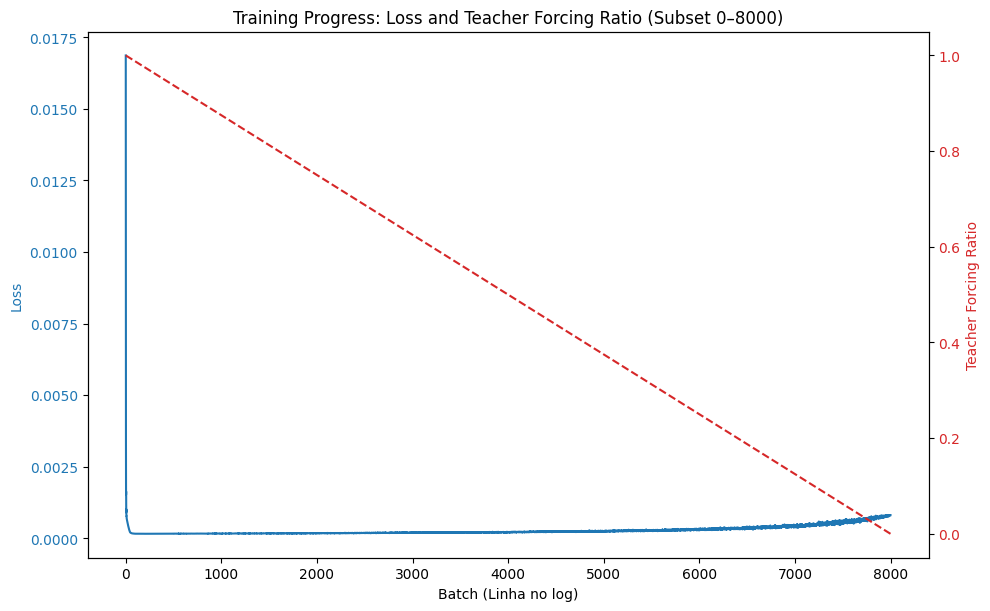

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Plotar CSV
file_path = os.path.join(base_path, "train_norm_log.csv")
log_file = pd.read_csv(file_path)

# Carregar apenas um subset: 0 até 8000
subset_log = log_file.iloc[:8000]

# Plotando Loss e Teacher Forcing Ratio
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loss
color = 'tab:blue'
ax1.set_xlabel('Batch (Linha no log)')
ax1.set_ylabel('Loss', color=color)
ax1.plot(subset_log.index, subset_log['loss'], color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Segunda escala para Teacher Forcing Ratio
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Teacher Forcing Ratio', color=color)
ax2.plot(subset_log.index, subset_log['teacher_forcing_ratio'], color=color, linestyle='--', label='Teacher Forcing Ratio')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Progress: Loss and Teacher Forcing Ratio (Subset 0–8000)')
plt.show()


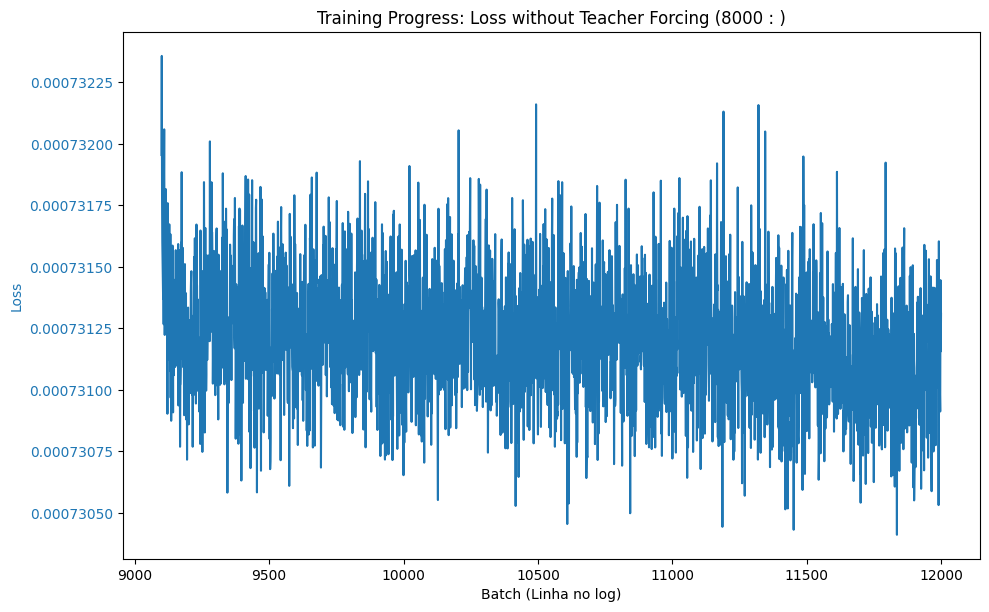

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Plotar CSV
file_path = os.path.join(base_path, "train_norm_log.csv")
log_file = pd.read_csv(file_path)

# Carregar apenas um subset: 8000 em diante
subset_log = log_file.iloc[9100:]

# Plotando Loss e Teacher Forcing Ratio
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loss
color = 'tab:blue'
ax1.set_xlabel('Batch (Linha no log)')
ax1.set_ylabel('Loss', color=color)
ax1.plot(subset_log.index, subset_log['loss'], color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Progress: Loss without Teacher Forcing (8000 : )')
plt.show()


🔍 MSE Loss on forecast: 1312572.000000


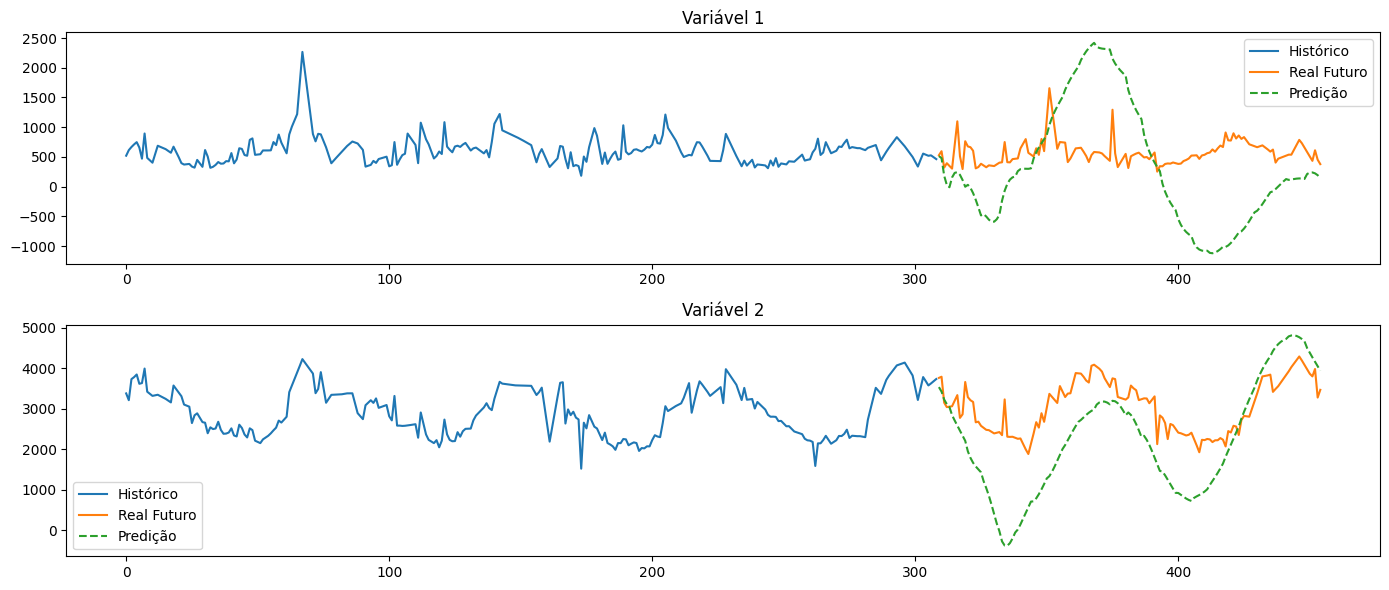

In [57]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def prepare_input(ordered_data, dates, encode_datetime_features, idx, normalize_factor=16384.0):
    import datetime

    targets = ordered_data[idx, 0, [3, 8], :] / normalize_factor  # (2, 455)

    # Gera as features temporais sem warning
    datetime_features = torch.stack([
        encode_datetime_features(datetime.datetime.strptime(date_str, "%Y_%m_%d")).clone().detach().float()
        for date_str in dates
    ])  # (455, 4)

    # Concatena targets (2) + datetime features (4) = (6 features)
    x_targets = torch.tensor(targets.T, dtype=torch.float32)  # (455, 2)
    input_sequence = torch.cat([x_targets, datetime_features], dim=1)  # (455, 6)

    return input_sequence

def predict_and_plot(model, input_sequence, forecast_len=146, normalize_factor=16384.0):
    """
    Faz a previsão e plota histórico, real futuro e predição.

    Args:
        model: modelo GRUForecastModel já treinado.
        input_sequence: tensor (455, 6) — 309 históricos + 146 previstos.
        forecast_len: número de passos a prever (146 por padrão).
        normalize_factor: fator para desnormalizar na hora de plotar.
    """
    model.eval()
    device = model.device

    input_sequence = input_sequence.to(device)

    # Separar entradas
    encoder_inputs = input_sequence[:309, :]  # (309, 6)
    real_future = input_sequence[309:309+forecast_len, :2]  # (146, 2) - real Y
    decoder_externals = input_sequence[309:309+forecast_len, 2:]  # (146, 4) - 4 externas

    # Prepara batch_size=1
    encoder_inputs = encoder_inputs.unsqueeze(0)  # (1, 309, 6)
    decoder_externals = decoder_externals.unsqueeze(0)  # (1, 146, 4)

    with torch.no_grad():
        prediction = model(encoder_inputs, decoder_externals, teacher_forcing_targets=None, teacher_forcing_ratio=0.0)
        prediction = prediction.squeeze(0).cpu().numpy()  # (146, 2)
        real_future = real_future.cpu().numpy()

    # Desnormalizar para plotar valores reais
    prediction_real = prediction * normalize_factor
    real_future_real = real_future * normalize_factor
    history_real = (input_sequence[:309, :2].cpu().numpy()) * normalize_factor

    # Calcula o Loss
    criterion = nn.MSELoss()
    loss = criterion(torch.tensor(prediction_real), torch.tensor(real_future_real)).item()
    print(f"🔍 MSE Loss on forecast: {loss:.6f}")

    # Plot
    plt.figure(figsize=(14, 6))

    # Variável 1
    plt.subplot(2, 1, 1)
    plt.plot(range(309), history_real[:, 0], label="Histórico")
    plt.plot(range(309, 309+forecast_len), real_future_real[:, 0], label="Real Futuro")
    plt.plot(range(309, 309+forecast_len), prediction_real[:, 0], '--', label="Predição")
    plt.title("Variável 1")
    plt.legend()

    # Variável 2
    plt.subplot(2, 1, 2)
    plt.plot(range(309), history_real[:, 1], label="Histórico")
    plt.plot(range(309, 309+forecast_len), real_future_real[:, 1], label="Real Futuro")
    plt.plot(range(309, 309+forecast_len), prediction_real[:, 1], '--', label="Predição")
    plt.title("Variável 2")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return loss

input_sequence = prepare_input(ordered_data, dates, encode_datetime_features, idx=0)
loss = predict_and_plot(model, input_sequence)
